In [1]:
# Сделать сравнение с отбором фич из склерн и попробовать отбирать объекты своим методом

### https://towardsdatascience.com/logistic-regression-classifier-on-census-income-data-e1dbef0b5738

## Подготовка данных

In [2]:
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import os
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
from sklearn.decomposition import PCA
%matplotlib inline

In [3]:
def load_dataset(path, urls):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        data = requests.get(url).content
        filename = os.path.join(path, os.path.basename(url))
        with open(filename, "wb") as file:
            file.write(data)

In [4]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
train_data = pd.read_csv('adult/adult.data', names=columns, 
             sep=' *, *', na_values='?')
test_data  = pd.read_csv('adult/adult.test', names=columns, 
             sep=' *, *', skiprows=1, na_values='?')

C:\Users\Irina\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
C:\Users\Irina\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workClass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
num_attributes = train_data.select_dtypes(include=['int64'])
print(num_attributes.columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


In [7]:
#num_attributes.hist(figsize=(10,10))

In [8]:
cat_attributes = train_data.select_dtypes(include=['object'])
print(cat_attributes.columns)

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


In [9]:
#sns.countplot(y='workClass', hue='income', data = cat_attributes)

In [10]:
#sns.countplot(y='occupation', hue='income', data = cat_attributes)

In [11]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
    def __init__(self, type):
        self.type = type
  
    def fit(self, X, y=None):
        return self
  
    def transform(self,X):
        return X.select_dtypes(include=[self.type])

In [12]:
num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int64')),
    ("scaler", StandardScaler())
])

In [13]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
  
    def __init__(self, columns = None, strategy='most_frequent'):
        self.columns = columns
        self.strategy = strategy
    
    
    def fit(self,X, y=None):
        if self.columns is None:
            self.columns = X.columns

        if self.strategy is 'most_frequent':
            self.fill = {column: X[column].value_counts().index[0] for column in self.columns}
        else:
            self.fill ={column: '0' for column in self.columns}
      
        return self
      
    def transform(self,X):
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = X_copy[column].fillna(self.fill[column])
        return X_copy

In [14]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
    def __init__(self, dropFirst=True):
        self.categories=dict()
        self.dropFirst=dropFirst
    
    def fit(self, X, y=None):
        join_df = pd.concat([train_data, test_data])
        join_df = join_df.select_dtypes(include=['object'])
        for column in join_df.columns:
            self.categories[column] = join_df[column].value_counts().index.tolist()
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.select_dtypes(include=['object'])
        for column in X_copy.columns:
            X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
        return pd.get_dummies(X_copy, drop_first=self.dropFirst)

In [15]:
cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=
          ['workClass','occupation', 'native-country'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
])

In [16]:
full_pipeline = FeatureUnion([("num_pipe", num_pipeline), ("cat_pipeline", cat_pipeline)])

In [17]:
train_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [18]:
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

In [19]:
train_copy = train_data.copy()
train_copy["income"] = train_copy["income"].apply(lambda x:0 if 
                        x=='<=50K' else 1)
X_train = train_copy.drop('income', axis =1)
Y_train = train_copy['income']

In [20]:
X_train_processed=full_pipeline.fit_transform(X_train)

In [21]:
X_train_processed.shape

(32561, 81)

In [22]:
test_copy = test_data.copy()
test_copy["income"] = test_copy["income"].apply(lambda x:0 if 
                      x=='<=50K.' else 1)
X_test = test_copy.drop('income', axis =1)
Y_test = test_copy['income']

In [23]:
X_test_processed = full_pipeline.fit_transform(X_test)

## Вычислительный эксперимент

In [24]:
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import itertools


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import copy
import math

import matplotlib
import matplotlib.pyplot as plt

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.float_format','{:,.5f}'.format)
pd.set_option('display.max_columns', None)
from IPython import display

In [26]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['figure.figsize'] = [7, 5]
### Сохранение изображения ###
plt.savefig('1.svg') # Поддерживаемые форматы: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

<Figure size 504x360 with 0 Axes>

In [27]:
from utils import *
from logreg import *

<Figure size 504x360 with 0 Axes>

In [28]:
df = pd.DataFrame(X_train_processed)
outliers_removed, outliers = remove_outliers(df.iloc[:, :4])
X_train_processed = np.array(df.loc[outliers_removed])
Y_train = Y_train[outliers_removed]
X_train_processed.shape, Y_train.shape

((28438, 81), (28438,))

In [29]:
X = X_train_processed[:, :30]
T = np.array(Y_train)
X_test = X_test_processed[:, :30]
Y_test = np.array(Y_test)

In [29]:
# write
%store X
%store T
%store X_test
%store Y_test

Stored 'X' (ndarray)
Stored 'T' (ndarray)
Stored 'X_test' (ndarray)
Stored 'Y_test' (ndarray)


In [592]:
# read
%store -r X
%store -r T
%store -r X_test
%store -r Y_test

In [30]:
# [-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
#  -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
#  -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
#  -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
#  -0.02122398 -0.02894507]
# feat_threshold=1e+21

In [31]:
# Еще одни хорошие веса 
# [-0.00322571  0.00808102  0.03772372  0.00349156  0.00515101 -0.00148892
#  -0.03837542 -0.00053028  0.0012046   0.04926484 -0.00384722  0.00603095
#  -0.00069424 -0.02337356  0.02285646  0.01503866  0.01582064 -0.01818775
#   0.02805589 -0.02803702  0.01173714  0.04380911 -0.01981073 -0.01132595
#   0.00199303 -0.01006951]
# feat_threshold=1e+20

In [32]:
# from logreg import *
# clf = SuperpositionModel()

In [145]:
# clf.w

In [58]:
# w = np.array([-0.03650337, -0.0107314,  -0.00234493, -0.00433932, -0.03974928, -0.02914917,
#  -0.01633966, -0.00345402, -0.03254841, -0.0266781,  -0.04509162, -0.04688906,
#  -0.00671441,  0.00415988, -0.02440513, -0.00289427, -0.0157322,  -0.03586732,
#  -0.01573701,  0.00779581, -0.02368145,  0.00832795, -0.07535983, -0.00652688,
#  -0.02122398, -0.02894507, -0.02633966, -0.04345402, -0.03254841, -0.0666781,
#  -0.0033966,  -0.079402,   -0.03254841, -0.04301776, -0.0053454,  -0.0053454,
#  -0.01671441])
# clf.set_weights(w)
# len(w)

37

In [59]:
########### Здесь предположение о весах с дисперсиями = 1/n

In [62]:
1/37

0.02702702702702703

In [63]:
w.std()

0.021305077225157818

In [44]:
b = math.sqrt(3/37)

In [45]:
4*b*b/12

0.027027027027027032

In [46]:
from scipy.stats import uniform

In [73]:
vals = uniform.rvs(loc=-b, scale=0.0905, size=37, random_state=None)

In [74]:
vals

array([-0.25085152, -0.19870775, -0.21850195, -0.23056881, -0.27062771,
       -0.27062989, -0.27949083, -0.20635846, -0.23034649, -0.22066683,
       -0.2828845 , -0.19697056, -0.20941134, -0.26553071, -0.26829224,
       -0.26814929, -0.25721348, -0.23725694, -0.24565637, -0.25839116,
       -0.22937471, -0.2721232 , -0.25830831, -0.25159165, -0.24347307,
       -0.21368897, -0.26667692, -0.23820918, -0.23113388, -0.28054364,
       -0.22976459, -0.26931497, -0.27886023, -0.19887326, -0.1973577 ,
       -0.21158744, -0.25717985])

In [75]:
1/39

0.02564102564102564

In [76]:
vals.std()

0.026732424518714597

In [77]:
len(arr)

NameError: name 'arr' is not defined

In [192]:
clf.set_weights(vals)

In [115]:
######## ЛУЧШИЕ ВЕСА 
# vals = uniform.rvs(loc=-b, scale=0.0905, size=37, random_state=None)
best_weights = np.array([-0.27015687, -0.20060976, -0.2116125 , -0.22742436, -0.20588022,
       -0.21201508, -0.26786281, -0.20397081, -0.23593693, -0.21167406,
       -0.20365114, -0.25596808, -0.2747877 , -0.26411927, -0.24609414,
       -0.21071706, -0.20685128, -0.28411823, -0.23852477, -0.2469717 ,
       -0.26464664, -0.27389958, -0.25419323, -0.19941407, -0.25549753,
       -0.23779685, -0.22112418, -0.25183892, -0.19680112, -0.19764592,
       -0.2619611 , -0.23974641, -0.25751791, -0.25896933, -0.28140913,
       -0.22958183, -0.23925495])
# %store best_weights

Stored 'best_weights' (ndarray)


In [211]:
# ТОЖЕ РОК АУК 0,9
# w = np.array([-0.25085152, -0.19870775, -0.21850195, -0.23056881, -0.27062771,
       -0.27062989, -0.27949083, -0.20635846, -0.23034649, -0.22066683,
       -0.2828845 , -0.19697056, -0.20941134, -0.26553071, -0.26829224,
       -0.26814929, -0.25721348, -0.23725694, -0.24565637, -0.25839116,
       -0.22937471, -0.2721232 , -0.25830831, -0.25159165, -0.24347307,
       -0.21368897, -0.26667692, -0.23820918, -0.23113388, -0.28054364,
       -0.22976459, -0.26931497, -0.27886023, -0.19887326, -0.1973577 ,
       -0.21158744, -0.25717985])

In [230]:
# w = np.array([-0.22077681, -0.21877225, -0.21494743, -0.27804636, -0.25230625,
#        -0.27426125, -0.20663654, -0.22833892, -0.25480113, -0.27899537,
#        -0.2566035 , -0.25531831, -0.21871804, -0.22704845, -0.20445465,
#        -0.24201195, -0.27392412, -0.22019875, -0.21589635, -0.23395181,
#        -0.21497487, -0.2400589 , -0.23744008, -0.24605494, -0.28244697,
#        -0.27498322, -0.28190306, -0.22715226, -0.25629818, -0.23872175,
#        -0.20261263, -0.26218645, -0.24760774, -0.21637002, -0.26404116,
#        -0.27778072, -0.25852489])
# # с такими весами 21 итерация, рок 0,84, 22 признака

In [ ]:
############################################################################ закончилось предположение

In [43]:
arr = np.random.uniform(-b/7,b/7,37)

NameError: name 'b' is not defined

In [ ]:
arr.std()

In [580]:
clf = SuperpositionModel()
clf.set_weights(vals)
clf.w

array([-0.20070092, -0.26379985, -0.23805974, -0.26001474, -0.19239003,
       -0.21409241, -0.24055462, -0.26474886, -0.24235699, -0.2410718 ,
       -0.20447153, -0.21280194, -0.19020814, -0.22776544, -0.25967761,
       -0.20595224, -0.20164984, -0.2197053 , -0.20072836, -0.22581239,
       -0.22319357, -0.23180843, -0.26820046, -0.26073672, -0.26765655,
       -0.21290575, -0.24205167, -0.22447524, -0.18836612, -0.24793994,
       -0.23336124, -0.20212351, -0.24979466, -0.26353421, -0.24427838,
       -0.25591036, -0.18636325, -0.197366  , -0.21317785])

In [577]:
clf.w.std()

0.025201638062694678

In [ ]:
########################################################

## СТРОЮ НАИБОЛЕЕ ОПТИМАЛЬНУЮ МОДЕЛЬ

In [53]:
from logreg import *
clf = SuperpositionModel()

In [78]:
clf.w

array([-4.84384153e+25,  9.37156807e+24, -2.35360001e+25,  8.25140549e+25,
        1.41316171e+25, -4.42448694e+25, -2.47571861e+24,  2.07044195e+25,
        1.74916823e+25,  1.88372448e+25,  4.54647105e+25,  2.11614222e+26,
       -5.81079722e+25, -8.73180325e+25, -8.36747571e+25, -8.06435719e+25,
       -8.51628531e+25,  3.64936773e+25,  3.53284078e+25,  3.40185091e+25,
        3.60078671e+25,  7.78890172e+24,  2.37424240e+25,  2.98704735e+25,
        7.21137976e+24,  4.35951076e+25, -5.32757447e+25, -4.34303837e+25,
       -6.02281803e+25,  1.17758976e+25,  1.74435173e+25,  6.77472383e+25])

In [79]:
best_weights = np.array([-0.27015687, -0.20060976, -0.2116125 , -0.22742436, -0.20588022,
       -0.21201508, -0.26786281, -0.20397081, -0.23593693, -0.21167406,
       -0.20365114, -0.25596808, -0.2747877 , -0.26411927, -0.24609414,
       -0.21071706, -0.20685128, -0.28411823, -0.23852477, -0.2469717 ,
       -0.26464664, -0.27389958, -0.25419323, -0.19941407, -0.25549753,
       -0.23779685, -0.22112418, -0.25183892, -0.19680112, -0.19764592,
       -0.2619611 , -0.23974641, -0.25751791, -0.25896933, -0.28140913,
       -0.22958183, -0.23925495])

In [80]:
clf.set_weights(vals)
len(clf.w)

37

In [81]:
len(best_weights)

37

In [82]:
pd.isna(T).sum()

0

In [83]:
clf.fit(X, T, feat_threshold=5*1e+19, n_clusters=6, iterations=12, algo_clust='km_simple')

[-0.25085152 -0.19870775 -0.21850195 -0.23056881 -0.27062771 -0.27062989
 -0.27949083 -0.20635846 -0.23034649 -0.22066683 -0.2828845  -0.19697056
 -0.20941134 -0.26553071 -0.26829224 -0.26814929 -0.25721348 -0.23725694
 -0.24565637 -0.25839116 -0.22937471 -0.2721232  -0.25830831 -0.25159165
 -0.24347307 -0.21368897 -0.26667692 -0.23820918 -0.23113388 -0.28054364
 -0.22976459 -0.26931497 -0.27886023 -0.19887326 -0.1973577  -0.21158744
 -0.25717985]

0-я итерация

Веса
[-0.25085152 -0.19870775 -0.21850195 -0.23056881 -0.27062771 -0.27062989
 -0.27949083 -0.20635846 -0.23034649 -0.22066683 -0.2828845  -0.19697056
 -0.20941134 -0.26553071 -0.26829224 -0.26814929 -0.25721348 -0.23725694
 -0.24565637 -0.25839116 -0.22937471 -0.2721232  -0.25830831 -0.25159165
 -0.24347307 -0.21368897 -0.26667692 -0.23820918 -0.23113388 -0.28054364
 -0.22976459 -0.26931497 -0.27886023 -0.19887326 -0.1973577  -0.21158744
 -0.25717985]

Скоры объектов на 0-й итерации
[0.22462833 0.38217187 0.35808248 ... 0.2953


Массив метрических признаков на 4-й итерации
[[ 0.19697156 -0.7122453   0.1409389  -0.83462299  0.42518895  0.4138485 ]
 [ 2.53344319  0.50350234  0.32092595  1.36532098  1.33142164  2.22029586]
 [-0.23166604 -0.07318105 -0.15991778  0.08119736 -0.89251487 -0.53292666]
 ...
 [ 0.2879921   0.00648692  0.83075935  1.1080971  -0.90492468  0.94743991]
 [ 1.93093042  1.47541589 -1.95178086  0.67756118  1.17379214  0.10239771]
 [ 0.77263468  0.60183028  1.20267507  1.60286751  0.50527295  1.56749567]]

Скоры объектов на 4-й итерации
[0.12417815 0.33109446 0.0158191  ... 0.05139258 0.00219303 0.99439077]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.70041192 -0.40597021  0.51548216  2.60655554 -0.23698757 -0.28265981
 -0.15506224  0.31214735  0.62150929 -2.28313914 -1.04425529 -2.16216041
 -2.24463388 -2.31693422 -2.23839832 -2.22979481  1.11515412 -0.27076901
  0.38165962 -0.21693434 -0.89192479 -0.58511861 -0.32535312 -0.90765678
 -1.14659377  0.3144027  -3.131052


Массив метрических признаков на 9-й итерации
[[ 0.19697156 -0.7122453   0.1409389  -0.83462299  0.42518895  0.4138485 ]
 [ 2.53344319  0.50350234  0.32092595  1.36532098  1.33142164  2.22029586]
 [-0.23166604 -0.07318105 -0.15991778  0.08119736 -0.89251487 -0.53292666]
 ...
 [ 0.2879921   0.00648692  0.83075935  1.1080971  -0.90492468  0.94743991]
 [ 1.93093042  1.47541589 -1.95178086  0.67756118  1.17379214  0.10239771]
 [ 0.77263468  0.60183028  1.20267507  1.60286751  0.50527295  1.56749567]]

Скоры объектов на 9-й итерации
[0.1200127  0.3302285  0.01537185 ... 0.05129383 0.00179367 0.99463065]

Алгоритм сошелся за 9 итераций

10-я итерация

Веса
[-0.70142817 -0.42496134  0.51982021  2.60490444 -0.23608308 -0.28427923
 -0.1569326   0.31029297  0.62041758 -2.5695867  -1.75607509 -2.15632031
 -2.24877048 -2.32165555 -2.24150546 -2.23788167  1.09813149 -0.27305772
  0.37939472 -0.21778286 -0.89533366 -0.58788926 -0.32763172 -0.91183482
 -1.14881781  0.31216362 -3.33769099 -0.42964225 

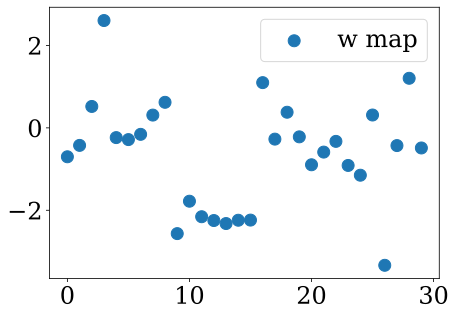

In [84]:
clf.plot_weights()

In [85]:
pred = clf.predict(X_test)

In [86]:
roc_auc_score(Y_test, pred)

0.9012257603291667

In [338]:
pred

array([0.02846528, 0.31473418, 0.7111761 , ..., 0.84138275, 0.73823836,
       0.92141356])

In [339]:
len(clf.get_cols())

32

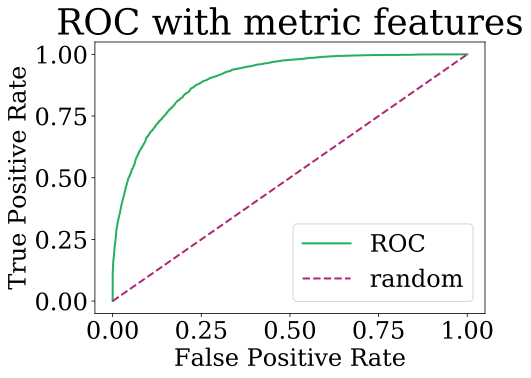

In [340]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred, pos_label=None)
plot_roc_cur(fpr, tpr, title='ROC with metric features')

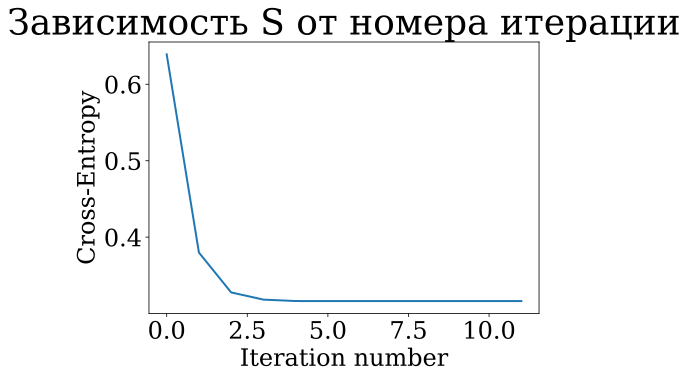

In [341]:
clf.plot_cross_entropy()

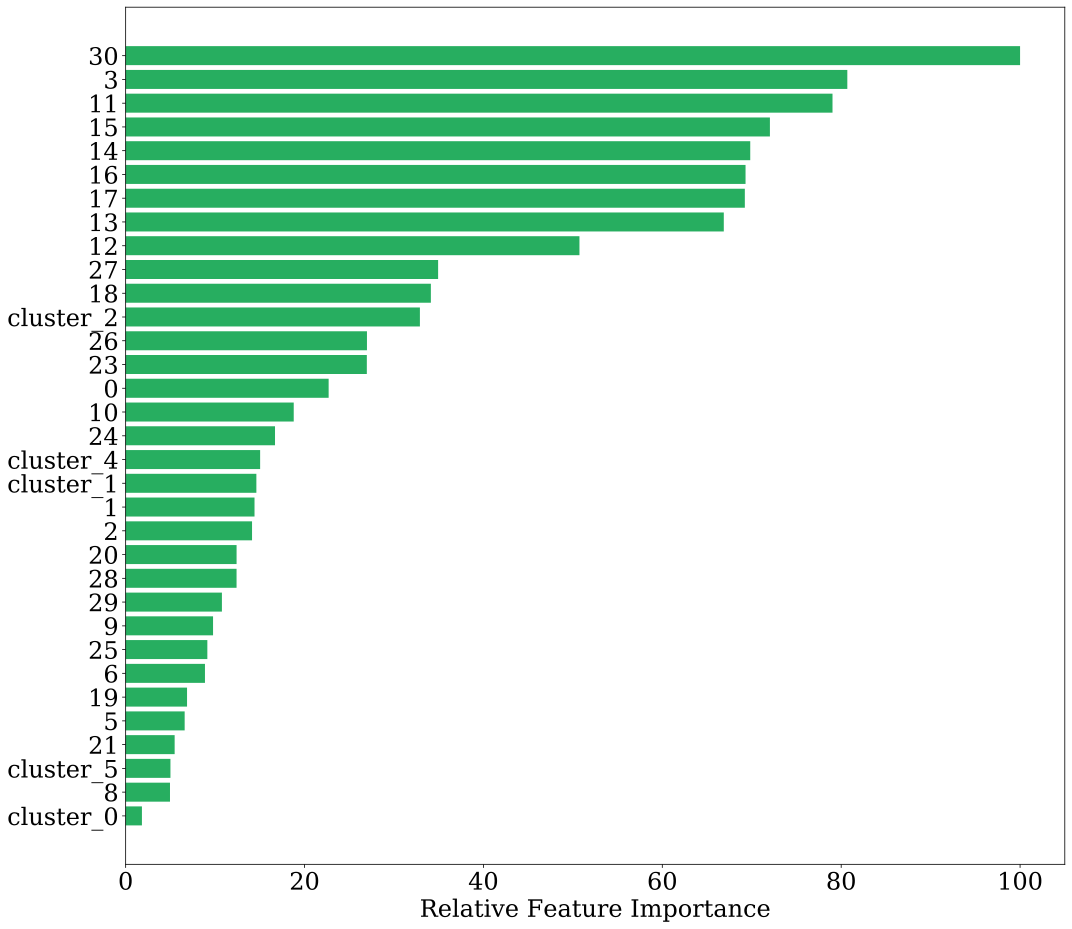

In [52]:
w = clf.get_weights()
cols = clf.get_cols()

plot_feature_importance(w, cols)
plt.savefig('feat_imp.svg')

In [343]:
# cols_name = ['0',
#  'age',
#  'education-num',
#  'capital-gain',
#  'capital-loss',
#  'hours-per-week',
#  'workClass_Self-emp-not-inc',
#  'workClass_Local-gov',
#  'workClass_State-gov',
#  'workClass_Self-emp-inc',
#  'workClass_Federal-gov',
#  'workClass_Without-pay',
#  'workClass_Never-worked',
#  'marital-status_Never-married',
#  'marital-status_Divorced',
#  'marital-status_Separated',
#  'marital-status_Widowed',
#  'marital-status_Married-spouse-absent',
#  'marital-status_Married-AF-spouse',
#  'occupation_Craft-repair',
#  'occupation_Exec-managerial',
#  'occupation_Adm-clerical',
#  'occupation_Sales',
#  'occupation_Other-service',
#  'occupation_Machine-op-inspct',
#  'occupation_Transport-moving',
#  'occupation_Handlers-cleaners',
#  'occupation_Farming-fishing',
#  'occupation_Tech-support',
#  'occupation_Protective-serv',
#  'occupation_Priv-house-serv']

In [470]:
cols_name2 = ['Никогда не состоял в браке',
             'Возраст',
              'Образование',
              'Прирост капитала',
              'Потеря капитала',
              'Занятость часов в неделю',
              'Раб. класс: предприниматель',
              'Раб. класс: местная власть',
              'Вид деятельности: другое',
#               'Раб. класс: власть штата',
              'Раб. класс: наемный работник',
              'Раб. класс: федеральная власть',
              'Волонтер',
              'Безработный',
              'Безработный*Не состоял в браке',
              'Разведен',
              'Гражданский брак',
              'Вдовец',
#               'Брачно-status_Married-супруг-отсутствует',
              'Раб. класс: федеральная власть',
             # 'Брачно-status_Married-AF-супруга',
              'Состоит в браке',
              'Вид деятельности: ремонтные работы',
              'Вид деятельности: управленец',
              'Вид деятельности: офис',
              'Вид деятельности: продажи',
              'Вид деятельности: услуги',
              'Вид деятельности: инспектор',
              'Вид деятельности: транспорт',
              'Наем. работник*Не состоял в браке',
#               'Вид деятельности: уборщик',
#               'Вид деятельности: рыбалка',
              '0',
#               'Вид деятельности: другое',
              'Вид деятельности: тех. поддержка',
              'Вид деятельности: обеспечение безопасности',
              'Вид деятельности: охрана частных предприятий']

In [471]:
len(cols_name2)

31

In [472]:
dict_cols_name = {str(i): cols_name2[i] for i in range(len(cols_name2))}

In [473]:
dict_clust_name = {
 'cluster_2': 'Портрет клиента №2 (расстояние до кластера № 2)',
'cluster_5': 'Портрет клиента №5 (расстояние до кластера № 5)',
 'cluster_3': 'Портрет клиента №3 (расстояние до кластера № 3)',
    'cluster_4': 'Портрет клиента №4 (расстояние до кластера № 4)',
 'cluster_1': 'Портрет клиента №1 (расстояние до кластера № 1)',
}

In [474]:
for k,v in dict_clust_name.items():
    dict_cols_name[k] = v

In [475]:
feature_importance = abs(clf.w)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

In [476]:
[x if x not in dict_cols_name else dict_cols_name[x] for x in np.array(cols)[sorted_idx]]

['Портрет клиента №3 (расстояние до кластера № 3)',
 'Вид деятельности: транспорт',
 'Вид деятельности: ремонтные работы',
 'Портрет клиента №5 (расстояние до кластера № 5)',
 'Вид деятельности: продажи',
 'Раб. класс: предприниматель',
 'Занятость часов в неделю',
 'Вид деятельности: другое',
 'Раб. класс: наемный работник',
 'Вид деятельности: обеспечение безопасности',
 'Вид деятельности: инспектор',
 'Вид деятельности: управленец',
 'Возраст',
 'Вид деятельности: тех. поддержка',
 'Образование',
 'Раб. класс: федеральная власть',
 'Портрет клиента №4 (расстояние до кластера № 4)',
 'Наем. работник*Не состоял в браке',
 'Вид деятельности: услуги',
 'Портрет клиента №1 (расстояние до кластера № 1)',
 '0',
 'Никогда не состоял в браке',
 'Состоит в браке',
 'Безработный*Не состоял в браке',
 'Портрет клиента №2 (расстояние до кластера № 2)',
 'Вдовец',
 'Раб. класс: федеральная власть',
 'Разведен',
 'Гражданский брак',
 'Волонтер',
 'Прирост капитала',
 'Вид деятельности: охрана част

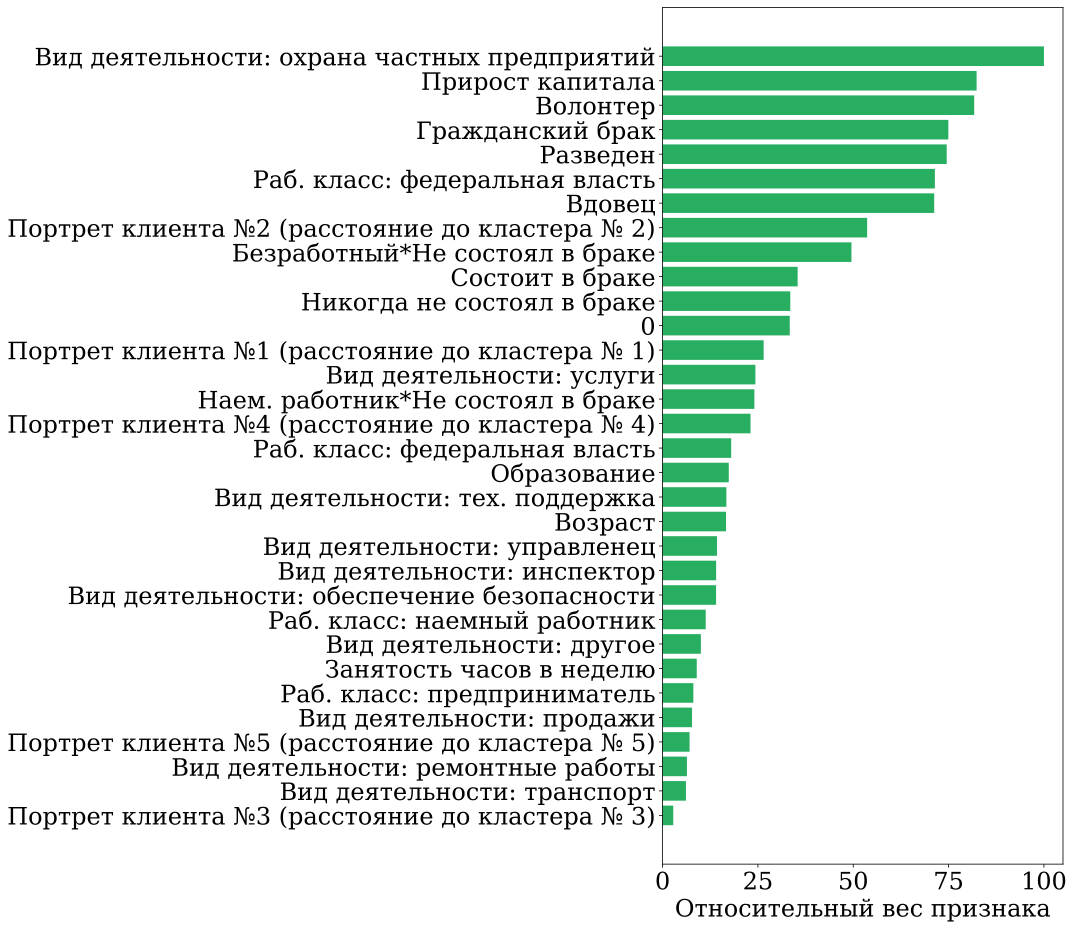

In [477]:
feature_importance = abs(w)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(15,13))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='#27AE60')
featax.set_yticks(pos)
featax.set_yticklabels([x if x not in dict_cols_name else dict_cols_name[x] for x in np.array(cols)[sorted_idx]])
featax.set_xlabel('Relative Feature Importance')

plt.xlabel('Относительный вес признака')
plt.tight_layout()
plt.savefig('best_feat_imp.png')

In [427]:
len(clf.w)

32

In [414]:
%store best_weights

Stored 'best_weights' (ndarray)


In [43]:
fpr_list = []
tpr_list = []
thresholds_list = []
len_w_list = []
rocs = []
    
for thresh in [4e+18, 8e+17, 5e+19]:
    clf = SuperpositionModel()
    best_weights = np.array([-0.27015687, -0.20060976, -0.2116125 , -0.22742436, -0.20588022,
       -0.21201508, -0.26786281, -0.20397081, -0.23593693, -0.21167406,
       -0.20365114, -0.25596808, -0.2747877 , -0.26411927, -0.24609414,
       -0.21071706, -0.20685128, -0.28411823, -0.23852477, -0.2469717 ,
       -0.26464664, -0.27389958, -0.25419323, -0.19941407, -0.25549753,
       -0.23779685, -0.22112418, -0.25183892, -0.19680112, -0.19764592,
       -0.2619611 , -0.23974641, -0.25751791, -0.25896933, -0.28140913,
       -0.22958183, -0.23925495])
    clf.set_weights(best_weights)
    clf.fit(X, T, feat_threshold=thresh, n_clusters=6, iterations=12, algo_clust='km_simple')
    pred = clf.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred, pos_label=None)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresholds_list.append(thresholds)
    rocs.append(roc_auc_score(Y_test, pred))
    len_w_list.append(len(clf.w)-1)
    
# plot_roc_cur(fpr, tpr, title='ROC with metric features')

[-0.27015687 -0.20060976 -0.2116125  -0.22742436 -0.20588022 -0.21201508
 -0.26786281 -0.20397081 -0.23593693 -0.21167406 -0.20365114 -0.25596808
 -0.2747877  -0.26411927 -0.24609414 -0.21071706 -0.20685128 -0.28411823
 -0.23852477 -0.2469717  -0.26464664 -0.27389958 -0.25419323 -0.19941407
 -0.25549753 -0.23779685 -0.22112418 -0.25183892 -0.19680112 -0.19764592
 -0.2619611  -0.23974641 -0.25751791 -0.25896933 -0.28140913 -0.22958183
 -0.23925495]

0-я итерация

Веса
[-0.27015687 -0.20060976 -0.2116125  -0.22742436 -0.20588022 -0.21201508
 -0.26786281 -0.20397081 -0.23593693 -0.21167406 -0.20365114 -0.25596808
 -0.2747877  -0.26411927 -0.24609414 -0.21071706 -0.20685128 -0.28411823
 -0.23852477 -0.2469717  -0.26464664 -0.27389958 -0.25419323 -0.19941407
 -0.25549753 -0.23779685 -0.22112418 -0.25183892 -0.19680112 -0.19764592
 -0.2619611  -0.23974641 -0.25751791 -0.25896933 -0.28140913 -0.22958183
 -0.23925495]

Скоры объектов на 0-й итерации
[0.21890915 0.340335   0.36479145 ... 0.2968


Массив метрических признаков на 5-й итерации
[[ 1.3141185  -0.56900364 -1.368305   -0.63764364  1.20741377  1.19600392]
 [ 0.65657563 -1.55151036  0.6483358  -0.09627601  0.88496566  1.344363  ]
 [-0.29757464  0.63775383  0.78462084  0.92616368  0.13627794 -0.06823166]
 ...
 [-0.10158672  0.70494778 -0.4291831   0.9726827   0.27784895  0.07027223]
 [-0.0285801   0.69344457 -2.46215657 -0.28232878  0.07220784 -0.82255581]
 [ 2.35723364  1.64192311  2.53248142  2.64863183  2.04751857  1.67400918]]

Скоры объектов на 5-й итерации
[0.09111287 0.7150345  0.01547638 ... 0.03264892 0.01387833 0.99647628]
Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[ 0.83790125  2.51221119  0.3589876   0.59938612 -2.92579065 -2.93605257
 -2.29935984 -2.64956864 -2.31924169 -2.5630453   0.36331664 -0.41730751
  0.35947269 -0.55805405 -1.3984079  -0.82962023 -0.47858774 -1.334623
 -1.36689499 -3.94572493  0.2067132 ]
Дисперсии весов
[-1.65835933e+16 -1.04091487e+16  2.14114613e+16 -1.047


Массив метрических признаков на 11-й итерации
[[ 1.39880571 -0.47251895 -0.12707972 -0.71269938  1.42236758  1.23960001]
 [-0.45650977 -1.4664316   1.0365857   0.02446045  0.8603195   1.39583622]
 [ 0.21981473  0.70250735  0.28418497  1.04023278 -0.08929983  0.0263512 ]
 ...
 [ 0.46107354  0.78102275 -1.0404273   1.00403225  0.24955064  0.15567449]
 [ 0.25515894  0.76924856 -1.98017023 -0.24538306  0.29328991 -0.69645017]
 [ 0.97405741  1.42979923  2.24166475  2.37734015  1.86419948  1.40350873]]

Скоры объектов на 11-й итерации
[0.09079594 0.72911264 0.01477806 ... 0.03173156 0.01242044 0.99547984]

Алгоритм сошелся за 11 итераций
[-0.27015687 -0.20060976 -0.2116125  -0.22742436 -0.20588022 -0.21201508
 -0.26786281 -0.20397081 -0.23593693 -0.21167406 -0.20365114 -0.25596808
 -0.2747877  -0.26411927 -0.24609414 -0.21071706 -0.20685128 -0.28411823
 -0.23852477 -0.2469717  -0.26464664 -0.27389958 -0.25419323 -0.19941407
 -0.25549753 -0.23779685 -0.22112418 -0.25183892 -0.19680112 -0.197

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
fig = plt.subplots()

plt.rcParams['figure.figsize'] = [10, 8]

plt.plot(fpr_list[0], tpr_list[0], color='#27AE60', label='AUC={:.3f}, кол-во признаков={}'.format(rocs[0], len_w_list[0]))
plt.plot(fpr_list[1], tpr_list[1], color='#a427ae', label='AUC={:.3f}, кол-во признаков={}'.format(rocs[1], len_w_list[1]))
plt.plot(fpr_list[2], tpr_list[2], color='#AE2775', linestyle='--', label='AUC={:.3f}, кол-во признаков={}'.format(rocs[2], len_w_list[2]))
# plt.plot(fpr_list[3], tpr_list[3], color='#a427ae', alpha=0.5, label='AUC={:.2f}, кол-во признаков={}'.format(rocs[3], len_w_list[3]))
plt.plot([0, 1], [0, 1], color='#27aea4', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для моделей разной сложности')
plt.legend(loc='best', fontsize='xx-large')
# показываем график
# plt.show()
plt.savefig('rocs_by_feats.png')

In [ ]:
len_w_list

In [362]:
len(clf.cols)

32

In [363]:
list_w3 = clf.list_w
list_w3[0]

array([-0.13641426,  0.19510892,  0.37762176,  1.91335702, -0.22876621,
        0.12746753, -0.25560635, -0.06427621, -0.19994493,  0.43409402,
        0.35063189, -0.78889189,  0.10315472, -1.24765516, -1.39233619,
       -1.31823249, -1.4988911 , -1.33488293,  0.44420982, -0.28685394,
        0.34454934, -0.26621498, -0.04387674, -0.25946367, -0.42617592,
       -0.37213577, -0.34115831, -0.68922757,  0.01622218,  0.08840686,
       -0.29299254, -0.10795996, -0.10546967, -0.10520231, -0.09983963,
       -0.10873325, -0.10800825])

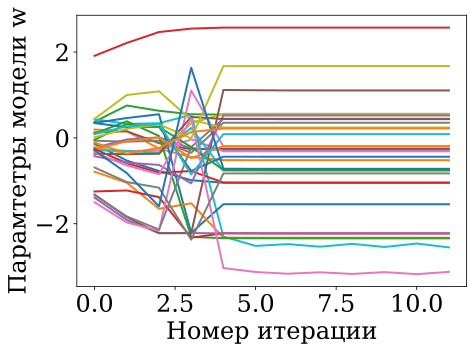

In [364]:
list_w3 = clf.list_w
for i in range(len(list_w3[-1])):
    a = []
    for j in range(len(list_w3)):
        a.append(list_w3[j][i])
    plt.plot(a)
    #plt.show()
    plt.xlabel('Номер итерации')
    plt.ylabel('Парамтетры модели w')
#     plt.title('Параметры модели w')

In [457]:
import numpy as np
from sklearn.model_selection import train_test_split
from logreg import *
T = np.array(T)

costs = []
rocs = []
rocs_val = []
preds_test = []
list_w3_ = []
list_var_w3_ = []

n_bootstraps = 10
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)

i = 0
X_train_, X_val_, T_train_, T_val_ = train_test_split(X, T, test_size=0.33, random_state=42)
for i in range(n_bootstraps):
    
    print('**************')
    print('\n{}-я итерация бутстрэпа'.format(i))
        
    train_index = list(rng.random_integers(0, len(X_train_) - 1, len(X_train_)))
    test_index = list(rng.random_integers(0, len(X_val_) - 1, len(X_val_)))

    X_train, X_val = X_train_[train_index], X_val_[test_index]
    t_train, t_val = T_train_[train_index], T_val_[test_index]
    clf = SuperpositionModel()

#     w = np.array([-0.03650337, -0.0107314,  -0.00234493, -0.00433932, -0.03974928, -0.02914917,
#      -0.01633966, -0.00345402, -0.03254841, -0.0266781,  -0.04509162, -0.04688906,
#      -0.00671441,  0.00415988, -0.02440513, -0.00289427, -0.0157322,  -0.03586732,
#      -0.01573701,  0.00779581, -0.02368145,  0.00832795, -0.07535983, -0.00652688,
#      -0.02122398, -0.02894507, -0.02633966, -0.04345402, -0.03254841, -0.0666781,
#      -0.0033966,  -0.079402,   -0.03254841, -0.04301776, -0.0053454,  -0.0053454])

    a = 1
    while (a>1/37) or (a<0.0269):
        vals = uniform.rvs(loc=-b, scale=0.0905, size=37, random_state=None)
        a = vals.std()
    print('Дисперсия начального вектора параметров', a)
        
    w = vals
#     w = arr_w[i]
    clf.set_weights(w)

    clf.fit(X=X_train, T=t_train, feat_threshold=1.0*1e+21, n_clusters=6, algo_clust='km_sklearn')
    costs.append(copy.deepcopy(clf.get_costs()))
    
    pred3 = clf.predict(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(t_train, pred3, pos_label=None)
    rocs.append((fpr, tpr))
    
    pred3_val = clf.predict(X_val)
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(t_val, pred3_val, pos_label=None)
    rocs_val.append((fpr_val, tpr_val))
    
    pred3_test = clf.predict(X_test)
    preds_test.append(pred3_test)
    
    i = i+1

**************

0-я итерация бутстрэпа
Дисперсия начального вектора параметров 0.026944703865209817
[-0.21654462 -0.20643102 -0.20523214 -0.21382494 -0.24782212 -0.19589377
 -0.25039417 -0.2269518  -0.27017019 -0.19601677 -0.22103667 -0.21656673
 -0.27879461 -0.21565809 -0.21463493 -0.22395197 -0.25832958 -0.24043045
 -0.27475309 -0.24206877 -0.26268134 -0.25315412 -0.27003206 -0.26392748
 -0.27781794 -0.20149633 -0.23674523 -0.24884225 -0.23632725 -0.22788686
 -0.20131737 -0.26857569 -0.2579999  -0.19643846 -0.25115443 -0.28270557
 -0.27138566]

0-я итерация

Веса
[-0.21654462 -0.20643102 -0.20523214 -0.21382494 -0.24782212 -0.19589377
 -0.25039417 -0.2269518  -0.27017019 -0.19601677 -0.22103667 -0.21656673
 -0.27879461 -0.21565809 -0.21463493 -0.22395197 -0.25832958 -0.24043045
 -0.27475309 -0.24206877 -0.26268134 -0.25315412 -0.27003206 -0.26392748
 -0.27781794 -0.20149633 -0.23674523 -0.24884225 -0.23632725 -0.22788686
 -0.20131737 -0.26857569 -0.2579999  -0.19643846 -0.25115443 -0


Массив метрических признаков на 4-й итерации
[[ 1.47642973 -1.91306127 -0.23506285 -0.05062702  0.52168906 -0.19138843]
 [ 1.32056429 -1.4622093  -0.97864586  1.13471616  1.21001398  0.28896599]
 [ 0.40861206  0.98783584  1.50894726 -0.4075829  -0.43018623  1.07009893]
 ...
 [-0.15969363 -0.71896618 -1.45953549 -0.15387306 -0.01784001 -0.95440485]
 [ 0.30665134 -0.5513381  -0.04639149 -1.27659431 -0.41915997 -0.61983966]
 [-0.40688593 -0.58996921 -0.87802901 -0.18420667 -0.64679726 -1.23005885]]

Скоры объектов на 4-й итерации
[0.08294239 0.05017107 0.00657572 ... 0.09061948 0.00256128 0.65232307]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[  2.15622259  -8.12751965   3.66041874  -0.7874666   -0.13605904
   0.53525113  -1.05324607  -1.09909007  -1.0985152   -0.98138601
  -1.13430477   2.39081487  -0.17087996  -3.22254394  -1.49303389
  -2.1269354   -1.35525894  -2.39806914  -0.49898052  -0.40671066
  -0.29294323  -0.62146219  -1.71773149  -1.10726374  -0.90910


Массив метрических признаков на 8-й итерации
[[ 1.47642973 -1.91306127 -0.23506285 -0.05062702  0.52168906 -0.19138843]
 [ 1.32056429 -1.4622093  -0.97864586  1.13471616  1.21001398  0.28896599]
 [ 0.40861206  0.98783584  1.50894726 -0.4075829  -0.43018623  1.07009893]
 ...
 [-0.15969363 -0.71896618 -1.45953549 -0.15387306 -0.01784001 -0.95440485]
 [ 0.30665134 -0.5513381  -0.04639149 -1.27659431 -0.41915997 -0.61983966]
 [-0.40688593 -0.58996921 -0.87802901 -0.18420667 -0.64679726 -1.23005885]]

Скоры объектов на 8-й итерации
[1.e-26 1.e+00 1.e-26 ... 1.e-26 1.e-26 1.e+00]
Недостаточно итераций для сходимости алгоритма.

9-я итерация

Веса
[-2.46598524e+25 -7.26107543e+25  5.40607176e+25  2.17310278e+25
 -5.65165008e+25 -1.43971196e+26 -1.83480205e+25 -2.68599141e+25
 -3.17048783e+25 -8.54086975e+24 -1.80316102e+25 -2.85012626e+26
 -4.74918404e+26 -1.33625809e+26 -4.71977588e+25 -8.91987233e+25
 -6.32080295e+25 -1.02596070e+26  1.80963874e+25 -3.00572444e+25
  3.72299918e+24  7.65026

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-1.28348241 -2.00651206 -1.56600304  2.35452166  1.45734797 -7.7795111
 -0.37681768  0.37348498  0.35469425  0.59309465  0.92916176  4.37940281
  5.70315137 -0.65857449 -1.14395537 -1.19865098 -1.16200445 -1.1866104
  2.26327129  0.30923222  0.17879699  0.20457368  0.0887197   0.23613318
 -0.03150802 -0.12349262 -0.50667832  0.56966445  0.57347957 -0.19971269
 -5.10162265  4.21972503 -0.51143381 -1.34462904 -0.68054449  2.0481441 ]
Дисперсии весов
[-1.96401616e+17 -5.60745803e+17 -1.63464901e+17  1.54266325e+17
 -9.14852753e+16 -5.79619641e+15  1.28226227e+18  1.63510417e+17
 -2.40252083e+17  4.07294039e+17 -1.07019305e+17  4.57150926e+16
  8.49519393e+15 -7.34620280e+16 -3.15875689e+17  6.97634340e+15
 -1.12849942e+18 -2.20954322e+17  1.03126668e+17  7.48768102e+18
 -4.11507215e+18  2.74367831e+19 -1.32609537e+19  2.16508015e+19
 -1.25941491e+21  7.04973436e+18 -3.09727639e+17  2.27436012e+18
  3.67628496e+17  8.6945

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-5.43834389e+03 -1.69662407e+04 -1.88878742e+04  7.83496339e+03
  1.30792020e+04 -6.22297279e+04 -9.91402014e+02  3.74536531e+03
  3.98185068e+03  1.57631403e+03  4.24994458e+03 -1.65857464e+09
  5.14937098e+08 -1.29548097e+03  6.00185438e+03  4.99335688e+03
  6.42126977e+03  4.28584660e+03  4.16095776e+03  5.34568030e+03
 -8.60435677e+02  3.48556101e+03  4.78390351e+03  4.63615759e+03
  3.62440891e+03  2.43572037e+03  2.30656646e+03  3.03458353e+03
  2.03734537e+03 -3.95307924e+04  2.70920247e+04 -6.13392047e+03
 -1.54327803e+04 -1.07695119e+04  2.41629481e+04]
Дисперсии весов
[ 1.30389703e+09  2.12713593e+08  6.39920842e+08  8.16847556e+08
  2.04322323e+09  8.42129222e+06 -5.42966143e+10 -3.77322763e+09
 -2.76246098e+09  4.13888373e+09 -1.46255767e+10  2.39423811e-02
  5.59717555e-01 -1.79733218e+10  3.18277215e+09  8.18654903e+08
 -8.70636203e+09 -2.40009525e+09  2.18165828e+10  4.20954128e+08
  4.29557142e+10 -1.2


Массив метрических признаков на 1-й итерации
[[ 0.86792189 -0.74182671  0.59948973 -0.3471576  -0.60452657  0.50886022]
 [-0.86588924  0.0866873  -0.56883912 -0.27719459 -0.66809005 -1.07731591]
 [-1.33771163  1.74467907  1.80529783  0.69659239  1.42921845  1.30173697]
 ...
 [ 0.15650237 -0.43041464  0.85590367 -0.79145856 -0.71888269  0.2801847 ]
 [-1.07972106  0.31748804 -0.16971248 -0.22334368  0.02787658 -0.89449875]
 [ 2.92535715 -1.33576175  1.53795688  1.1257078   2.02144927  1.62362688]]

Скоры объектов на 1-й итерации
[0.18065616 0.3793628  0.03430564 ... 0.18213106 0.20564554 0.03219719]
Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.52331131  1.03908025  0.4303548   1.86163983 -1.03691436  1.68637661
 -0.08026566 -0.10904506 -0.18018429  0.26329875  0.33003539 -0.232681
  3.22190731 -1.8164355  -1.66634068 -1.87067095 -1.93311856 -2.13370933
  0.49761651 -0.15090571  0.49668017 -0.15417721  0.10585109 -0.53543009
 -0.32603047 -0.16468344 -0.45599691


Массив метрических признаков на 5-й итерации
[[ 0.86792189 -0.74182671  0.59948973 -0.3471576  -0.60452657  0.50886022]
 [-0.86588924  0.0866873  -0.56883912 -0.27719459 -0.66809005 -1.07731591]
 [-1.33771163  1.74467907  1.80529783  0.69659239  1.42921845  1.30173697]
 ...
 [ 0.15650237 -0.43041464  0.85590367 -0.79145856 -0.71888269  0.2801847 ]
 [-1.07972106  0.31748804 -0.16971248 -0.22334368  0.02787658 -0.89449875]
 [ 2.92535715 -1.33576175  1.53795688  1.1257078   2.02144927  1.62362688]]

Скоры объектов на 5-й итерации
[0.04110257 0.11360015 0.02538475 ... 0.01788131 0.05418326 0.00981787]
Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-1.30312419  0.23480801  0.47273687  2.75775819 -2.64426964 -0.30602222
 -0.16272781 -0.0470678  -0.09655215  0.3475779   0.49952187 -2.1498239
  0.99799635 -2.11806118 -2.24321899 -2.630859   -2.32670607 -3.18166689
  0.33037005 -0.27750104  0.58352478 -0.07486447  0.21778366 -0.79681726
 -0.41774758 -0.21467912 -0.7502525


Массив метрических признаков на 9-й итерации
[[ 0.86792189 -0.74182671  0.59948973 -0.3471576  -0.60452657  0.50886022]
 [-0.86588924  0.0866873  -0.56883912 -0.27719459 -0.66809005 -1.07731591]
 [-1.33771163  1.74467907  1.80529783  0.69659239  1.42921845  1.30173697]
 ...
 [ 0.15650237 -0.43041464  0.85590367 -0.79145856 -0.71888269  0.2801847 ]
 [-1.07972106  0.31748804 -0.16971248 -0.22334368  0.02787658 -0.89449875]
 [ 2.92535715 -1.33576175  1.53795688  1.1257078   2.02144927  1.62362688]]

Скоры объектов на 9-й итерации
[0.04075558 0.11361338 0.02535784 ... 0.01773312 0.05419797 0.00973158]

Алгоритм сошелся за 10 итераций
**************

3-я итерация бутстрэпа
Дисперсия начального вектора параметров 0.02693407014202758
[-0.26374424 -0.20174996 -0.27488156 -0.26320051 -0.26349133 -0.19459556
 -0.28433105 -0.22686014 -0.20604076 -0.22390663 -0.25191999 -0.1980204
 -0.20388377 -0.24547448 -0.23286117 -0.19718691 -0.19582569 -0.24403839
 -0.20806222 -0.25741819 -0.25109833 -0.2698


Массив метрических признаков на 4-й итерации
[[-0.41650493  0.01831275 -0.07307165 -1.50086747 -0.18626915 -1.03583299]
 [ 1.1680122  -1.76749705 -0.74544469  0.17154533  0.50444168  0.02189452]
 [ 0.97884151  0.73902237  1.4851588  -0.98172672  0.97106322  1.04718471]
 ...
 [-1.07879721  0.79882336  0.56507048 -0.3257351  -1.6791655   0.11550041]
 [-0.92410186  0.39183464 -0.24210272 -0.05390985  0.15238097 -0.86100143]
 [ 0.25714626 -0.3577578  -0.61428116  1.06458809 -0.72132895  0.40010327]]

Скоры объектов на 4-й итерации
[3.99773884e-05 1.00000000e+00 9.96117204e-01 ... 5.10281827e-01
 6.65437859e-01 7.85714437e-01]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-9.65207322e+02 -3.53059159e+03 -1.25447191e+03  5.25764872e+02
  1.49530684e+03 -9.29719753e+03 -2.27516481e+02  2.68469424e+02
  4.21818743e+02  1.60339303e+02  3.68145616e+02  5.19956430e+03
 -1.04087901e+05  4.61090922e+02  3.43139030e+02  4.04927539e+02
  4.09074269e+02  3.44779379e+02  1.58475


Массив метрических признаков на 8-й итерации
[[-0.41650493  0.01831275 -0.07307165 -1.50086747 -0.18626915 -1.03583299]
 [ 1.1680122  -1.76749705 -0.74544469  0.17154533  0.50444168  0.02189452]
 [ 0.97884151  0.73902237  1.4851588  -0.98172672  0.97106322  1.04718471]
 ...
 [-1.07879721  0.79882336  0.56507048 -0.3257351  -1.6791655   0.11550041]
 [-0.92410186  0.39183464 -0.24210272 -0.05390985  0.15238097 -0.86100143]
 [ 0.25714626 -0.3577578  -0.61428116  1.06458809 -0.72132895  0.40010327]]

Скоры объектов на 8-й итерации
[1.e+00 1.e-26 1.e-26 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

9-я итерация

Веса
[-1.45057254e+27 -2.61077312e+27 -8.52220386e+26  6.45767945e+26
  1.06827561e+27 -6.17787712e+27  8.52906496e+25  4.52451167e+26
  5.53161881e+26  3.62124437e+26  6.11482894e+26  1.18089365e+27
  2.16585213e+27 -1.24719367e+26  4.27541792e+26  4.31922487e+26
  4.43462947e+26  4.38752425e+26  1.63948658e+27  6.15236493e+26
  1.59431856e+26  5.60580


Массив метрических признаков на 3-й итерации
[[-0.19616324 -0.75977423 -0.03764559 -1.44147084 -0.25531388 -0.69236732]
 [ 0.31426808 -0.79366929  0.9028754  -1.31599029  0.69607009 -0.18188588]
 [ 1.33062224  0.03703486 -1.08411869  1.12774642  0.69993999  0.67580334]
 ...
 [-0.5936024   1.48930097 -0.25732613  1.40937339 -0.89311213  1.05744739]
 [-0.50275194 -0.17090962  0.72207438 -0.98943524 -1.10807984  0.02494814]
 [-0.57250474 -0.05553576 -1.35369675 -0.24023616 -0.3162064  -1.12986231]]

Скоры объектов на 3-й итерации
[0.12042238 0.01914007 0.9298696  ... 0.00278671 0.29186212 0.49470986]
Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-7.76252417e-01  3.92643890e+01  1.87882986e+01 -7.08900090e+00
 -5.67260432e+01  1.54381865e+02  5.77583659e+00 -2.90557699e+00
 -5.15481830e+00 -1.55215598e+00 -3.87186312e+00 -4.14206208e+02
 -1.31605464e+03 -9.84136465e+00 -3.36347529e+00 -2.80264834e+00
 -3.84851857e+00 -3.58536491e+00 -4.00750878e+00 -2.54362104e+00
 


Массив метрических признаков на 7-й итерации
[[-0.19616324 -0.75977423 -0.03764559 -1.44147084 -0.25531388 -0.69236732]
 [ 0.31426808 -0.79366929  0.9028754  -1.31599029  0.69607009 -0.18188588]
 [ 1.33062224  0.03703486 -1.08411869  1.12774642  0.69993999  0.67580334]
 ...
 [-0.5936024   1.48930097 -0.25732613  1.40937339 -0.89311213  1.05744739]
 [-0.50275194 -0.17090962  0.72207438 -0.98943524 -1.10807984  0.02494814]
 [-0.57250474 -0.05553576 -1.35369675 -0.24023616 -0.3162064  -1.12986231]]

Скоры объектов на 7-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-9.19389637e+26 -1.88872452e+27 -8.18261248e+26  5.14955936e+26
  1.87080061e+26 -4.57279186e+27 -1.16637074e+26  2.05683747e+26
  2.75036584e+26  2.11123597e+26  3.01742738e+26 -4.15996571e+27
 -1.44535165e+28  4.84280308e+25  2.07148149e+26  1.54935553e+26
  7.72486792e+25 -4.75625160e+25 -2.70485153e+28  2.98029819e+26
 -4.43108402e+25  2.45618


Массив метрических признаков на 2-й итерации
[[ 0.79944855 -0.03853901 -0.26029894  0.61154546  1.89767306  0.36932037]
 [-0.3350059   0.01356574  0.03980743 -1.80582379 -0.1517006  -0.78185359]
 [-0.22814632 -0.74112916 -1.43768544 -0.07986455 -0.4566754  -0.81025237]
 ...
 [-0.42839254  0.39037356  0.31556896  0.79199178 -1.50951556  0.35451723]
 [ 0.02701766  1.27575267  1.33151559  1.63705036 -0.35976229  1.48283513]
 [-0.01895276 -0.79746358 -1.63854107  0.25309278  0.13253382 -0.80638078]]

Скоры объектов на 2-й итерации
[0.00853313 0.24021972 0.07138281 ... 0.61957017 0.8268614  0.05419392]
Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.74230691  0.03335051  0.10509701  2.41438202 -0.17659389 -1.54056998
 -0.2152515  -0.08526621 -0.02210153  0.37499719  0.64046443 -1.08519687
  2.25117192 -1.48204992 -1.75422587 -1.99524155 -1.78049138 -2.08697382
  1.99877202 -0.21040056  0.19898782 -0.21348619 -0.08435586 -0.63507434
 -0.26395948 -0.07771948 -0.661981


Массив метрических признаков на 6-й итерации
[[ 0.80578989 -0.02820686 -0.24012729  0.61954968  1.91426968  0.38771362]
 [-0.31877913  0.02315577  0.05646093 -1.76865083 -0.13578704 -0.74577555]
 [-0.21403028 -0.72999905 -1.40922196 -0.06243376 -0.43929737 -0.7747413 ]
 ...
 [-0.41489502  0.40019691  0.32945185  0.80126161 -1.49312242  0.36993859]
 [ 0.0366642   1.284674    1.33651744  1.63679801 -0.34378452  1.47971051]
 [-0.00683563 -0.78612484 -1.60721297  0.2664353   0.1495775  -0.77120935]]

Скоры объектов на 6-й итерации
[0.00154219 0.17092739 0.00792009 ... 0.64939047 0.89929904 0.0032197 ]
Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-1.59535422 -0.16632815  0.36265047  2.61770557 -1.74217152 -0.2357147
 -0.22974504 -0.13126049 -0.09466253  0.38473286  0.64769235 -3.01136863
  0.68640549 -0.98661674 -2.19545766 -2.39016231 -1.94296357 -2.66532082
  2.24368142 -0.2900056   0.33383508 -0.11982233  0.07009962 -0.7671094
 -0.26275518 -0.73701487 -1.09481446


Массив метрических признаков на 1-й итерации
[[ 1.77953003 -0.52121402  0.9023107   0.04391092  0.78989572  0.77408586]
 [-0.45055165 -0.69524177 -1.25396673 -0.51191358 -0.68483967 -0.84582377]
 [ 0.15034247 -0.76555476 -0.7377254  -0.1074847  -1.14602568 -0.18329181]
 ...
 [ 0.5026012  -0.33777062 -0.77471469  0.24317904  1.35818588 -0.15866899]
 [ 0.02595415 -0.79746329 -1.08299161 -0.81811515 -0.13435652 -0.93537636]
 [ 0.82182299  1.1113736   1.4258653  -0.53224339  1.89714661  0.975306  ]]

Скоры объектов на 1-й итерации
[0.02733823 0.54498887 0.40583576 ... 0.0501208  0.40017685 0.05792827]
Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.25942507  2.03487611  0.50199509  0.80983873 -1.80735708  4.3810057
  0.06987976 -0.23171761 -0.27736167  0.28995815  0.14100167  2.64275473
 19.64131432 -2.10248486 -1.29393762 -1.52514645 -1.86803509 -1.72681122
 -0.07228633  0.30246955 -0.25626676 -0.10758462 -0.72325629 -0.34448078
 -0.05713122 -0.63143963 -0.4765399


Массив метрических признаков на 5-й итерации
[[ 1.80347146 -0.40781995  0.06207853  0.96903385  0.74934639  0.78354192]
 [-0.44727928 -0.70643432 -0.4963898  -1.268818   -0.567907   -0.81909109]
 [ 0.16978642 -0.72490992 -0.07581826 -0.8921249  -0.97829954 -0.15799045]
 ...
 [ 0.48279132 -0.36927882  0.21788438 -0.48705491  1.43177332 -0.15464852]
 [ 0.028533   -0.79467242 -0.81373644 -0.98038943 -0.06655622 -0.91264385]
 [ 0.82889708  1.12078818 -0.55247046  1.61032195  1.75332135  0.97806921]]

Скоры объектов на 5-й итерации
[1.         0.99996962 0.98304069 ... 0.0057698  0.96961064 0.41229243]
Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-1.16529474e+02 -2.22804659e+01  3.18009321e+02 -9.20730813e+01
 -2.78770129e+01  2.49146994e+03  9.92984316e+01 -2.43718834e+01
 -3.59402569e+01 -4.07490966e+00 -2.81949250e+01 -2.00556072e+08
  1.32407132e+08  3.48155696e+02 -1.36970327e+02 -6.33103548e+01
  1.52930475e+01 -4.71395852e+01 -1.01140000e+01  5.45615150e+01
 


Массив метрических признаков на 9-й итерации
[[ 1.80347146 -0.40781995  0.06207853  0.96903385  0.74934639  0.78354192]
 [-0.44727928 -0.70643432 -0.4963898  -1.268818   -0.567907   -0.81909109]
 [ 0.16978642 -0.72490992 -0.07581826 -0.8921249  -0.97829954 -0.15799045]
 ...
 [ 0.48279132 -0.36927882  0.21788438 -0.48705491  1.43177332 -0.15464852]
 [ 0.028533   -0.79467242 -0.81373644 -0.98038943 -0.06655622 -0.91264385]
 [ 0.82889708  1.12078818 -0.55247046  1.61032195  1.75332135  0.97806921]]

Скоры объектов на 9-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.
**************

7-я итерация бутстрэпа
Дисперсия начального вектора параметров 0.02695695228762363
[-0.20502806 -0.27108599 -0.27735489 -0.2580868  -0.19545894 -0.28279497
 -0.22385065 -0.22967691 -0.22623206 -0.26499253 -0.26422948 -0.24577429
 -0.27607227 -0.2779949  -0.27675087 -0.23289278 -0.24875176 -0.25817508
 -0.25616574 -0.26598826 -0.24750617 -0.26637064 -0.


Массив метрических признаков на 4-й итерации
[[ 0.50192846 -1.27900416  0.60082812 -1.53407447  0.22472994 -0.32896918]
 [-0.49122975 -0.50084909 -0.98829134 -0.74053761 -0.29603741 -1.77976258]
 [-0.7231741   0.36586213 -0.99533784  0.16308821 -0.05275481 -0.61827793]
 ...
 [-0.83637692 -0.54170811 -1.71957213 -0.85527937 -1.24816066 -2.03079779]
 [ 0.89528199 -0.37429558  1.332737   -0.34455289  1.93858591  0.44225307]
 [-0.84242111  1.15172838 -1.27642549  0.98725447  0.18598196  0.21540806]]

Скоры объектов на 4-й итерации
[0.99181345 0.99808756 0.04099263 ... 0.25457705 0.9935938  0.99999947]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[ -531.72586213 -1527.00667634  -560.73891579   339.92046964
  -140.91257078 -3856.38687274   -76.7930677    140.3600261
   199.59437447   122.49261352   175.51886537 -5930.62042441
 -1351.56173034   195.57169565   146.55449644   200.03370273
   144.81183475   167.23941699   248.03410743   122.15671941
   -69.75981148   168.


Массив метрических признаков на 8-й итерации
[[ 0.50192846 -1.27900416  0.60082812 -1.53407447  0.22472994 -0.32896918]
 [-0.49122975 -0.50084909 -0.98829134 -0.74053761 -0.29603741 -1.77976258]
 [-0.7231741   0.36586213 -0.99533784  0.16308821 -0.05275481 -0.61827793]
 ...
 [-0.83637692 -0.54170811 -1.71957213 -0.85527937 -1.24816066 -2.03079779]
 [ 0.89528199 -0.37429558  1.332737   -0.34455289  1.93858591  0.44225307]
 [-0.84242111  1.15172838 -1.27642549  0.98725447  0.18598196  0.21540806]]

Скоры объектов на 8-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

9-я итерация

Веса
[-1.93071168e+29 -2.55131146e+27 -9.77001403e+26  7.57269558e+26
 -8.83880716e+29 -6.09820412e+27  5.41963700e+25  4.73429459e+26
  5.51546199e+26  4.78722608e+26  5.40298247e+26  8.82831150e+26
 -1.15839919e+29 -5.75992720e+25  4.44061710e+26  5.14138140e+26
  4.55977127e+26  4.44317605e+26  8.31448968e+26  5.81143715e+26
  1.53846074e+26  5.33391

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.66428275 -0.00680102  0.41271253  2.58408855 -0.71797357 -0.17947645
 -0.21952451 -0.04329333 -0.18177719  0.44270844  0.64802835 -1.53800223
  1.28209678 -2.2283454  -2.0729675  -2.04639779 -2.35418437 -2.22348514
  0.99608127 -0.26222757  0.52639132 -0.16227312 -0.06952641 -0.77580433
 -0.35816382 -0.05284276 -0.84628961 -1.15983488  0.14300131  0.12796233
 -0.95301367 -0.19225253  0.60746084 -0.26265789 -0.33115313  0.14749431]
Дисперсии весов
[-1.92073696e+17 -6.99711002e+20  9.56731456e+17  1.94872725e+13
  5.96327794e+16 -7.72804834e+17  7.56407843e+18 -2.16994865e+19
  4.65089754e+18 -5.07721770e+17 -1.15272037e+17 -8.14179888e+16
 -7.38882284e+16  6.10549156e+16 -1.92379106e+16  7.07557968e+16
  4.13222282e+16  1.07161536e+13 -1.02355976e+16  8.46222829e+17
 -1.42247621e+16  1.32966783e+18  6.12904783e+18  8.70820607e+16
  1.30447020e+17 -2.39968790e+19 -3.40020456e+16  3.95884603e+16
 -6.43165817e+16  7.88

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-1.20372891 -0.24521806  0.51038413  2.67401402 -1.86436084 -0.53770154
 -0.19083716 -0.03593575 -0.16665955  0.446815    0.67187733 -2.43406965
 -2.1956648  -2.20829475 -2.14727185 -2.44466515 -2.35210258  1.1313365
 -0.36366048  0.53789672 -0.1305373  -0.0374274  -0.84916718 -0.40259147
 -0.04619549 -0.97561849 -1.17508544  0.19868846  0.14621928 -2.67136885
  0.03604891  1.67135791 -0.28568038 -0.37373455 -0.43274922]
Дисперсии весов
[ 1.35835152e+18 -8.48037954e+18  3.03466116e+18  6.70208484e+16
 -1.59685371e+17  3.07412933e+17 -1.75191063e+18 -2.49666090e+20
 -7.61774265e+17 -4.06963054e+17 -1.58051373e+18  4.87214623e+17
  4.85167320e+17 -8.90040028e+17  1.67488500e+17  9.35294963e+16
  1.81063532e+17  4.20340077e+17 -3.27083294e+18 -1.21963079e+18
  1.42672007e+19 -2.77693713e+20 -6.88302074e+17 -1.12589276e+19
  2.25982770e+21  3.96603359e+16 -4.12747609e+17  8.55883959e+17
  1.11914474e+20  8.98173132e+16 -7


Массив метрических признаков на 1-й итерации
[[-0.19992743 -0.31287455 -0.21257757 -0.29721144 -0.45957936 -0.77710132]
 [ 0.21495935  0.9303518   0.11923555 -1.25915694  1.15768664  1.04429555]
 [-0.92581435  0.33417428 -1.42745745 -0.76847148  0.02125169 -0.76108838]
 ...
 [-1.55676173  1.99645386  0.34219415  0.8684334   1.46848146  0.9975454 ]
 [-0.13514225 -0.721717    0.07819147  0.13109426 -1.04689101 -1.21649724]
 [ 0.63559647 -1.29665782 -0.36569584  0.25448354 -0.91806437 -0.57760017]]

Скоры объектов на 1-й итерации
[0.82211409 0.67772428 0.90627579 ... 0.00670953 0.81775814 0.57331398]
Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[ 0.5867501   6.03911369  0.16129481 -1.36990356 -1.61695619 13.38947843
  0.75874737 -0.10714121 -0.17538659 -0.20267581 -0.08917959 -0.89207204
  0.25153338 -3.4256773   0.51262669 -0.27292962 -0.56273852 -0.57548101
  0.78738357  0.93783811  0.69345736  0.1234898   0.42226963 -0.68422614
  0.45781764  0.94930823 -0.095071


Массив метрических признаков на 5-й итерации
[[-0.19992743 -0.31287455 -0.21257757 -0.29721144 -0.45957936 -0.77710132]
 [ 0.21495935  0.9303518   0.11923555 -1.25915694  1.15768664  1.04429555]
 [-0.92581435  0.33417428 -1.42745745 -0.76847148  0.02125169 -0.76108838]
 ...
 [-1.55676173  1.99645386  0.34219415  0.8684334   1.46848146  0.9975454 ]
 [-0.13514225 -0.721717    0.07819147  0.13109426 -1.04689101 -1.21649724]
 [ 0.63559647 -1.29665782 -0.36569584  0.25448354 -0.91806437 -0.57760017]]

Скоры объектов на 5-й итерации
[1.e+00 1.e-26 1.e+00 ... 1.e-26 1.e-26 1.e+00]
Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-1.08580029e+26 -1.72010460e+26 -4.25880817e+26  9.80178291e+25
  6.29168600e+26 -4.16426031e+25  7.22623341e+25  1.06677808e+26
  1.32802367e+26  8.26928137e+25  1.45415739e+26  1.54803140e+27
  2.65008242e+27 -6.21204244e+26  2.64349472e+26  1.86162934e+26
  1.70550212e+26  1.54955782e+26  1.72054975e+27  3.60332958e+26
  8.63766363e+25  1.40309


Массив метрических признаков на 9-й итерации
[[-0.19992743 -0.31287455 -0.21257757 -0.29721144 -0.45957936 -0.77710132]
 [ 0.21495935  0.9303518   0.11923555 -1.25915694  1.15768664  1.04429555]
 [-0.92581435  0.33417428 -1.42745745 -0.76847148  0.02125169 -0.76108838]
 ...
 [-1.55676173  1.99645386  0.34219415  0.8684334   1.46848146  0.9975454 ]
 [-0.13514225 -0.721717    0.07819147  0.13109426 -1.04689101 -1.21649724]
 [ 0.63559647 -1.29665782 -0.36569584  0.25448354 -0.91806437 -0.57760017]]

Скоры объектов на 9-й итерации
[1.e-26 1.e+00 1.e-26 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.


In [458]:
costs = np.array(costs)

In [459]:
costs

array([[0.64715943, 0.38278698, 0.32470383, 0.31244602, 0.58297844,
        1.80015969,        inf,        inf,        inf,        inf],
       [0.67646196, 0.53506335, 0.42940475, 0.51036199,        inf,
        1.81666838,        inf,        inf,        inf,        inf],
       [0.66911639, 0.42456705, 0.34089707, 0.32108465, 0.31880958,
        0.3186912 , 0.31867836, 0.31867465, 0.31867312, 0.31867267],
       [0.65503873, 0.64049055, 0.61816155, 1.12552396,        inf,
               inf,        inf,        inf,        inf,        inf],
       [0.65180247, 0.63281583, 0.60804717, 1.18596793,        inf,
               inf,        inf,        inf,        inf,        inf],
       [0.66060016, 0.44180224, 0.35593642, 0.33178803, 0.3258433 ,
        0.32182457, 0.32228641, 0.32219539, 0.3221948 , 0.32219414],
       [0.66696772, 0.54044558, 0.43875427, 0.53810164,        inf,
               inf,        inf,        inf,        inf,        inf],
       [0.68201659, 0.64483519, 0.6020327

In [464]:
[costs[2], costs[-2]]

[array([0.66911639, 0.42456705, 0.34089707, 0.32108465, 0.31880958,
        0.3186912 , 0.31867836, 0.31867465, 0.31867312, 0.31867267]),
 array([0.65401053, 0.36552758, 0.32624242, 0.31716408, 0.31559643,
        0.31549829, 0.31552001, 0.31561509, 0.31557447, 0.31569825])]

In [ ]:
# array([[0.66641635, 0.39500348, 0.32781929, 0.31390928, 0.31216569,
#         0.31207333, 0.31206692, 0.31206503, 0.31206412, 0.31206375],
#        [0.67518435, 0.53050433, 0.42058971, 0.49985408,        inf,
#         1.44655669,        inf,        inf,        inf,        inf],
#        [0.659344  , 0.48269176, 0.37323336, 0.34710564, 0.34101516,
#         0.32817329, 0.32702118, 0.31907019, 0.31772482, 1.12290007],
#        [0.68482945, 0.40572636, 0.33665162, 0.32874808, 0.32428852,
#         0.32404875, 0.32403513, 0.32403094, 0.32402944, 0.32402851],
#        [0.65421993, 0.49324927, 0.40471935, 0.41361411, 0.47810423,
#         2.20448959,        inf,        inf,        inf,        inf],
#        [0.65302457, 0.45813997, 0.3697196 , 0.34964853, 0.34756887,
#         0.33701201, 0.3369999 ,        inf,        inf,        inf],
#        [0.65787536, 0.58534875, 0.47761   , 0.53740587,        inf,
#                inf,        inf,        inf,        inf,        inf],
#        [0.67257001, 0.55920365, 0.44759829, 0.50638785,        inf,
#                inf,        inf,        inf,        inf,        inf],
#        [0.67028559, 0.4428895 , 0.35076112, 0.32473355, 0.32089958,
#         0.31444262, 0.31450683, 0.31415522, 0.31415311, 0.31415167],
#        [0.66694461, 0.77238227,        inf,        inf,        inf,
#                inf,        inf,        inf,        inf,        inf]])

In [337]:
costs = np.delete(costs, 1, axis=0)

In [53]:
#costs[1][-2] = costs[0][-2]

In [467]:
mean_costs = np.array([costs[2], costs[-2], costs[5]]).mean(axis=0)
mean_costs.shape

(10,)

In [468]:
mean_costs

array([0.66124236, 0.41063229, 0.3410253 , 0.32334559, 0.3200831 ,
       0.31867135, 0.31882826, 0.31882838, 0.31881413, 0.31885502])

In [473]:
error = np.array([costs[2], costs[-2], costs[5]]).std(axis=0)

In [479]:
error=error+0.005

In [480]:
# mean_costs[5] = mean_costs[6]

In [481]:
#mean_costs[5]=mean_costs[4]

Text(0, 0.5, 'Кросс-энтропия')

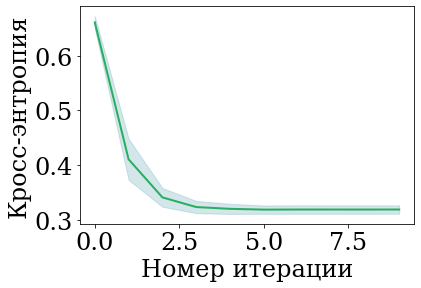

In [482]:
plt.plot(np.arange(len(mean_costs)),mean_costs, lw=2, color='#27AE60', alpha=1)
plt.fill_between(np.arange(len(mean_costs)), mean_costs-error, mean_costs+error, color='#539caf', alpha=0.25)
plt.xlabel('Номер итерации')
plt.ylabel('Кросс-энтропия')
# plt.title('Зависимость S от номера итерации')

In [218]:
costs_exp = -1*np.exp(costs)
mean_costs = costs_exp[:-1, :].mean(axis=0)
error = costs_exp[:-1, :].std(axis=0)

Text(0.5, 1.0, 'Зависимость evp(-S) от номера итерации')

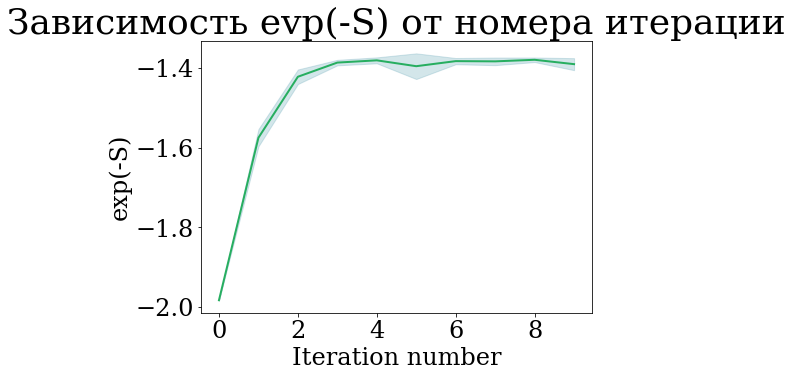

In [219]:
plt.plot(np.arange(len(mean_costs)),mean_costs, lw=2, color='#27AE60', alpha=1)
plt.fill_between(np.arange(len(mean_costs)), mean_costs-error, mean_costs+error, color='#539caf', alpha=0.25)
plt.xlabel('Iteration number')
plt.ylabel('exp(-S)')
plt.title('Зависимость evp(-S) от номера итерации')

In [170]:
# rocs[1] = rocs[0]
# rocs_val[1] = rocs_val[0]

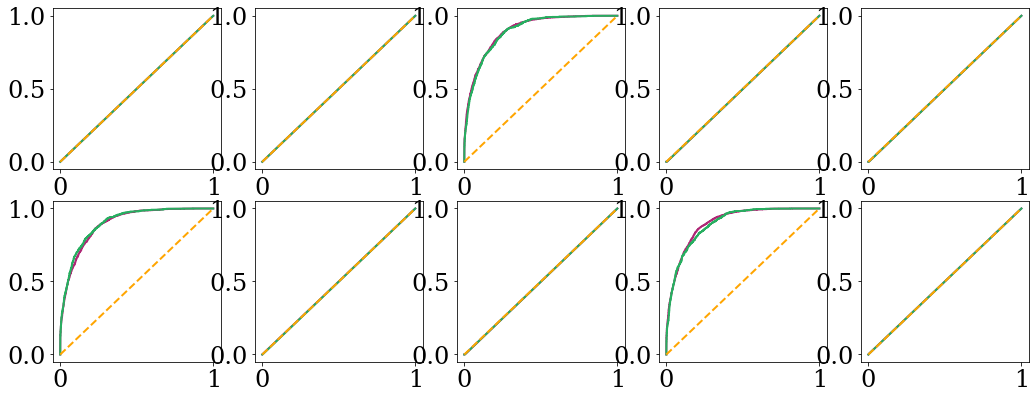

In [483]:
fig, axes = plt.subplots(2, 5, figsize=(17.5, 6.5))
for i, (a, b) in enumerate(zip(rocs, rocs_val)):
    idx = i%5
    
    fpr, tpr = a
    fpr_v, tpr_val = b
    
    axes[i//5, idx].plot(fpr, tpr, color='#AE2775', label='ROC')
    axes[i//5, idx].plot(fpr_v, tpr_val, color='#27AE60', label='ROC')
    axes[i//5, idx].plot([0, 1], [0, 1], color='orange', linestyle='--', label='Random decision line')
#     axes[idx, i//5].xlabel('False Positive Rate')
#     axes[idx, i//5].ylabel('True Positive Rate')
#     axes[i//5, idx].set_title('title')
#     axes[idx, i//5].legend()
    
#     plot_roc_cur(fpr, tpr, title='ROC-кривая на тестовой выборке')
#     plt.show()

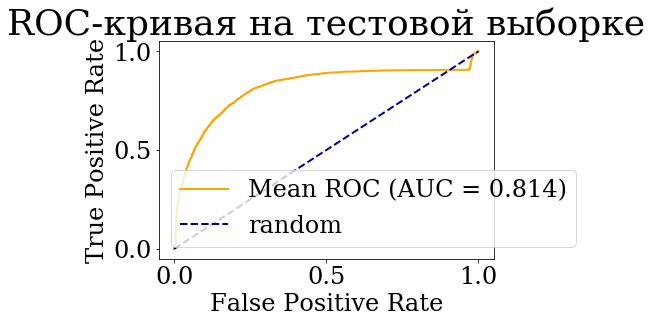

In [484]:
t_test = Y_test
t_test = t_test

preds_test = np.array(preds_test)
roc = roc_auc_score(t_test, preds_test.mean(axis=0))

fpr_test, tpr_test, thresholds_test = metrics.roc_curve(t_test, preds_test.mean(axis=0), pos_label=None)
plt.plot(fpr_test, tpr_test, color='orange', label='Mean ROC (AUC = %s)' % round(roc, 3))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на тестовой выборке')
plt.legend()

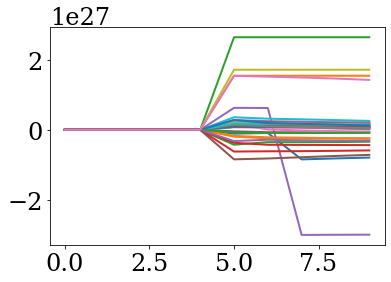

In [485]:
list_w3 = clf.list_w
for i in range(len(list_w3[0])):
    a = []
    for j in range(len(list_w3)):
        a.append(list_w3[j][i])
    plt.plot(a)
    #plt.show()

In [174]:
def var_of_w(l, i):
    res = []
    for item in l:
        if len(item) > i:
            res.append(item[i])
    return res

In [175]:
list_w3_ = list_w3_[-1]

IndexError: list index out of range

IndexError: list index out of range

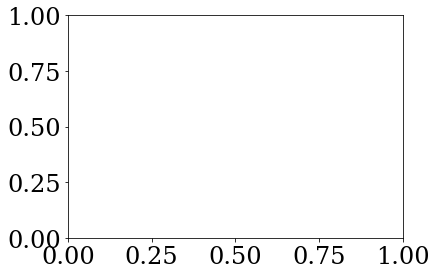

In [176]:
plt.figure(figsize=(6,9))
plt.subplot(211)
for i in range(len(list_w3_[0])):
    if len(var_of_w(list_w3_, i))<len(var_of_w(list_w3_, 0)):
        plt.plot(var_of_w(list_w3_, i), color='r')
plt.xlabel('Номер итерации')
plt.ylabel('Парамтетры модели w')
plt.title('Параметры модели w, соответствующие неинформативным признакам')
plt.subplot(212)
for i in range(len(list_w3_[0])):
    if len(var_of_w(list_w3_, i))>=len(var_of_w(list_w3_, 0)):
        plt.plot(var_of_w(list_w3_, i), color='g')
plt.xlabel('Номер итерации')
plt.ylabel('Парамтетры модели w')
plt.title('Параметры модели w, соответствующие информативным признакам')
plt.savefig('5.png')

In [177]:
list_var_w3_ = list_var_w3_[-1]

IndexError: list index out of range

IndexError: list index out of range

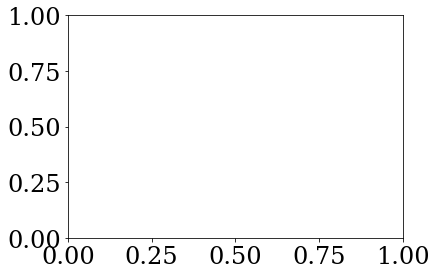

In [178]:
plt.figure(figsize=(6,9))
plt.subplot(211)
for i in range(len(list_var_w3_[0])):
    if len(var_of_w(list_var_w3_, i))<len(var_of_w(list_var_w3_, 0)):
        plt.plot(var_of_w(list_var_w3_, i), color='r')
        plt.ylim(0,15)
plt.xlabel('Номер итерации')
plt.ylabel('Элементы матрицы A')
plt.title('Элементы матрицы A, соответствующие шумовым параметрам модели w')
plt.subplot(212)
for i in range(len(list_var_w3_[0])):
    if len(var_of_w(list_var_w3_, i))>=len(var_of_w(list_var_w3_, 0)):
        plt.plot(var_of_w(list_var_w3_, i), color='g')
        plt.ylim(0,15)
plt.xlabel('Номер итерации')
plt.ylabel('Элементы матрицы A')
plt.title('Элементы матрицы A, соответствующие шумовым параметрам модели w')
plt.savefig('6.png')

In [37]:
X_ = X
T_ = T

In [43]:
%time
costs_all = []
rocs_all = []
for n_clusters in [0,2,6,10]:
    costs = []
    rocs_val = []
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X_):
    #     print('ИТЕРАЦИЯ', i)
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_val = X_[train_index], X_[test_index]
        t_train, t_val = T_[train_index], T_[test_index]
        
        clf = SuperpositionModel()

#         w = np.array([-0.03650337, -0.0107314,  -0.00234493, -0.00433932, -0.03974928, -0.02914917,
#          -0.01633966, -0.00345402, -0.03254841, -0.0266781,  -0.04509162, -0.04688906,
#          -0.00671441,  0.00415988, -0.02440513, -0.00289427, -0.0157322,  -0.03586732,
#          -0.01573701,  0.00779581, -0.02368145,  0.00832795, -0.07535983, -0.00652688,
#          -0.02122398, -0.02894507, -0.02633966, -0.04345402, -0.03254841, -0.0666781,
#          -0.0033966,  -0.079402,   -0.03254841, -0.04301776, -0.0053454,  -0.0053454,
#         -0.0013966,  0.089402,   -0.02354841, 0.02301776, -0.00893454,  -0.0013454])[:31+n_clusters]

        a = 1
        n = n_clusters+31
        n_003 = 1/n - 0.002
        b = math.sqrt(3/n)
        while (a>1/n) or (a<n_003):
#         while (a>1/n):
            vals = uniform.rvs(loc=-b, scale=0.0905, size=n, random_state=None)
            a = vals.std()
        print('Нужная дисперсия', 1/n)
        print('Дисперсия начального вектора параметров', a)
        w = vals
        clf.set_weights(w)
        
        clf.fit(X_train, t_train, feat_threshold=10*1e+20, n_clusters=n_clusters, iterations=10, algo_clust='km_simple')
        
#         w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X_train, T=t_train, iterations=10, 
#     #                                                                             obj_threshold=0.2499,
#                                                                                         obj_threshold=100000000.0, 
#                                                                                         feat_threshold=1.0*1e+20, 
#     #                                                                                     feat_threshold=9.5*1e+00,        
#                                                                                         n_clusters=n_clusters)

        pred3 = clf.predict(X_val)
        roc = roc_auc_score(t_val, pred3)
        rocs_val.append(copy.deepcopy(roc))
        
        costs.append(copy.deepcopy(clf.get_costs()[-1]))
        
    costs_all.append(costs)
    rocs_all.append(rocs_val)

Wall time: 0 ns
TRAIN: [ 2844  2845  2846 ... 28435 28436 28437] TEST: [   0    1    2 ... 2841 2842 2843]
Нужная дисперсия 0.03225806451612903
Дисперсия начального вектора параметров 0.031008181136552914
[-0.30862575 -0.23542859 -0.23896684 -0.25488757 -0.30705799 -0.22565404
 -0.30201146 -0.24598087 -0.2419568  -0.22537379 -0.22533139 -0.28585139
 -0.2900893  -0.27389054 -0.22643176 -0.24556488 -0.22855078 -0.29138963
 -0.30493055 -0.30884349 -0.30463669 -0.23496667 -0.2321574  -0.22808456
 -0.27411396 -0.26892096 -0.29384509 -0.27116335 -0.29694181 -0.25517486
 -0.30961608]

0-я итерация

Веса
[-0.30862575 -0.23542859 -0.23896684 -0.25488757 -0.30705799 -0.22565404
 -0.30201146 -0.24598087 -0.2419568  -0.22537379 -0.22533139 -0.28585139
 -0.2900893  -0.27389054 -0.22643176 -0.24556488 -0.22855078 -0.29138963
 -0.30493055 -0.30884349 -0.30463669 -0.23496667 -0.2321574  -0.22808456
 -0.27411396 -0.26892096 -0.29384509 -0.27116335 -0.29694181 -0.25517486
 -0.30961608]

Скоры объектов н

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-0.36723826  0.4976383   0.82098235  2.607361   -0.66470102  0.35483827
 -0.48244259 -0.11789699 -0.32423033  0.12554478  0.49654369 -2.92102933
 -1.92361449 -2.72009149 -2.20968191 -2.50050268 -2.58288025 -2.42964796
  1.28967414 -0.22324169  0.41513104 -0.27138622 -0.07261557 -1.21509326
 -0.63720491 -0.42745094 -1.03168902 -1.35314311  0.31780694  0.26574952
 -3.59673077]
Дисперсии весов
[ 1.84669733e+18  5.82113244e+18 -1.60420749e+17  1.27135539e+17
 -1.81392457e+18  2.44963170e+19 -2.45739313e+17 -4.10894577e+19
  5.19069380e+18 -1.28633193e+19 -5.56258247e+18  2.58712196e+16
 -1.53673185e+15  2.45723174e+17  6.70515259e+15 -1.94265171e+16
  2.14108565e+17  4.75771067e+16  4.54033348e+16 -5.37352418e+18
 -4.79135290e+18  9.13085560e+17 -1.06864068e+19 -1.63027664e+17
  2.62856043e+18  1.48630365e+18  1.51107680e+17 -9.91963608e+15
  8.72974393e+17  1.08369217e+19  3.18121974e+16]

Список выбранных на текущей ите

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.21702814  0.49079507  0.81379986  2.59253049  0.37729943 -0.49875985
 -0.09626296 -0.31197266  0.11849579  0.52574235 -2.42640953 -0.54232264
 -2.67351567 -2.23916378 -2.44152629 -2.36969491 -2.43072032  0.98031685
 -0.25323205  0.42239432 -0.27577037 -0.0457142  -1.09308616 -0.61268355
 -0.3976444  -1.12379323 -1.33171766  0.27438027 -2.62270131]
Дисперсии весов
[-6.66605378e+17  3.06295741e+17  1.85393272e+16  2.96901240e+16
  2.09098558e+17 -1.37746808e+17  1.18180130e+18  5.74993725e+17
 -2.71635559e+18  2.83950362e+17  9.08448055e+15  1.04045152e+17
 -2.06948379e+15 -5.35616815e+15 -6.00991367e+15  3.49383133e+15
  2.24324551e+16 -8.89375104e+15 -5.98242313e+17 -7.60331688e+16
 -2.89326368e+17 -1.19898559e+19  2.30280641e+16 -2.26162500e+16
  4.15329649e+16 -5.87896786e+15  3.84027553e+16 -1.73325966e+17
  2.29714835e+16]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '5', '6', '7', '8', 

Недостаточно итераций для сходимости алгоритма.

1-я итерация

Веса
[-0.07402965  0.21681768  0.40852318  2.14974784 -0.25203459  0.16259467
 -0.25986906 -0.0679409  -0.21814365  0.57644118  0.40034227 -1.0022661
  0.10417563 -1.26488248 -1.43538086 -1.3496635  -1.56225773 -1.31728552
  0.50312894 -0.30569185  0.38469898 -0.28526464 -0.05355371 -0.25834097
 -0.44222615 -0.41060703 -0.34964425 -0.71744041 -0.00393503  0.08413307
 -0.29234912]
Дисперсии весов
[ 4.40011322e+20  3.85894770e+16 -1.31323280e+18  4.75998249e+15
  4.52845407e+17 -2.23760331e+19 -3.41904528e+18 -3.10683816e+19
  3.85786995e+18 -5.75914912e+18  3.97760772e+17 -7.71693734e+17
  1.02025240e+18  6.61808947e+16 -1.88501084e+16  6.80972185e+16
 -1.21532846e+16  2.91622900e+17 -1.45897212e+17  1.30785371e+18
  1.20130708e+17  5.70219993e+18 -6.75765672e+19 -6.65432274e+17
  1.24913289e+18  4.21082181e+16 -9.42167219e+17 -1.36027465e+18
  2.36922996e+22  1.80309326e+19 -5.18021695e+17]

Список выбранных на текущей итер

Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-0.16240939  0.5033977   0.78440687  2.62714352 -0.13571769  0.36934511
 -0.52256251 -0.15055574 -0.34877531  0.15066747  0.54904448 -2.94133543
 -1.97215773 -2.69767043 -2.22056753 -2.50768679 -2.50852614 -2.33661731
  0.96942481 -0.31789237  0.3639682  -0.35994081 -0.15315446 -1.25476686
 -0.71225982 -0.51748428 -1.12332983 -1.43106421  0.2002306  -3.69063446]
Дисперсии весов
[ 1.24228627e+18  1.89964484e+18  4.11437298e+17 -1.78297921e+17
  1.31512053e+19  4.02292996e+17  9.01964453e+17  2.09110262e+18
  9.93039790e+16  5.50834671e+18 -1.19237581e+17  6.18102403e+16
  2.31914276e+16  1.29072273e+16  2.10542700e+16  7.87093032e+15
 -2.69554070e+16 -8.79262639e+14 -3.92412977e+17 -2.04432488e+18
  1.54782580e+18 -7.51742178e+17 -1.27719563e+19 -3.01551102e+16
 -2.08927630e+17  1.86733239e+17 -7.98401840e+16 -1.88043803e+16
  2.76523622e+18 -5.12077240e+15]

Список выбранных на текущей итерации признаков
['0', '1', '2

Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.1746966   0.49669914  0.81264151  2.62701569 -0.02158917  0.36881008
 -0.51859684 -0.14654994 -0.24004034  0.1571206   0.55855416 -2.65585813
 -1.24578075 -2.71601692 -2.26281665 -2.51609346 -2.5030943  -2.50743391
  0.74544644 -0.29582792  0.40584947 -0.36516419 -0.08400548 -1.18315897
 -0.67851135 -0.48249202 -1.08890763 -1.46421052  0.2565701  -3.37696721]
Дисперсии весов
[ 5.01379761e+17  1.29097364e+18  5.86052550e+16  6.10487115e+16
 -1.78552109e+20  1.22548674e+18 -7.89931983e+16  4.01950555e+18
 -4.31087495e+17 -1.39600779e+19 -3.55889563e+17 -4.23945983e+15
 -2.17544411e+16 -2.90297676e+16  5.79126489e+17  2.17592325e+17
  3.82659159e+15 -2.71027959e+16 -1.31451932e+17 -1.43463410e+18
 -7.13856296e+16  4.69179036e+16  4.65081051e+19  6.03746750e+15
  8.37612640e+16  1.32832712e+17  7.89180511e+16  1.90054271e+16
 -9.10504163e+17  2.39549505e+15]

Список выбранных на текущей итерации признаков
['0', '1', '2

Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.25504622  0.35584774  0.637815    2.29972047 -0.28178173  0.2514694
 -0.41819908 -0.11689819 -0.2898271   0.25820126  0.49562821 -1.29766607
  0.50861372 -1.9371489  -1.92536045 -1.96369171 -2.05459401 -1.95754697
  0.54462154 -0.25081874  0.40630744 -0.27349113 -0.01234702 -0.52963239
 -0.55563274 -0.37532762 -0.61674646 -1.00413792  0.21997268  0.21924073
 -0.71866164]
Дисперсии весов
[-1.10851301e+18 -1.01969397e+18 -6.21918620e+16 -3.11988192e+16
  2.54567059e+17 -1.04864659e+18  1.61351031e+17  2.62303085e+19
 -1.88172023e+18  1.12776867e+17  1.57181383e+17  1.22320007e+17
 -3.04518085e+17 -3.54958782e+16  4.98929263e+16 -1.81693230e+16
 -1.12048504e+16 -4.73922302e+15  8.71476781e+16  8.34463056e+17
  2.76479994e+17 -7.63274066e+16  2.45647903e+19  6.20619703e+16
  1.46469011e+17 -1.59233752e+17  2.86998062e+17 -2.27320372e+16
 -1.26878069e+18  2.70679849e+17 -2.11988800e+16]

Список выбранных на текущей итер


Алгоритм сошелся за 9 итераций

9-я итерация

Веса
[-0.32230772  0.49056471  0.81138958  2.60905078 -0.42365966  0.35762047
 -0.51188234 -0.14386347 -0.33462466  0.15075305  0.5672369  -2.88553585
 -1.91234707 -2.74738548 -2.24085654 -2.47823317 -2.40504989 -2.44651723
  0.61199885 -0.21694129  0.44883692 -0.2729516  -0.02919691 -1.09925424
 -0.61854328 -0.37937079 -1.02850315 -1.27841149  0.35294059  0.27910264
 -3.48177009]
Дисперсии весов
[-5.05905654e+15 -1.26643345e+17 -1.75302956e+16 -1.84088705e+16
 -4.16252823e+17 -3.09009927e+17  2.40998213e+17 -5.01048316e+17
  9.34182971e+17 -4.70125582e+17 -5.03128397e+16  3.74626639e+16
 -6.89909225e+15 -1.48100440e+16  1.17597916e+16  8.06108502e+15
  1.57347070e+15 -1.29415935e+16  7.99276911e+16  1.24200542e+18
 -1.77064247e+17  7.94539655e+16 -1.24579682e+20 -2.53097528e+16
 -4.20848850e+16 -3.78405868e+17  1.99573802e+15  2.04646232e+16
  8.15900230e+17  2.11477957e+18  4.60710003e+15]

Список выбранных на текущей итерации признаков


Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.14347184  0.49920128  0.79285269  2.57123004  0.08156642  0.37430976
 -0.49068919 -0.10769861 -0.23571301  0.12438129  0.5448813  -2.76375148
 -1.81322558 -2.69978213 -2.22172595 -2.45803751 -2.4302955  -2.42896845
  0.52615955 -0.31165558  0.37743783 -0.39052715 -0.11516415 -1.24974518
 -0.67720605 -0.51716522 -1.0488214  -1.44190136  0.21136193 -3.46507788]
Дисперсии весов
[ 2.22136257e+18  2.49307069e+17  1.59335670e+17 -2.28738223e+16
 -5.59912032e+18  6.92407686e+16 -4.92432686e+17  2.87988108e+18
 -1.89542390e+18  1.42578291e+17  1.00217098e+16  1.08013701e+15
 -4.70564018e+16 -8.03263548e+15 -1.16060337e+16 -1.18330975e+16
 -3.87990025e+15  3.95034079e+14 -6.74452273e+16  2.25490207e+17
 -8.80218211e+15  2.40909162e+16  1.67529673e+18 -5.84366529e+15
  2.33749681e+17  1.78076718e+17 -3.13183380e+16 -2.42130618e+16
 -2.65387835e+17  1.20923309e+15]

Список выбранных на текущей итерации признаков
['0', '1', '2

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.26084385  0.46454179  0.75740104  2.51274674 -0.10041815  0.32688632
 -0.44223026 -0.10521766 -0.30277151  0.18091709  0.49916412 -1.38155225
  0.21554227 -2.44571822 -2.14030523 -2.31193497 -2.39313865 -2.26211566
  0.86864805 -0.20748075  0.43091447 -0.27211188 -0.0539997  -0.92075559
 -0.56418696 -0.40695782 -0.91214881 -1.34093052  0.30997074  0.26724947
 -1.66948288]
Дисперсии весов
[ 6.59779042e+17 -5.06028741e+17 -5.07719090e+17  3.89351840e+16
 -3.98674647e+19 -5.04416247e+17  7.70741028e+17  6.91521808e+18
  3.28998797e+18 -5.73834491e+18 -1.87141077e+17  7.39528046e+17
 -3.20474025e+18 -1.28060863e+16  2.08186847e+16  5.67645190e+15
 -2.33047599e+16 -2.70320761e+15 -5.47563868e+17  3.16692213e+18
 -2.03485442e+18 -8.81580577e+18 -2.14646299e+20  4.71901653e+17
  3.96280230e+17  2.94977688e+18 -1.01496944e+18  1.66474326e+16
  2.72742954e+18  1.22782241e+19  2.78086171e+16]

Список выбранных на текущей ите


Алгоритм сошелся за 9 итераций
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [19908 19909 19910 ... 22749 22750 22751]
Нужная дисперсия 0.03225806451612903
Дисперсия начального вектора параметров 0.03082879230568055
[-0.25471566 -0.30414929 -0.25084892 -0.22072952 -0.24312567 -0.27277524
 -0.22252176 -0.22865074 -0.24077108 -0.22682217 -0.24115005 -0.22266826
 -0.24245498 -0.29766421 -0.3020974  -0.28880318 -0.29864423 -0.2599955
 -0.25128845 -0.2997737  -0.31044937 -0.2479933  -0.30654742 -0.24580688
 -0.30470388 -0.22389945 -0.28850008 -0.30497581 -0.25479257 -0.24568568
 -0.22745014]

0-я итерация

Веса
[-0.25471566 -0.30414929 -0.25084892 -0.22072952 -0.24312567 -0.27277524
 -0.22252176 -0.22865074 -0.24077108 -0.22682217 -0.24115005 -0.22266826
 -0.24245498 -0.29766421 -0.3020974  -0.28880318 -0.29864423 -0.2599955
 -0.25128845 -0.2997737  -0.31044937 -0.2479933  -0.30654742 -0.24580688
 -0.30470388 -0.22389945 -0.28850008 -0.30497581 -0.25479257 -0.24568568
 -0.22745014

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-0.25121118  0.49685361  0.79955172  2.59262099 -0.13347587  0.35775765
 -0.47242552 -0.09205663 -0.34595451  0.20528093  0.55023627 -2.6204211
 -1.8258389  -2.6907501  -2.25547573 -2.43133801 -2.44579015 -2.31495116
  0.93524444 -0.26248059  0.43922443 -0.29647704 -0.11246153 -1.12199669
 -0.6489477  -0.4290951  -1.05125698 -1.38418393  0.26845784  0.30565288
 -3.34966201]
Дисперсии весов
[ 2.78547341e+17  5.23760384e+17  1.81087839e+17  6.58103859e+15
 -4.58610965e+17 -2.81525853e+17 -3.79362088e+17  1.35181871e+18
  6.08163281e+17 -7.44765244e+17  2.87947215e+17 -1.26693696e+16
  1.50668223e+16 -1.51974159e+16  1.96821004e+15  5.26457524e+16
 -1.54047405e+15 -1.24299108e+16 -6.04526143e+16 -3.76331959e+17
  1.32728981e+17  6.48465840e+16  5.99882994e+17  3.38492084e+16
  1.74487705e+17 -1.75530965e+16 -9.97666334e+16  4.91318957e+16
  1.02683437e+18  2.95191360e+17  6.11500277e+15]

Список выбранных на текущей итер

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.24344113  0.49041827  0.80970813  2.6177984  -0.06455042  0.35140586
 -0.46465314 -0.11841346 -0.30352352  0.13462625  0.51722101 -2.39156916
 -0.51798142 -2.66024122 -2.20908019 -2.41257215 -2.31773216 -2.46136412
  1.0713666  -0.22285989  0.4447854  -0.32476032 -0.04305387 -1.0797836
 -0.62916149 -0.4072303  -1.02632816 -1.33072548  0.26084676  0.24915625
 -2.64068567]
Дисперсии весов
[-4.41641001e+18  6.75238866e+16 -8.26643256e+15  1.87965160e+16
  1.22722872e+19  2.97215830e+17 -2.72511793e+17  2.24708531e+18
 -1.35541365e+18 -1.37464801e+18  1.20096242e+17  1.22185345e+16
 -1.63051332e+17  6.21995568e+15  1.88521655e+16 -3.30838730e+15
  1.42150702e+15  1.53616645e+15 -4.14836207e+16  9.90271582e+17
  2.55878666e+17 -5.97236296e+17 -4.74223723e+19 -6.21423597e+16
 -2.30387682e+17 -3.86767217e+16  3.32051932e+16  1.77373801e+15
 -2.65950032e+17  8.92054064e+17 -8.88729374e+15]

Список выбранных на текущей итер

Недостаточно итераций для сходимости алгоритма.

1-я итерация

Веса
[-0.11044501  0.20605418  0.39753682  1.99671581 -0.23765047  0.13659318
 -0.24311444 -0.06861502 -0.19111091  0.47364431  0.34678343 -0.68481787
  0.50210431 -1.25489358 -1.43405922 -1.33806538 -1.58388564 -1.34963071
  0.25354176 -0.28317145  0.3363164  -0.27728436 -0.0442699  -0.27482541
 -0.44061945 -0.36514434 -0.33069893 -0.70236811  0.04852307  0.09240901
 -0.31390862]
Дисперсии весов
[ 1.19551310e+19 -6.96971330e+17 -1.76214498e+17  7.93181990e+15
  1.48448730e+18  1.38780828e+17 -1.80460656e+17 -2.85529255e+19
  6.04117522e+17  4.02974007e+17 -3.17059678e+16  4.16908507e+17
 -2.03156611e+17  1.09591905e+17 -8.91709537e+15 -6.67491616e+15
  1.42466801e+15  3.47442347e+16 -3.37925006e+17 -1.03211607e+18
  2.33516100e+16  2.24887992e+17  1.55094127e+19  7.75622033e+17
 -5.21385140e+17 -1.09880962e+17  1.16322115e+18 -3.49983287e+16
 -7.97172781e+17  6.07778469e+18  1.56327133e+17]

Список выбранных на текущей ите

Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-0.2277075   0.51003201  0.8124512   2.5625842  -0.0727068   0.36735405
 -0.47775084 -0.11134496 -0.29913777  0.11085104  0.50942388 -2.74276455
 -1.26771859 -2.68792383 -2.27854056 -2.4050052  -2.62293226 -2.48885105
  0.60209054 -0.22958207  0.40705774 -0.30491491 -0.08207092 -1.19244297
 -0.65627484 -0.39481215 -1.04993051 -1.39781729  0.34343999  0.24697475
 -3.56129814]
Дисперсии весов
[ 1.49025383e+18 -3.08118206e+17 -7.11723445e+16  3.54342343e+15
 -7.81151981e+18 -2.96245663e+17 -2.91758416e+17 -2.69870532e+18
 -6.46876296e+17  1.98190810e+18  7.94881638e+14 -3.84753693e+15
  8.94514801e+16 -4.71044159e+15  2.28956296e+15 -9.92999650e+15
 -1.13913474e+16  8.57816658e+14 -3.46049141e+16  1.27089506e+17
 -1.66232657e+17  2.70215212e+17 -4.48886953e+18  3.08031817e+15
  4.91835703e+15 -2.77785977e+17  2.78003866e+16 -3.42027448e+16
 -7.70742759e+16  4.66329861e+17 -2.73351803e+15]

Список выбранных на текущей ите

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.60682576  0.01178065  0.49996124  2.61756222 -0.39708722  0.4710191
 -0.26474332 -0.03101376 -0.19651367  0.30803285  0.55515461 -1.83926107
 -0.27373451 -2.24156215 -2.21959694 -2.30668038 -2.30796487 -2.1995226
  1.49047711 -0.21351117  0.31641815 -0.25105722 -0.02773222 -1.02973771
 -0.58658514 -0.32056765 -0.8957244  -1.19707486  0.32661273  0.32030869
 -2.27773421 -0.73986412  0.48983542]
Дисперсии весов
[ 6.58617368e+16  3.19536601e+21  1.14139094e+17  7.61045411e+15
  1.28992095e+17 -3.09857150e+17 -3.23217265e+18  1.20790220e+19
 -2.33607278e+18  7.19734833e+17  9.54602690e+16  2.20398675e+16
 -2.29881600e+17  1.25460715e+16 -2.25715939e+16  3.08088629e+16
  1.13659240e+16  1.94898343e+16 -4.78466573e+15 -1.02579545e+18
 -7.89514540e+17 -4.99048462e+16 -7.81078236e+19  6.53679086e+16
 -3.01885189e+17 -4.66551403e+17 -1.74606578e+17  3.83856183e+15
 -2.92719610e+17  3.67372000e+17  2.66533241e+15 -1.07153212


Алгоритм сошелся за 9 итераций
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [2844 2845 2846 ... 5685 5686 5687]
Нужная дисперсия 0.030303030303030304
Дисперсия начального вектора параметров 0.029510246289907536
[-0.25213303 -0.21630878 -0.26656906 -0.2145236  -0.21957711 -0.28379225
 -0.29523415 -0.29239094 -0.29986227 -0.29296426 -0.23969923 -0.29506877
 -0.27264405 -0.22505013 -0.29940523 -0.22780195 -0.27600349 -0.29081743
 -0.23845663 -0.24459202 -0.22210013 -0.23498742 -0.22879632 -0.27598722
 -0.28545307 -0.23358071 -0.2284928  -0.21187063 -0.26416944 -0.26784371
 -0.23124597 -0.27066862 -0.21727781]

0-я итерация

Веса
[-0.25213303 -0.21630878 -0.26656906 -0.2145236  -0.21957711 -0.28379225
 -0.29523415 -0.29239094 -0.29986227 -0.29296426 -0.23969923 -0.29506877
 -0.27264405 -0.22505013 -0.29940523 -0.22780195 -0.27600349 -0.29081743
 -0.23845663 -0.24459202 -0.22210013 -0.23498742 -0.22879632 -0.27598722
 -0.28545307 -0.23358071 -0.2284928  -0.21187063 -0.26416944 -0

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.47102824  0.61682843  0.91719569  2.73415309  0.22161233  0.29575207
 -0.29725707  0.05233249 -0.1408729   0.28002327  0.64435928 -2.54637184
 -1.67979138 -2.51134436 -2.14340598 -2.29507634 -2.15737491 -2.25061983
  1.38188904 -0.189349    0.4910876  -0.17108165 -0.93020274 -0.49939677
 -0.24596229 -0.9741167  -1.10471548  0.42037938 -3.1947336  -0.26748748
 -0.18946265]
Дисперсии весов
[-2.68836602e+17  2.13640693e+17 -6.37092299e+16 -1.80499481e+16
  5.80712069e+17  2.13467837e+17  3.63256877e+17  6.27537232e+19
  4.33959214e+18  1.03612709e+18  2.11468688e+17  1.94267693e+16
  7.94034550e+15 -1.89315571e+16 -7.33764329e+15  2.47319607e+15
  1.55724473e+16  7.12178765e+15  3.49404292e+16 -5.96268019e+16
  7.50290203e+16 -1.98174948e+17 -6.73429635e+16  1.14982067e+17
  1.91334879e+18 -5.98574097e+16  1.22715412e+16  3.61556490e+17
  1.82423820e+16 -2.91292209e+17 -2.29010639e+17]

Список выбранных на текущей ите

Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.25212204  0.37291734  0.65339071  2.34214954 -0.06588365  0.03316919
 -0.36100775 -0.0657419  -0.23876914  0.31650775  0.50285303 -1.17501539
  0.5293706  -1.80338051 -1.861036   -1.87299506 -2.02610827 -1.78948131
  0.93841787 -0.3071657   0.33495102 -0.29199288 -0.08368895 -0.56311539
 -0.58235656 -0.45514033 -0.63820751 -1.05594873  0.16049732  0.20723164
 -0.79868705 -0.31537692  0.03299978]
Дисперсии весов
[-5.19770394e+17  4.08312771e+17  1.27744913e+17  5.31207249e+15
 -4.78217019e+18 -7.18102386e+19  1.13221107e+17  3.67669218e+18
  6.10605592e+17  3.15121224e+17  7.83289157e+16 -3.05125087e+16
  3.47632557e+15  4.20903337e+15  1.21019503e+16 -1.87441640e+16
  4.34373906e+15 -1.49962680e+16 -6.56262591e+15 -1.17118578e+17
 -7.73386676e+16 -2.23797279e+17 -2.49131770e+18 -1.28465383e+17
  1.17978551e+17  5.01441114e+16 -8.09008646e+16  1.43402926e+16
  2.24354729e+18 -7.23675449e+17 -1.57631250e+15 -4.304085

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-0.38480503  0.60675417  0.86708486  2.73528416  0.04414455  0.25296551
 -0.33781187 -0.0246537  -0.20348489  0.31155683  0.6341726  -2.56773657
 -1.72868312 -2.51810086 -2.1292223  -2.35725687 -2.30148728 -2.15589629
  1.31039069 -0.29223446  0.39238078 -0.28575365 -0.09394554 -1.11576209
 -0.64414385 -0.41632726 -1.0040521  -1.26276908  0.29233241  0.29761299
 -3.37257925 -0.28285615 -0.14355766]
Дисперсии весов
[-3.15476648e+17  1.91906069e+17  6.24950831e+16  3.08642760e+14
  1.55461394e+19  1.73221638e+18 -1.35012051e+18 -1.67873611e+17
 -2.81885155e+18  6.42830221e+17 -1.23950310e+17  6.68719642e+15
 -5.32474852e+15  3.02031836e+15 -1.73147431e+15  1.12103558e+16
  3.75726764e+16  1.80067546e+15 -1.37984783e+16 -1.79831414e+18
 -4.52950683e+17  8.40021080e+17 -8.62611770e+17  8.08107430e+16
  4.41350752e+16  9.32926797e+16 -7.29782928e+16  2.71760156e+15
 -4.99611509e+16  9.93244269e+15  1.38085372e+15 -5.614312

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.35235085  0.56004897  0.84864322  2.62249075  0.16781731  0.24912311
 -0.32413613 -0.03688583 -0.10593759  0.31398219  0.61202442 -1.60705831
  0.13254615 -2.29147216 -2.10390221 -2.22589645 -2.23435188 -2.20770568
  1.09077164 -0.29007389  0.40332821 -0.30726196 -0.03789526 -0.86593498
 -0.61248117 -0.40310596 -0.85942622 -1.25402407  0.34124332 -1.62510898
 -0.25821907 -0.14622239]
Дисперсии весов
[ 1.27695936e+18  1.12988421e+16 -4.36412163e+16  3.92710483e+15
  2.32493429e+18 -2.16224871e+18 -1.69840402e+18 -9.26378846e+19
 -4.26932557e+18  5.55015248e+17 -3.05160055e+17 -7.55854851e+16
 -7.46590869e+18 -9.01859266e+16  2.48035379e+16  4.27392472e+16
  2.99528757e+15 -6.14498341e+15  7.20669495e+16 -3.10373033e+17
  3.84572639e+17 -2.51973064e+18  9.29306407e+19  1.65454037e+17
  7.00715678e+17 -3.07818053e+17  3.74384827e+16 -6.15423960e+16
  6.19426154e+17 -5.81287606e+16  2.12232980e+17  5.85644918e+18]

Спи


Алгоритм сошелся за 9 итераций

9-я итерация

Веса
[-0.37708792  0.61099982  0.8976411   2.74686322  0.15364304  0.28515065
 -0.32285372 -0.02527013 -0.09343551  0.31476825  0.65024827 -2.59761445
 -1.6846754  -2.54106181 -2.17428478 -2.3678289  -2.30478857 -2.33762672
  1.12282011 -0.29147529  0.41548345 -0.31518766 -0.04402735 -1.05736201
 -0.63246451 -0.40283677 -0.98876201 -1.30640023  0.35375684 -3.37671704
 -0.2572558  -0.17467847]
Дисперсии весов
[ 5.27091446e+17 -5.16964459e+16  1.39242182e+16 -1.78417428e+16
 -1.73592224e+18  3.55559238e+17 -1.28364091e+18  5.95150180e+18
 -1.10357839e+19 -1.03396743e+17 -5.93150524e+16 -1.19341977e+16
  5.38628617e+15  5.45192293e+15  1.53773977e+16  2.73340467e+15
  1.19455979e+16  1.19539572e+16  2.08550051e+16 -4.86963798e+16
 -2.27049038e+17  1.06826287e+18 -8.93572655e+18  9.07063603e+16
  5.36562491e+17 -4.45951321e+16 -2.26567946e+16 -1.07301866e+17
  4.38517592e+17  4.61064620e+15 -2.03751914e+18  1.37670360e+18]

Список выбранных на

Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.49358433  0.60638193  0.89328979  2.72548761 -0.19173133  0.28447489
 -0.3194099  -0.02632548 -0.19141192  0.32601835  0.66174785 -2.30457114
 -1.15493273 -2.57092999 -2.14960757 -2.33558894 -2.19506815 -2.25587322
  1.02202024 -0.23937331  0.436339   -0.24290074 -0.01567027 -0.99726473
 -0.59746591 -0.31556929 -0.95005138 -1.14410461  0.39825319  0.35049674
 -3.09312883 -0.24801153 -0.17943886]
Дисперсии весов
[-1.33285599e+17 -8.22812194e+16  4.26144488e+16  2.32619610e+15
  7.48196033e+17  3.07951120e+17 -2.28953999e+17 -6.23448267e+19
  9.30873232e+17  1.07210323e+18  5.87310004e+16  3.05661703e+16
  1.43035244e+16 -5.25713413e+15 -3.30818374e+15  6.14134979e+15
  5.86266591e+15  8.98174506e+15 -7.42050904e+13  1.29082348e+18
 -4.20382483e+17  2.19353955e+17  2.64001564e+19  1.87416833e+16
 -1.11222572e+17  2.47414712e+17  6.72425249e+16  7.28642533e+15
  3.84628525e+17 -1.67582891e+17 -4.73189223e+15 -6.990082


Алгоритм сошелся за 9 итераций
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [14220 14221 14222 ... 17061 17062 17063]
Нужная дисперсия 0.030303030303030304
Дисперсия начального вектора параметров 0.029510246289907536
[-0.25213303 -0.21630878 -0.26656906 -0.2145236  -0.21957711 -0.28379225
 -0.29523415 -0.29239094 -0.29986227 -0.29296426 -0.23969923 -0.29506877
 -0.27264405 -0.22505013 -0.29940523 -0.22780195 -0.27600349 -0.29081743
 -0.23845663 -0.24459202 -0.22210013 -0.23498742 -0.22879632 -0.27598722
 -0.28545307 -0.23358071 -0.2284928  -0.21187063 -0.26416944 -0.26784371
 -0.23124597 -0.27066862 -0.21727781]

0-я итерация

Веса
[-0.25213303 -0.21630878 -0.26656906 -0.2145236  -0.21957711 -0.28379225
 -0.29523415 -0.29239094 -0.29986227 -0.29296426 -0.23969923 -0.29506877
 -0.27264405 -0.22505013 -0.29940523 -0.22780195 -0.27600349 -0.29081743
 -0.23845663 -0.24459202 -0.22210013 -0.23498742 -0.22879632 -0.27598722
 -0.28545307 -0.23358071 -0.2284928  -0.21187063 -0.26416

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.44048157  0.62952646  0.88743273  2.69138553  0.28143686  0.36256779
 -0.29280455 -0.04631792  0.29151108  0.65285917 -2.45312789 -1.71115484
 -2.52210758 -2.13178662 -2.30084872 -2.2319538  -2.22766265  0.94405614
 -0.19275969  0.49786804 -0.24274877 -1.02194385 -0.51247779 -0.31287592
 -0.83184734 -1.16589323  0.40955783  0.34421041 -3.11985004 -0.1818064
 -0.21446867]
Дисперсии весов
[ 6.45632204e+17 -5.88227035e+17 -1.93696071e+17 -4.68703442e+15
  2.58585966e+18  1.35944071e+18  4.08028923e+18  2.47778039e+20
 -1.90249215e+18  2.11490326e+17 -5.19003644e+15  2.08577831e+17
  1.42057180e+16  3.56726989e+16  1.54155798e+16  3.26844358e+16
 -2.29468518e+16  3.06326792e+16 -4.44009133e+18 -2.02320257e+18
  2.22420704e+17 -5.68423547e+16 -6.26525410e+17 -8.09682184e+17
 -1.70879445e+17 -1.12944311e+16 -3.42583877e+17 -4.53219405e+17
 -1.05198662e+17  4.82851806e+18 -1.76434401e+19]

Список выбранных на текущей итер

Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.37372189  0.45203954  0.67449949  2.30745023 -0.03543148  0.27471432
 -0.25263037 -0.0386226  -0.20544771  0.32094617  0.4856815  -0.77951033
  0.36367523 -1.76273767 -1.77584167 -1.78033467 -1.99165499 -1.76008887
  1.03046459 -0.24534336  0.36653749 -0.24727077 -0.05244911 -0.54233552
 -0.48186855 -0.35888385 -0.57283016 -1.01931956  0.23111194  0.27140558
 -0.82661551 -0.17235544 -0.17638755]
Дисперсии весов
[-1.27309204e+18 -4.73954316e+16 -5.56586583e+16  1.65543083e+16
  6.27605239e+19  9.74652848e+17 -1.06038024e+18  6.03905466e+17
  3.47652731e+17 -3.91208633e+16  2.38059432e+17  1.76223468e+17
 -1.32063569e+17 -2.70534076e+16 -1.82672388e+16  4.68229419e+15
  5.33373094e+15 -1.80117514e+16 -2.16778993e+16  5.43021581e+17
  1.24696730e+17 -9.79167320e+17 -1.97446566e+19  2.81883145e+15
 -3.08681976e+17 -3.21164666e+17 -7.76490234e+16 -4.10127749e+16
  7.15998507e+17  4.27345909e+17 -2.45361962e+17  2.893866

Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-0.46208344  0.62384595  0.86989955  2.73247627  0.06100565  0.32925975
 -0.2466273  -0.13893205  0.33801947  0.63703579 -2.35253835 -1.83606757
 -2.53567484 -2.11303262 -2.29865173 -2.28661563 -2.21269605  1.26349595
 -0.219893    0.44043244 -0.24497776 -0.03348236 -1.04575186 -0.54115017
 -0.34198939 -0.95872042 -1.25656492  0.38313438  0.29319759 -3.27571736
 -0.20408375 -0.21617866]
Дисперсии весов
[ 3.13824521e+17  6.33025338e+16 -7.48833510e+16 -2.43570053e+16
 -1.90074124e+18  1.29649189e+18  1.48621696e+18  4.93746338e+18
  3.92606229e+17 -5.36189515e+17 -9.81270942e+15 -3.08439159e+16
  1.16028236e+16 -1.41458801e+16  8.86418606e+15 -4.71434594e+15
  8.56384316e+15 -6.08302435e+16 -3.11499064e+17  3.54867591e+16
 -7.22607887e+16  8.05524953e+19  6.10003958e+15 -6.32402711e+17
  1.75959967e+17  3.04327682e+16 -4.57324299e+14  6.90871339e+17
  1.99771517e+17  4.97919635e+15  1.33390289e+18 -3.31550571e+17]

Спи

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.40077936  0.64934647  0.85495898  2.70425513  0.09778949  0.52542017
 -0.23964243 -0.18670745  0.39996708  0.66301353 -1.75585715 -0.7195741
 -2.50362675 -2.16617811 -2.27156669 -2.23851866 -2.12673053  1.32356862
 -0.29767188  0.44350322 -0.30453635 -0.08235406 -1.02721901 -0.64530288
 -0.36116333 -0.98227548 -1.24036182  0.30423847 -2.30429656 -0.3308408 ]
Дисперсии весов
[-6.62054404e+17  1.50217741e+17  4.87123005e+16  1.86506631e+16
  6.46773739e+18  1.97732293e+18 -4.81685497e+17  1.73113812e+18
 -2.16429851e+17  1.14020856e+17 -4.80201481e+16  3.50789892e+17
  2.86682105e+16 -6.28335780e+15 -2.19943507e+16  2.49072218e+16
 -2.89389112e+16  4.47744683e+16 -1.48681278e+18  3.36649645e+17
 -8.55396362e+17 -2.06961638e+19 -3.89712513e+16  3.45637990e+16
 -2.44036567e+18 -6.69501154e+16  2.08067973e+16  2.76476461e+17
  3.64440984e+15  1.35802389e+18]

Список выбранных на текущей итерации признаков
['0', '1', '2'


Алгоритм сошелся за 8 итераций
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [22752 22753 22754 ... 25592 25593 25594]
Нужная дисперсия 0.030303030303030304
Дисперсия начального вектора параметров 0.029510246289907536
[-0.25213303 -0.21630878 -0.26656906 -0.2145236  -0.21957711 -0.28379225
 -0.29523415 -0.29239094 -0.29986227 -0.29296426 -0.23969923 -0.29506877
 -0.27264405 -0.22505013 -0.29940523 -0.22780195 -0.27600349 -0.29081743
 -0.23845663 -0.24459202 -0.22210013 -0.23498742 -0.22879632 -0.27598722
 -0.28545307 -0.23358071 -0.2284928  -0.21187063 -0.26416944 -0.26784371
 -0.23124597 -0.27066862 -0.21727781]

0-я итерация

Веса
[-0.25213303 -0.21630878 -0.26656906 -0.2145236  -0.21957711 -0.28379225
 -0.29523415 -0.29239094 -0.29986227 -0.29296426 -0.23969923 -0.29506877
 -0.27264405 -0.22505013 -0.29940523 -0.22780195 -0.27600349 -0.29081743
 -0.23845663 -0.24459202 -0.22210013 -0.23498742 -0.22879632 -0.27598722
 -0.28545307 -0.23358071 -0.2284928  -0.21187063 -0.26416

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.40120538  0.60184379  0.88554602  2.75344946  0.12380373  0.24512615
 -0.2631581  -0.1324321   0.30802435  0.63872194 -2.58076022 -2.50636949
 -2.12620846 -2.27737282 -2.11271137 -2.29283342  1.4690948  -0.26316565
  0.4158008  -0.31748897 -0.04432758 -1.02964038 -0.6285086  -0.37205565
 -0.9803186  -1.21654662  0.23021899 -3.30770642 -0.28070943 -0.16690017]
Дисперсии весов
[-6.98192180e+17  5.92062594e+16 -1.29101725e+17  3.92206177e+16
 -8.55512444e+18  8.21141091e+17 -6.55948133e+18  2.80698149e+19
  3.53533593e+18 -1.54984900e+18 -1.30623025e+16 -4.08246851e+15
  3.80826536e+16  4.55427731e+16 -7.71667182e+15  2.96258510e+15
 -1.66010004e+17  9.33571250e+17  1.77910419e+17  2.19693995e+18
 -1.48891358e+20  1.06464230e+17  5.57755578e+17  5.25529905e+18
  6.68445711e+16  2.46589822e+17 -1.59197622e+18 -1.43029482e+16
  3.80836084e+18  9.74222063e+17]

Список выбранных на текущей итерации признаков
['0', '1', '2

Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.35955428  0.47478311  0.6873252   2.21985221  0.0104642   0.34107362
 -0.25689501 -0.04830628 -0.19147845  0.27969241  0.46168641 -1.01574489
  2.02604746 -1.73725226 -1.78996617 -1.73132215 -2.06164781 -1.80186252
  0.85443914 -0.24936701  0.34450119 -0.26555529 -0.0586733  -0.58087509
 -0.51694335 -0.32562621 -0.56697705 -0.98736311  0.24820287  0.25773318
 -0.85876726 -0.12714256 -0.20369939]
Дисперсии весов
[-4.43846890e+18  1.06649070e+18 -3.33960999e+15 -4.91294780e+16
  7.28403534e+21  2.66488401e+17  4.18840730e+18 -6.68498874e+19
  3.39226341e+18  1.33742003e+18 -1.10011228e+18 -5.55746315e+16
 -1.30744263e+17 -7.95628185e+17  2.80685881e+16  4.34901394e+16
  4.70485891e+15 -5.32314899e+16 -1.72750034e+17  5.88640955e+18
 -3.46731882e+17  5.03241866e+18  1.10148584e+19  5.15747729e+17
  3.42452301e+16 -5.11537475e+18  1.53923486e+17 -2.98237775e+17
  4.59324841e+18  4.26822733e+18 -2.16618954e+17  2.793622


Алгоритм сошелся за 8 итераций

8-я итерация

Веса
[-0.44300147  0.62451437  0.88957278  2.68394908  0.29610947 -0.2747473
 -0.13101106  0.29003137  0.62188826 -2.51209865 -1.09208664 -2.5146973
 -2.18809853 -2.26151477 -2.41584854 -2.30040067  0.99852252 -0.24380522
  0.41011764 -0.27244378 -0.04766591 -1.09232823 -0.61898751 -0.32616157
 -0.97313251 -1.25191363  0.40018581  0.26433533 -3.32260964 -0.24304763
 -0.1828707 ]
Дисперсии весов
[-7.86491623e+16  1.00552684e+17 -2.82289471e+16 -1.44833015e+15
  4.54855087e+18 -4.30111860e+16 -1.37386923e+18 -1.32359813e+18
 -1.01183725e+17 -6.14788380e+15  2.34700219e+16 -3.52083125e+16
  2.22781317e+16 -4.69990066e+15 -1.13867836e+16 -4.52847695e+16
 -1.15267601e+17  4.02686450e+16  1.83052803e+17  1.17328358e+18
 -5.04694869e+18 -1.21517519e+16  1.22704681e+17 -1.08580997e+18
  8.56595813e+15 -9.96879918e+16 -2.58913695e+17 -2.64550113e+18
  3.89920397e+15  5.34115884e+16 -2.89364168e+18]

Список выбранных на текущей итерации признаков
['

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.63394564 -0.46499889  0.39237836  2.39502899 -0.43019611 -0.03262232
 -0.28708233 -0.07988055 -0.23144067  0.27017351  0.48780743 -1.42611006
  0.21354615 -1.82171708 -2.18518926 -2.13015036 -2.20975576 -2.04886139
  1.30480736 -0.2955259   0.16417109 -0.24218085 -0.06386014 -0.75424263
 -0.61684564 -0.37219848 -0.81202398 -1.13708835  0.26006026  0.27208201
 -1.44721611 -0.69236353  0.49054642 -0.45836746  0.14635723  0.1295441
  0.41895867]
Дисперсии весов
[-1.91318332e+17 -4.55251545e+17  3.79346983e+17  2.52212108e+16
 -3.86159936e+17  6.08849135e+19 -1.04083624e+18 -3.83145730e+17
 -1.99244700e+18 -6.54995897e+17  4.07862862e+17 -3.05361888e+16
  2.26568615e+17  3.84810526e+16  1.38364785e+16 -8.68019467e+15
 -1.91264531e+16 -1.28815583e+16 -4.07496449e+16  6.08907418e+17
  2.08167473e+18 -1.42600053e+18  1.10379226e+18 -6.07217497e+16
 -2.46888170e+16 -5.82726809e+16  1.75740225e+17  4.27122645e+16
 -2.139864

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-0.97129602 -0.75811418  0.48365669  2.61066658 -0.54077414 -0.31367194
 -0.30217942 -0.05841755 -0.21209522  0.30112383  0.54329984 -2.51702284
 -1.67495593 -1.94542845 -2.25785481 -2.43021374 -2.34588881 -2.23813133
  1.52802845 -0.3100429   0.32053927 -0.23177606 -0.00745884 -1.02579161
 -0.64289856 -0.36431827 -0.90335126 -1.22526573  0.34368447  0.31994116
 -3.25617273 -0.30473191  0.23820345 -0.37252535 -0.48940095 -0.21170353
  1.7536014 ]
Дисперсии весов
[-2.48409387e+17  4.57994953e+17  8.97564696e+16 -1.25967591e+16
  4.46016105e+17 -9.77955403e+17  2.29193254e+18  7.40570780e+19
 -1.37072089e+18  9.34097290e+18 -1.00402137e+17 -9.44429589e+15
  9.75410676e+16 -3.36221049e+16  6.71713283e+16 -2.34724944e+16
 -1.77982730e+16 -5.83171569e+16  6.79150715e+16 -1.16272300e+18
  2.84650051e+18  1.95048499e+18 -1.72805895e+21 -5.96363663e+15
  2.96060622e+16 -5.24167112e+16  2.57038598e+17  3.88018218e+16
 -4.13224

Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.35388978  0.57221312  0.79029471  1.87839906  0.21091704  1.27964217
 -0.24708471 -0.07780811 -0.36295708  0.21071851  0.40765245 -0.93142584
  0.52704683 -1.43512004 -1.77786476 -1.76449143 -1.88837515 -1.76933113
  1.27309045 -0.24205001  0.40051326 -0.16204605 -0.56693148 -0.47964341
 -0.25848728 -0.63901806 -0.89740671  0.17257064  0.32180042 -0.86278893
  0.3595996  -0.47783692  0.08591267  0.62033473 -0.15772461 -0.66464596]
Дисперсии весов
[-3.85390409e+17 -4.08375006e+17 -3.51879468e+16  4.54467569e+14
 -1.01321938e+17  5.77110892e+16  2.62779283e+18  7.79518879e+18
 -9.48173326e+16  1.33845017e+18 -9.23619392e+16  1.30970356e+17
 -1.50869124e+17  3.74020862e+16 -2.09320887e+16  4.56890176e+15
 -6.10660417e+15  8.29580572e+16  6.85240774e+16 -3.76449047e+16
 -1.06829293e+17  9.71167398e+17  7.66342179e+16  4.52837287e+16
 -5.99310952e+17 -5.73114392e+16  4.64425121e+15 -3.65865572e+17
  4.64332988e+17 -5.60

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-1.02975998 -0.61039233  0.53764131  2.58936582  0.12679854 -0.42219754
 -0.26456438 -0.31780704  0.33408983  0.60716302 -2.41576723 -1.42106246
 -1.47125804 -2.32451263 -2.32719969 -2.11349451 -2.20938155  1.28106497
 -0.29618483  0.39357216  0.23507908 -0.80606656 -0.4864632  -0.23100892
 -0.91398723 -1.06143217  0.37253225  0.4026847  -3.07170169 -0.20945209
 -0.89513702  1.74536489  0.37306874 -0.75433178  0.15345249]
Дисперсии весов
[ 5.38510752e+16  2.21316534e+15 -2.94403281e+17 -1.69460070e+15
  1.75254826e+18 -3.98870619e+15  6.45211429e+17  4.92439041e+17
 -2.05378355e+16  8.11876039e+16 -3.40902545e+15 -4.25312825e+16
  2.54543848e+16 -1.96972062e+15  1.59907486e+15 -9.62675692e+15
  1.26083822e+15 -3.87953896e+16  5.11300236e+16 -3.85493410e+17
 -3.38217986e+17  1.46648954e+16  6.20377251e+16  4.80184611e+17
 -1.02682797e+17  1.46920716e+16 -1.59922272e+16  2.80932782e+17
 -2.52782668e+15 -9.57152439e+16 -

Недостаточно итераций для сходимости алгоритма.

1-я итерация

Веса
[-0.12566611  0.20334512  0.3752724   1.92661244 -0.24987922  0.14289432
 -0.2611018  -0.07529673 -0.21644375  0.46261529  0.3792809  -1.00161241
  0.00864416 -1.23908788 -1.389624   -1.32743482 -1.51053342 -1.28696942
  0.45649083 -0.29466057  0.32230691 -0.26933924 -0.0556493  -0.27121264
 -0.43343289 -0.39306034 -0.36289924 -0.69780679  0.00881188  0.09237401
 -0.30738691 -0.11809944 -0.11673576 -0.11641613 -0.11615255 -0.11825015
 -0.1192846 ]
Дисперсии весов
[-2.29673280e+18 -3.09606839e+18 -1.33187717e+18  2.25713018e+16
 -6.51963589e+16  1.52211474e+17 -3.87370760e+17  2.02406690e+19
 -3.45499513e+17  1.22344629e+17 -5.77674111e+17  1.09610909e+17
 -1.02156631e+21 -1.72900441e+16 -6.52362145e+16 -4.66497912e+16
 -2.96177543e+16 -1.01198622e+17 -5.45824044e+17 -2.35885763e+17
  4.81436250e+17 -4.65210537e+17  7.56588442e+18  7.40406151e+17
 -3.12586337e+17  9.27218001e+16  1.60213566e+17 -6.87026174e+16
  6.79241

Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.86319067 -0.55386083  0.36201545  2.58899092 -0.0221112  -0.25963394
 -0.29675278 -0.06563235 -0.34322498  0.35061932  0.60104262 -2.24332798
 -1.64236769 -2.27552079 -2.36551883 -2.24573798 -2.12873019  1.19160898
 -0.39463677  0.27404266 -0.01806011  0.00374537 -0.97559912 -0.62681535
 -0.39129061 -0.90975594 -1.19109285  0.31880511  0.31416474 -3.09014544
  0.00940294 -0.68347234  1.28566232 -0.00869656 -0.74367829  0.63523465]
Дисперсии весов
[ 1.27440937e+17 -7.40999233e+16  2.92092687e+17 -1.57925711e+15
  1.28191329e+20 -3.82216074e+17  3.22782987e+17 -1.00306512e+19
  8.78366072e+17  1.82620621e+17 -2.46419202e+17 -3.38546685e+15
  4.42281257e+16 -2.24630286e+16  2.85462387e+16  2.79421771e+15
 -2.62717805e+16 -5.27128966e+15 -2.54733919e+17 -5.58691926e+16
 -1.74693262e+20 -2.17819256e+20  9.43421526e+16 -5.52099769e+16
 -3.04805337e+17 -8.58256032e+15 -2.24495262e+16 -6.70850463e+17
  4.26217897e+17 -1.82


Алгоритм сошелся за 9 итераций

9-я итерация

Веса
[-0.91834982 -0.50483968  0.37316386  2.60296984 -0.04272385 -0.33995109
 -0.31075511 -0.03946653 -0.31997102  0.32704146  0.61238627 -2.42938301
 -1.71389831 -2.26240989 -2.36045678 -2.25403712 -2.12766865  1.1962719
 -0.2949179   0.37346358  0.07625789 -0.90377213 -0.54258645 -0.31113653
 -0.8384309  -1.11549955  0.37839237  0.36624632 -3.16324849 -0.05119638
 -0.61868454  1.3187824  -0.67670856  0.57516729]
Дисперсии весов
[ 1.64714850e+17  3.86113597e+17  3.81100343e+17 -1.69750346e+16
 -3.52846135e+19  1.96247950e+17 -6.29074882e+17 -1.77221807e+18
 -6.69896396e+17 -1.03448016e+16  6.87805332e+16 -3.52361327e+15
 -5.26877350e+16 -2.69901844e+16 -3.62844824e+15 -6.98173585e+15
  1.30047012e+15 -2.59576613e+15 -1.14394675e+18 -7.72983439e+17
  1.60767906e+19  2.56180030e+16  1.02671911e+17 -3.31144508e+17
  2.21654813e+16 -1.76638872e+16 -1.37340249e+17 -6.06761411e+17
 -6.16500653e+15 -6.71742592e+18  2.95127215e+16 -1.78019353e+1

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.83797173 -0.54340992  0.48464585  2.57126829  0.11333963 -0.22253922
 -0.2900737  -0.06880495 -0.24144071  0.34850936  0.60972188 -2.07690043
 -0.41688388 -1.55879487 -2.32355525 -2.3689623  -2.23246531 -2.29747984
  0.99332886 -0.40986603  0.2818231  -0.04460308  0.10927132 -0.90786086
 -0.63533317 -0.39331979 -0.91212872 -1.2446672   0.34915847 -2.41899653
 -0.03746457 -0.73847009  1.35171492  0.15778307 -0.75897644  0.4322053 ]
Дисперсии весов
[-1.34998438e+17  5.86353374e+16 -1.66556739e+17  7.51291703e+15
 -7.30529853e+17  1.50976183e+18  3.83127943e+17 -1.19768211e+19
 -4.35045242e+17  9.81543749e+17  2.43614471e+16  1.16690027e+16
 -7.20842409e+17  1.07415476e+16  2.39431472e+15 -3.99815515e+16
 -3.91688802e+15 -2.35755032e+15 -3.90867670e+16 -1.34469996e+17
  1.28996950e+17  2.77558054e+19 -7.18638588e+17  1.83682251e+17
  8.76944061e+15  1.03521664e+17 -2.98556942e+16  1.58047382e+16
 -1.51366002e+17  3.80

Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-0.87969412 -0.62702786  0.42806467  2.59185222  0.08386457 -0.25868566
 -0.28355964 -0.0644452  -0.22653541  0.34866376  0.61759465 -2.49475345
 -1.70788576 -1.61370553 -2.33822787 -2.38510515 -2.24448679 -2.31971625
  0.97455387 -0.41695294  0.28731845 -0.04727794  0.0696598  -0.9241679
 -0.62711873 -0.38859099 -0.91528965 -1.24563164  0.35120664 -3.11944908
  0.0102955  -0.69754886  1.35845448  0.04579978 -0.82554317  0.62300444]
Дисперсии весов
[ 1.65611275e+17  3.53153237e+16  1.31308205e+18 -1.08234386e+16
  2.13878957e+18 -7.59139340e+16 -2.58047169e+17 -1.89266892e+19
 -3.47984761e+17 -3.80107511e+17  2.03325557e+17 -5.75216187e+15
  2.76697512e+16 -8.26250214e+16  1.34933978e+16  3.26695974e+16
  6.12311813e+15 -8.90406853e+15 -1.87322390e+16 -8.85841149e+16
 -2.01839287e+17 -7.13228507e+18  6.84176391e+18  5.17205416e+16
  6.20045725e+16  3.18050882e+17  3.33645122e+16  6.36477379e+16
 -4.09563156e+17 -1.403

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.80182152 -0.24785071  0.67637003  2.46244093 -0.20374737 -0.0861091
 -0.31159212 -0.08769483 -0.38587835  0.35185633  0.58103156 -1.688239
  0.06721592 -1.45058238 -2.22035029 -2.24379953 -2.10360547 -2.15098259
  0.86773623 -0.34217175  0.28170341  0.03298759  0.23077334 -0.77346921
 -0.62739998 -0.33032134 -0.83038379 -1.08364537  0.36877506  0.33072749
 -1.53957196 -0.15707125 -0.79685268  1.28579515  0.45021604 -0.52056307
 -0.19963113]
Дисперсии весов
[ 3.96728651e+16 -1.63117357e+17 -1.04243272e+17 -2.29138628e+16
  1.22053817e+17  1.35108549e+18 -1.07409831e+17 -9.70757881e+18
 -8.64878731e+16  2.33337196e+17  9.85346121e+16 -2.41493058e+15
 -3.56295136e+19  1.11700553e+17 -1.25479202e+16  2.18318119e+15
  1.18624925e+16  4.15435670e+15 -1.40272510e+16 -6.07857044e+16
  7.92805294e+16  4.10968287e+19  1.63978162e+18  3.60630247e+16
  8.09829162e+16  5.95940441e+16 -1.69882615e+16  2.11868035e+16
  2.61364901

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-1.00754533 -0.64950026  0.4489194   2.56687332 -0.29461376 -0.26868108
 -0.28274126 -0.0685568  -0.33008289  0.36047295  0.62229925 -2.3971271
 -1.49306311 -1.65617817 -2.31975983 -2.35868902 -2.15387242 -2.24875764
  0.87693798 -0.37406109  0.30942819  0.06499326  0.06259766 -0.8659248
 -0.60040081 -0.29858228 -0.87752403 -1.08676115  0.42287593  0.35153942
 -3.14656996  0.09758137 -0.67975135  1.50880428 -0.047096   -0.8336571
  0.54509772]
Дисперсии весов
[ 1.34061161e+17 -8.05718723e+17 -9.21800996e+16 -2.29988352e+16
 -1.30613668e+18  1.00398989e+18 -2.39848980e+17 -1.78718348e+19
  2.53662871e+17 -4.59295984e+17 -1.01707309e+16 -1.15795697e+16
  1.52979237e+16  3.02247781e+16  2.88730599e+16  3.21393866e+16
 -3.16110921e+15 -2.82109265e+15  1.08760925e+17 -2.27813024e+17
 -2.36707040e+18  2.91253431e+18  8.99946991e+18 -1.82637701e+14
  5.31784501e+15 -2.68237966e+17 -5.34985966e+16 -7.36576353e+15
  5.71491488

Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.4081162   0.31259883  0.75073483  2.11854815  0.25751819  0.51591328
 -0.27927301 -0.08154683 -0.32011144  0.30089514  0.45073798 -0.86422177
  0.47796619 -1.32934878 -1.86987455 -1.83703983 -1.96778717 -1.80350428
  0.81362944 -0.3037637   0.27842093 -0.13538515  0.2778795  -0.62698576
 -0.56730371 -0.39095569 -0.62406757 -1.02513157  0.21162242  0.26320096
 -0.84515315 -0.08571877 -0.72167471  0.57399401  0.71839102 -0.16072921
 -0.69611919]
Дисперсии весов
[-7.12009231e+17  8.03615275e+17 -4.02470137e+17  8.12061398e+16
 -2.27265813e+17 -4.43946246e+17 -1.04862729e+18 -4.56640278e+18
  1.32002331e+18  4.00045376e+17  1.03579379e+18 -1.38480843e+17
  1.74286667e+17  1.14390504e+16  4.06845078e+15 -5.71085325e+16
  3.85988935e+16 -6.32642906e+16 -1.35409411e+17 -9.87395158e+17
  7.89088789e+17  1.06969299e+18  1.11852178e+18  2.83181474e+17
  2.88870642e+17 -5.51250959e+16 -1.58825022e+16  2.39264834e+17
 -2.97385

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.90262607 -0.54695781  0.42382624  2.53009767  0.17149055 -0.17530278
 -0.2431266  -0.22857494  0.34497654  0.60560504 -2.3752207  -1.57894158
 -1.59252349 -2.29173057 -2.32098328 -2.19171823 -2.2064788   0.81536322
 -0.37463087  0.30578309  0.02056883  0.10722049 -0.96479017 -0.58236542
 -0.36322319 -0.84330374 -1.18214769  0.38491928  0.3045725  -2.95972146
  0.09303043 -0.81776562  1.52780227  0.08068024 -0.75407092  0.37368488]
Дисперсии весов
[-7.28593712e+17  1.03317863e+17 -1.04213854e+18  1.90404558e+17
  5.66352941e+18 -1.72021293e+18 -1.33994750e+19 -7.76076291e+18
 -3.12262422e+18 -2.17761308e+18  1.51476149e+17 -4.01689933e+16
  5.92944874e+17 -3.02350257e+15 -6.94518258e+15 -2.66266803e+16
 -4.84518777e+16 -3.85807236e+17  1.13451919e+17  4.48948797e+18
  1.32441993e+21  3.69988258e+19  1.54407524e+17 -4.62196909e+16
 -1.53914384e+18 -2.67230097e+17  6.27086179e+15 -4.48907032e+18
  3.79524006e+18  1.20

[-0.25085152 -0.19870775 -0.21850195 -0.23056881 -0.27062771 -0.27062989
 -0.27949083 -0.20635846 -0.23034649 -0.22066683 -0.2828845  -0.19697056
 -0.20941134 -0.26553071 -0.26829224 -0.26814929 -0.25721348 -0.23725694
 -0.24565637 -0.25839116 -0.22937471 -0.2721232  -0.25830831 -0.25159165
 -0.24347307 -0.21368897 -0.26667692 -0.23820918 -0.23113388 -0.28054364
 -0.22976459 -0.26931497 -0.27886023 -0.19887326 -0.1973577  -0.21158744
 -0.25717985]

0-я итерация

Веса
[-0.25085152 -0.19870775 -0.21850195 -0.23056881 -0.27062771 -0.27062989
 -0.27949083 -0.20635846 -0.23034649 -0.22066683 -0.2828845  -0.19697056
 -0.20941134 -0.26553071 -0.26829224 -0.26814929 -0.25721348 -0.23725694
 -0.24565637 -0.25839116 -0.22937471 -0.2721232  -0.25830831 -0.25159165
 -0.24347307 -0.21368897 -0.26667692 -0.23820918 -0.23113388 -0.28054364
 -0.22976459 -0.26931497 -0.27886023 -0.19887326 -0.1973577  -0.21158744
 -0.25717985]

Скоры объектов на 0-й итерации
[0.22462833 0.38217187 0.35808248 ... 0.2953

Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-1.42252501 -0.90237527  0.43582992  2.48787872 -0.21674084 -0.02481983
 -0.54007337  0.44050113  0.60869899 -2.09026616 -0.82590715 -0.74328873
 -2.40224813 -2.41101306 -2.25081133 -2.2379684   1.1415095   0.42642905
  0.13777903  0.56937393  0.07656804 -0.95668123 -0.50161563 -0.18570446
 -0.78047176 -0.84258903  0.45788403  0.52210328 -2.8976754  -1.18935668
 -0.950639    1.76066124 -0.18484527  0.44017147  1.2526532 ]
Дисперсии весов
[ 2.95259118e+16 -8.35561341e+15  4.70621328e+16 -1.68739610e+16
  9.90933730e+17  2.52817609e+20 -3.78934721e+16  4.50004384e+17
 -1.06102774e+17  3.62517863e+16 -2.11003405e+17  6.03069045e+16
 -8.62438238e+15  6.31354958e+14  5.74683621e+15  2.46946382e+16
 -4.79544979e+16  5.62058522e+17  2.64932395e+17 -2.05962078e+17
  6.79503461e+18  1.43313305e+16 -1.90481014e+17 -2.62557792e+17
  7.30281070e+14  2.77611171e+16  3.41742460e+17 -2.01659818e+17
 -4.15827633e+15  1.00990263e+16  


Алгоритм сошелся за 9 итераций
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [19908 19909 19910 ... 22749 22750 22751]
Нужная дисперсия 0.02702702702702703
Дисперсия начального вектора параметров 0.026732424518714597
[-0.25085152 -0.19870775 -0.21850195 -0.23056881 -0.27062771 -0.27062989
 -0.27949083 -0.20635846 -0.23034649 -0.22066683 -0.2828845  -0.19697056
 -0.20941134 -0.26553071 -0.26829224 -0.26814929 -0.25721348 -0.23725694
 -0.24565637 -0.25839116 -0.22937471 -0.2721232  -0.25830831 -0.25159165
 -0.24347307 -0.21368897 -0.26667692 -0.23820918 -0.23113388 -0.28054364
 -0.22976459 -0.26931497 -0.27886023 -0.19887326 -0.1973577  -0.21158744
 -0.25717985]

0-я итерация

Веса
[-0.25085152 -0.19870775 -0.21850195 -0.23056881 -0.27062771 -0.27062989
 -0.27949083 -0.20635846 -0.23034649 -0.22066683 -0.2828845  -0.19697056
 -0.20941134 -0.26553071 -0.26829224 -0.26814929 -0.25721348 -0.23725694
 -0.24565637 -0.25839116 -0.22937471 -0.2721232  -0.25830831 -0.25159165
 -0.24347

Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.90530565 -0.63314817  0.36859113  2.56534371 -0.27101213 -0.23130309
 -0.0192865  -0.34284683  0.41676786  0.63006515 -1.93423985 -0.95181322
 -1.57350591 -2.32169951 -2.28828286 -2.17382574 -2.09244411  1.23538639
 -0.43939249  0.2720819  -0.04585048  0.01175624 -0.90334843 -0.64212973
 -0.37521555 -0.91382158 -1.19105739  0.35329586 -2.80573871 -0.04291576
 -0.70352954  1.22825167  0.09142483 -0.83809261  0.71253327]
Дисперсии весов
[-1.15117163e+16 -2.50674610e+17 -2.24825612e+18 -6.42229039e+16
  1.86079091e+18  1.82769736e+18  1.18151594e+21  2.25775785e+16
 -1.42781018e+18  5.97453379e+16  2.38138341e+17  1.27063121e+17
 -3.37993181e+16  1.95000911e+16  5.98531951e+16  1.16027190e+15
  1.10958043e+17  5.57807063e+17  5.39137147e+17  5.38321188e+16
  1.92782401e+19  1.43223400e+19 -5.82349255e+16 -5.41114296e+17
  3.39481300e+18 -3.73122143e+17  1.84272447e+17 -4.99483227e+18
  1.19185596e+17  1.34993797e+18  


Алгоритм сошелся за 8 итераций
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [22752 22753 22754 ... 25592 25593 25594]
Нужная дисперсия 0.02702702702702703
Дисперсия начального вектора параметров 0.026732424518714597
[-0.25085152 -0.19870775 -0.21850195 -0.23056881 -0.27062771 -0.27062989
 -0.27949083 -0.20635846 -0.23034649 -0.22066683 -0.2828845  -0.19697056
 -0.20941134 -0.26553071 -0.26829224 -0.26814929 -0.25721348 -0.23725694
 -0.24565637 -0.25839116 -0.22937471 -0.2721232  -0.25830831 -0.25159165
 -0.24347307 -0.21368897 -0.26667692 -0.23820918 -0.23113388 -0.28054364
 -0.22976459 -0.26931497 -0.27886023 -0.19887326 -0.1973577  -0.21158744
 -0.25717985]

0-я итерация

Веса
[-0.25085152 -0.19870775 -0.21850195 -0.23056881 -0.27062771 -0.27062989
 -0.27949083 -0.20635846 -0.23034649 -0.22066683 -0.2828845  -0.19697056
 -0.20941134 -0.26553071 -0.26829224 -0.26814929 -0.25721348 -0.23725694
 -0.24565637 -0.25839116 -0.22937471 -0.2721232  -0.25830831 -0.25159165
 -0.24347

Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.86393293 -0.5579813   0.45569684  2.59882548  0.05653731 -0.27468065
 -0.24086716 -0.05625678 -0.29814424  0.33359851  0.58633076 -2.20360548
 -0.94857311 -1.6205125  -2.272263   -2.28913954 -2.06477996 -2.26791315
  1.32328218 -0.39168397  0.28509017 -0.04769219  0.0416754  -0.91294465
 -0.64438487 -0.36372231 -0.9218441  -1.16549187  0.29662971 -3.05256509
 -0.00731651 -0.68717718  1.36913095  0.03392576 -0.7622454   0.50821594]
Дисперсии весов
[-7.89463290e+16 -2.66535008e+17 -2.66951794e+17  3.00320903e+15
 -2.40919569e+19  9.33210620e+16  1.44365000e+18 -1.09079744e+19
 -4.36370893e+14  1.08540748e+18  6.59565813e+16 -3.47753330e+16
  6.58024837e+16  1.28260265e+17 -2.73020474e+16  6.36196674e+15
 -7.93451068e+15 -4.14817598e+15 -5.94101706e+16 -1.41114759e+15
 -8.55607311e+16 -3.16718042e+19 -2.14852561e+19 -3.40940445e+16
  4.02546043e+16 -5.98803186e+17  6.52928425e+16 -5.71417819e+16
  1.34516329e+17  8.25


Алгоритм сошелся за 8 итераций

9-я итерация

Веса
[-0.86682597 -0.56197354  0.45202446  2.59986203  0.03785197 -0.27477469
 -0.24091833 -0.05691734 -0.29799074  0.33279398  0.58569457 -2.44331705
 -1.61480428 -1.62671888 -2.27365746 -2.29347157 -2.0691285  -2.27644525
  1.30815482 -0.39398886  0.28472809 -0.04926387  0.03558802 -0.91515956
 -0.64644381 -0.36548879 -0.92516236 -1.16801918  0.29469864 -3.2463609
 -0.68194271  1.36960014  0.02213628 -0.76572694  0.51979289]
Дисперсии весов
[-1.90226644e+17  3.65468898e+17 -2.16492067e+18 -3.18841355e+17
 -1.82747496e+20 -1.39287271e+19  1.33529175e+18 -1.98190043e+20
 -1.12123856e+18  2.30824516e+18 -7.76813955e+17 -4.01127973e+17
 -7.37776305e+16 -1.98277088e+17 -1.81734934e+16 -1.03051768e+17
 -2.17229779e+17 -1.60294837e+17 -1.54385211e+18 -2.84272779e+17
  9.65688755e+17 -2.18582737e+20  4.94994347e+20  2.24848108e+16
 -4.51669734e+15  6.66475091e+18  2.46936308e+17  3.38059406e+17
  2.08058524e+18  2.29448018e+16 -9.87019598e+17 -2

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.8621902  -0.40816932  0.5643772   2.51414049 -0.19447575 -0.26578916
 -0.25995273  0.30283174  0.6047061  -2.10520895  1.07665666 -1.57046771
 -2.31551518 -2.27127861 -2.35984919 -2.25548037  0.89251978 -0.33511631
  0.33449217  0.08665919 -0.9620524  -0.62897851 -0.30190701 -0.92062368
 -1.18067686 -2.45862866 -0.7611786   1.59144905  0.2141055  -0.65234027
  0.02415883]
Дисперсии весов
[-5.18059265e+16  1.33659091e+17 -7.49772690e+16 -1.30860920e+16
  1.98972934e+18 -8.95473496e+17 -9.49209875e+17  1.22250192e+18
  9.98401000e+16 -5.15656656e+16  6.26223555e+16  3.36961014e+16
  9.98495268e+15 -6.93917023e+15 -5.96678853e+15 -1.12929537e+16
  8.02422481e+15  4.97716118e+17 -6.28747551e+17 -1.34974671e+18
 -1.17690662e+16  5.45411789e+16 -2.65544769e+18  1.02481685e+16
 -1.74593533e+16  2.29571158e+15  6.33403821e+16 -2.18990701e+14
  3.83643287e+17 -1.49354120e+16 -6.05293542e+19]

Список выбранных на текущей ите


Алгоритм сошелся за 8 итераций

9-я итерация

Веса
[-0.92007325 -0.49960086  0.53100904  2.5358881  -0.27554838 -0.26371068
 -0.25477378  0.30394862  0.61453518 -2.46262694 -0.8956179  -1.5892058
 -2.33293631 -2.28410323 -2.3687565  -2.27176304  0.88814926 -0.33596604
  0.33076353  0.1151893  -0.9799938  -0.61935088 -0.29526343 -0.92241589
 -1.18028503 -3.28499959 -0.78536227  1.71155016  0.17355016 -0.70556296
  0.11017485]
Дисперсии весов
[ 5.74419011e+15 -7.96056809e+17  5.89611029e+16 -8.82516352e+15
 -4.93438409e+17  1.10791746e+18 -1.58858914e+17 -2.49165447e+17
  2.22813570e+17  8.13045566e+16  2.58891164e+17 -1.01710052e+16
  7.40812284e+15 -1.10870573e+16  1.71761264e+16  2.36892705e+15
 -4.24279161e+16  3.90643577e+17 -8.33491081e+17  9.31939312e+18
 -4.48702555e+16 -2.01590791e+16 -7.28169465e+16 -5.35124043e+16
  1.34166048e+15 -2.67285251e+16 -6.15461884e+16 -3.26421173e+15
 -3.24231431e+18  1.08059414e+17  6.39448514e+17]

Список выбранных на текущей итерации признаков
[

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.88608126 -2.10164075  0.30909926  1.94667567 -1.03568481  2.57451977
 -0.66270661 -0.31128231 -0.49592137  0.13947804  0.21445504 -2.22471724
 -0.54208373 -2.03806563 -2.32377191 -2.9862542  -2.47731064 -2.49455074
  0.93800591  0.57122024  0.24459465 -0.59776356 -0.35508415 -1.62034802
 -0.79745072 -0.37523216 -1.10585353 -1.61267343  0.09476395  0.12946451
 -3.1146058   0.41246732  1.63368515 -3.79196914 -2.02977823 -0.00639573
  2.21180887  3.3644448   2.23330043 -0.40602014]
Дисперсии весов
[-6.14488900e+17  6.29987272e+17  6.11441237e+17 -5.52940874e+16
 -2.11816131e+18 -2.36038204e+17 -6.48419611e+17  1.61664169e+19
  5.66759058e+18 -5.66495603e+19 -2.73952137e+17 -2.67528401e+17
  2.88253331e+18 -3.04795519e+16  2.75865042e+17 -1.60198305e+17
 -8.44479491e+16  6.17258167e+16 -4.80418325e+17 -2.61297637e+18
 -7.02403376e+17  1.58146431e+18 -3.17581956e+17  5.05469045e+17
  9.20783978e+17  1.96237288e+18 -2.84

Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-7.31391566e-01 -3.28212328e+00  2.98453764e-01  1.11270233e+00
 -3.06056621e-01  5.53787473e+00 -9.07623167e-01 -4.91663784e-01
 -6.42935618e-01 -3.47523880e-02 -4.37976791e-02 -2.19633015e+03
 -4.84481455e+02 -2.09951059e+00 -2.17207272e+00 -3.44665185e+00
 -2.40262586e+00 -2.48560192e+00  1.88476602e+00  1.38277023e+00
  4.18383214e-01 -8.08039995e-01 -4.87271733e-01 -2.11477386e+00
 -7.33149207e-01 -2.45917782e-01 -1.05917272e+00 -1.72091107e+00
  2.70560343e-02  5.87652011e-02  6.98061606e+04  1.27433460e+00
  2.60282145e+00 -6.32971757e+00 -3.97011743e+00  2.85305986e+00
  6.24405304e+00  4.07347341e+00 -3.82424461e-01]
Дисперсии весов
[-9.20481871e+16  1.21353083e+16 -9.28596937e+17 -6.21577824e+16
  1.09264103e+18 -9.10346120e+15 -1.28447481e+18 -1.17199906e+17
 -2.26317310e+17  7.43022987e+19 -1.40941135e+20 -2.92549128e+10
 -2.00393101e+12  1.02619412e+16  1.75481134e+16  2.07937568e+16
  3.93354170e+16 -2.1

Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.40903656  0.16448543  0.43903687  1.52952581  0.17537351  2.1293928
 -0.18313381 -0.18281606 -0.48636144  0.11865046  0.30291327 -0.6532324
 -1.22046928 -1.77938979 -1.74126093 -1.88780667 -1.77582673  1.27003451
 -0.53938018  0.2777322  -0.42300431  0.64981386 -0.59508259 -0.64343268
 -0.25044685 -0.708872   -0.84909429  0.22776362 -0.9195013   0.70526478
 -0.71528836 -0.02940396  1.30993597 -0.94500785  0.16402237 -0.6088715
  0.81062296 -0.02494333 -0.08236998]
Дисперсии весов
[ 4.70021321e+17  1.21922256e+19  1.10985577e+18 -1.37105207e+17
 -9.21080838e+18 -8.31885579e+16 -8.85215327e+16  4.84577223e+18
  1.27503441e+18  1.70607912e+19  5.16387267e+17  1.35171553e+17
 -1.11310807e+17 -8.63215476e+16 -2.49494643e+16 -4.89092117e+16
 -7.68042331e+16  9.14437907e+16 -1.93511608e+17  9.04534010e+17
 -9.21435531e+16  1.48683304e+17  3.54695009e+17 -5.52135148e+17
  2.33279756e+17  1.07667928e+17  3.21443169e+17  2.2

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-1.05096219 -0.98979504  0.5656344   2.30245035 -0.25043456  0.41970453
 -0.23680144 -0.13783198 -0.52414635  0.23120787  0.45806199 -1.52705677
 -1.23109583 -2.38206012 -2.40477021 -2.19925311 -2.34213513  0.95250584
 -0.6987873   0.40171001 -0.14802608  0.21818625 -0.82485198 -0.59495245
 -0.41102291 -1.09439302 -1.0598211   0.29281138 -1.60075367  0.89658837
 -1.01346172  1.37013041  0.61373531 -1.25312155  0.79107536  0.2710405
 -0.34421545  0.09353702  0.21190919]
Дисперсии весов
[ 6.83515114e+16 -4.54565189e+17  2.10393171e+17 -9.44047193e+16
  1.83423107e+18 -6.91488329e+17 -3.25433177e+18 -4.21002048e+18
 -4.24054820e+17 -2.63719791e+18 -3.42767762e+18 -1.35796182e+16
 -8.55601350e+16  3.46057235e+16 -1.09511869e+16 -4.82722075e+16
  3.73662891e+15  4.29270688e+16 -2.49428357e+17  2.02546033e+17
  5.53416960e+17  1.52532862e+17 -2.01890614e+16  7.08839744e+17
  4.45334447e+17 -2.64062612e+16  8.28909528e+16 -5

Недостаточно итераций для сходимости алгоритма.
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [5688 5689 5690 ... 8529 8530 8531]
Нужная дисперсия 0.024390243902439025
Дисперсия начального вектора параметров 0.02341413285803276
[-0.22023432 -0.20090753 -0.18499959 -0.1936078  -0.24811589 -0.22972665
 -0.25881196 -0.18415927 -0.21564209 -0.24980872 -0.20971198 -0.21456028
 -0.23808716 -0.26022393 -0.20972352 -0.22341304 -0.20060608 -0.22342609
 -0.19337846 -0.22055332 -0.219736   -0.19116374 -0.23398569 -0.25837251
 -0.26789606 -0.20216097 -0.21436288 -0.20678167 -0.25122763 -0.25815927
 -0.2691846  -0.23877272 -0.21711334 -0.2350028  -0.23090941 -0.18867453
 -0.23898377 -0.22398484 -0.19958029 -0.23461377 -0.21420204]

0-я итерация

Веса
[-0.22023432 -0.20090753 -0.18499959 -0.1936078  -0.24811589 -0.22972665
 -0.25881196 -0.18415927 -0.21564209 -0.24980872 -0.20971198 -0.21456028
 -0.23808716 -0.26022393 -0.20972352 -0.22341304 -0.20060608 -0.22342609
 -0.19337846 -0.22055332

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.87371916 -0.49525246  0.52856156  2.53496985 -0.05884973 -0.49122481
 -0.28543162 -0.09789501 -0.42910498  0.33217138  0.56502407 -2.01276629
 -0.37137201 -1.44887707 -2.28910435 -2.35349914 -2.23487435 -2.14346385
  1.16339597 -0.47092616  0.27509468 -0.1066049   0.09583021 -0.87294596
 -0.65689616 -0.45652472 -0.95439929 -1.16481296  0.29973196  0.30034314
 -2.42516042  0.11461104 -0.80918339  1.17335581  0.42439355 -0.57383984
  0.67320105 -0.42149523 -0.14915891  0.29503764]
Дисперсии весов
[ 8.32659062e+17  7.82171538e+16  1.92276372e+16  4.73254963e+15
  3.72659032e+18 -4.64726158e+16 -2.40652924e+17 -1.27048679e+19
 -1.12255924e+17  8.03028905e+17  6.66565992e+16  2.39711277e+15
 -8.42651899e+17  1.05762701e+17  1.47357007e+16 -4.91872608e+15
  4.15024150e+15  5.65949456e+15  7.66867272e+15 -3.60672538e+17
  1.59055652e+17  2.63005838e+18  1.70937789e+18  1.86243979e+16
 -1.78771207e+17 -2.94522210e+17  3.21

Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-0.93632394 -0.57913412  0.52573488  2.56543298 -0.08710599 -0.49797643
 -0.26621171 -0.0917985  -0.4240792   0.33675735  0.57570795 -2.44737068
 -1.70551232 -1.49430765 -2.29437686 -2.3766806  -2.25168161 -2.1613823
  1.17056754 -0.45546577  0.30197548 -0.10967226  0.05563243 -0.90350457
 -0.65560884 -0.45948361 -0.95798848 -1.15611429  0.30723228  0.30640353
 -3.10373277  0.17347906 -0.80628572  1.13589673  0.35191208 -0.54328962
  0.90993664 -0.51433526 -0.10366179  0.2300387 ]
Дисперсии весов
[-2.89621177e+17  1.48166186e+16  8.92630371e+17 -3.65453203e+16
 -1.59325797e+19 -1.30625400e+18  4.31248857e+18 -1.31606857e+18
  1.66786829e+17 -3.91134090e+17  3.44360818e+16 -8.26960819e+16
 -7.89039433e+16  1.75029006e+16 -1.32406882e+16  1.77853562e+15
  1.62828910e+15  6.90403536e+15 -3.30439996e+16 -3.12507925e+17
  4.88303511e+17  9.47060919e+18 -7.69720046e+18 -4.21129870e+17
 -1.54431787e+17 -1.40456835e+16  6.845

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.6961021  -0.37299864  0.24887815  2.34459033  0.19803305 -0.9241293
 -0.31996665 -0.08960346 -0.23363068  0.32605402  0.56192875 -1.11503718
  0.56915367 -1.18927283 -2.20626613 -2.11946504 -2.05173116 -2.07208333
  0.89112375 -0.44692205  0.06105281 -0.13920535  0.23031518 -0.62636328
 -0.56296397 -0.4124073  -0.80704634 -1.1330771   0.31796557 -1.39515408
 -0.52509616 -0.60985037  0.94990481  0.55223145 -0.52582268  0.22060659
  0.14230654 -0.09513582 -0.53796344  0.407241  ]
Дисперсии весов
[-2.14113774e+17 -2.59059722e+18 -1.82484461e+17 -3.61284468e+16
  9.03832359e+17  2.43184409e+16 -3.88604592e+17  1.38872576e+19
 -4.63976582e+17  2.56649147e+17  2.70804509e+15  5.24139454e+15
  9.52644988e+15  1.73483183e+17 -1.54415901e+16 -7.92429893e+15
  3.87263172e+16  7.66073330e+15  7.45577830e+16  3.64408754e+16
  4.93132734e+18  5.00571008e+17 -1.04729641e+18 -5.99900990e+16
 -7.90088516e+16 -5.15122556e+16 -2.810

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-0.95957239 -0.46059545  0.63564026  2.56609169  0.06662522 -0.33887703
 -0.31903763 -0.0654865  -0.28290604  0.3034504   0.6102445  -2.43478874
 -1.66729133 -1.41863911 -2.32438981 -2.37647613 -2.22294914 -2.3174376
  0.99145819 -0.38720233  0.38857451 -0.0404851  -0.83634053 -0.37503705
 -0.40021306 -0.88992414 -1.21094122  0.3875829  -3.07222187  0.06833117
 -0.80758341  1.17799518  0.22555    -0.45272027 -0.06542249  0.96422525
 -0.791023    0.23177359]
Дисперсии весов
[ 1.87629008e+17  3.42352994e+17  2.38904439e+17 -2.78812620e+16
 -7.29229611e+18 -1.40010268e+18  2.62035326e+17  3.48165625e+18
 -1.08808819e+18 -4.88410442e+17  1.14465376e+17 -1.97738089e+15
 -5.17194127e+16 -1.16135435e+16  1.28248651e+16 -4.86323021e+15
 -3.03562723e+16  1.00107929e+16  2.92577945e+15  3.29473243e+17
  2.60845911e+17 -1.97996205e+18 -3.46504802e+16  5.60557546e+17
  1.23525832e+17  3.13144691e+16  2.87448863e+16  4.20837082e+1

Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.44838606  0.24183907  0.58419428  1.90844227 -0.2394287   0.85159868
 -0.29779771 -0.15333648 -0.36425222  0.27227209  0.41654079 -0.64414472
  0.69636834 -1.4185196  -1.86770703 -1.80472925 -1.89020336 -1.81668329
  0.88667603 -0.44346395  0.23175348 -0.22218691  0.24143373 -0.50563923
 -0.54842126 -0.31012685 -0.63962946 -0.93792072  0.21725681  0.24836922
 -0.79171161  0.30952855 -0.34244929  0.37725571  0.56932957 -0.59963705
 -0.42879187 -0.09393704  0.25517675 -0.25868177  0.21923682]
Дисперсии весов
[-1.49075650e+18 -4.21125240e+18 -3.97916407e+17  2.31530898e+16
 -1.11236324e+18 -2.90988438e+16 -7.44494444e+17  3.88276178e+18
  2.45666419e+17 -3.48618116e+17 -6.90299245e+17 -7.02693174e+17
  2.28184786e+17 -3.88458560e+16  1.11874816e+16 -6.71482445e+15
  1.58920718e+16  3.49402378e+16 -4.15393663e+16 -1.18527562e+18
 -1.18980662e+18 -1.26600686e+18  1.43764223e+18  2.94744085e+15
  4.49315848e+17  1.593682

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-1.04546291 -0.53626031  0.72115925  2.54674861 -0.32453211 -0.35897197
 -0.29444946 -0.09307417 -0.41630419  0.34611667  0.60149041 -2.35921928
 -1.51002718 -1.50389744 -2.31040329 -2.36128212 -2.14756348 -2.27054247
  0.88827172 -0.46593076  0.40642882  0.02490958 -0.00888695 -0.79013181
 -0.45792559 -0.34963594 -0.89203983 -1.10080319  0.42925967  0.36000044
 -2.97375365  0.26806254 -0.85204585  1.47994821  0.12736757 -0.7329101
  0.01664238  0.65694533 -0.6081634   0.05186239  0.29599306]
Дисперсии весов
[-6.90386039e+16 -6.36623370e+16  1.35525230e+17  5.85433872e+15
 -1.11627633e+18  4.33327076e+17 -6.37565555e+16 -7.05824681e+18
  2.82129369e+17  7.03405230e+17 -1.18687600e+17 -1.01764596e+15
 -9.44941493e+14  2.22855843e+16  1.33276662e+16  9.83751679e+15
  9.77862397e+15 -1.67592618e+16 -6.63807159e+16  2.04217951e+17
 -3.48590457e+16  2.38013994e+19 -5.09750350e+20  3.10475363e+16
 -2.74541717e+16  1.3416713


Алгоритм сошелся за 9 итераций
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [14220 14221 14222 ... 17061 17062 17063]
Нужная дисперсия 0.024390243902439025
Дисперсия начального вектора параметров 0.02341413285803276
[-0.22023432 -0.20090753 -0.18499959 -0.1936078  -0.24811589 -0.22972665
 -0.25881196 -0.18415927 -0.21564209 -0.24980872 -0.20971198 -0.21456028
 -0.23808716 -0.26022393 -0.20972352 -0.22341304 -0.20060608 -0.22342609
 -0.19337846 -0.22055332 -0.219736   -0.19116374 -0.23398569 -0.25837251
 -0.26789606 -0.20216097 -0.21436288 -0.20678167 -0.25122763 -0.25815927
 -0.2691846  -0.23877272 -0.21711334 -0.2350028  -0.23090941 -0.18867453
 -0.23898377 -0.22398484 -0.19958029 -0.23461377 -0.21420204]

0-я итерация

Веса
[-0.22023432 -0.20090753 -0.18499959 -0.1936078  -0.24811589 -0.22972665
 -0.25881196 -0.18415927 -0.21564209 -0.24980872 -0.20971198 -0.21456028
 -0.23808716 -0.26022393 -0.20972352 -0.22341304 -0.20060608 -0.22342609
 -0.19337846 -0.22055332 -0.219736

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.8903551  -0.52137711  0.58321439  2.45470754  0.16637983 -0.22677277
 -0.27533438 -0.05610217 -0.33842973  0.31689445  0.55568758 -1.74246261
 -0.00545005 -1.36219262 -2.30328746 -2.30173685 -2.17062756 -2.20767484
  0.8082803  -0.43140406  0.29157892 -0.06929083  0.0908122  -0.86992434
 -0.52549153 -0.43377133 -0.86946844 -1.17715666  0.35891094  0.32810357
 -2.17593546  0.25635038 -0.91854343  1.3470295   0.42765338 -0.52577501
  0.16119792  0.35914195 -0.54249378 -0.19459736  0.24365787]
Дисперсии весов
[ 5.76191113e+16 -9.19632958e+16 -6.84285385e+17 -7.09548815e+15
  2.26980561e+18  3.88542736e+17 -1.68260000e+18  1.33881448e+18
 -4.63189673e+17 -4.49024281e+17 -1.09943002e+17  4.98398689e+16
  1.97734375e+21  6.24881667e+15 -2.17288540e+16 -2.50717280e+16
 -1.73805811e+16 -1.47374806e+15  2.00544722e+17 -2.59625183e+17
 -1.47603438e+17  4.47225512e+18 -1.02564548e+18  2.37197089e+17
 -2.52839196e+16  1.610634


Алгоритм сошелся за 8 итераций

8-я итерация

Веса
[-0.9620564  -0.61121586  0.58010102  2.50032291  0.13045603 -0.28561147
 -0.25144677 -0.04568768 -0.33545164  0.32319618  0.57155668 -2.27072381
 -1.4146677  -2.31455204 -2.33048208 -2.19220013 -2.24062462  0.80110351
 -0.40681779  0.30885456 -0.07325433  0.0776513  -0.90891345 -0.55260335
 -0.43791169 -0.88060637 -1.17272793  0.36862681  0.33413766 -2.92744363
  0.27444596 -0.93754273  1.34412557  0.39834592 -0.46038841  0.47002722
  0.24253472 -0.61283822 -0.16698447  0.16331472]
Дисперсии весов
[-5.30812852e+16 -1.05888906e+17 -6.21305329e+17 -1.37795069e+16
 -1.26038607e+17  3.32974673e+17 -8.54229711e+17 -3.36686312e+18
 -3.49693736e+17  3.03008760e+18  2.89440374e+17  5.51827246e+16
  3.67996494e+16 -2.76233433e+16  4.74352959e+16 -2.95727355e+16
  6.19831512e+16  3.10303285e+17 -1.21124754e+17 -1.06207903e+18
  1.98011076e+19 -1.59215969e+19  2.22615393e+16 -3.68217479e+17
  2.50980315e+17 -7.68584906e+16  1.43321203e+17 -1.17

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.79444099 -0.38421     0.2696625   2.31972504 -0.82624838 -0.27113138
 -0.06869096 -0.33581831  0.325327    0.53139826 -0.61709998  0.61319741
 -1.17408256 -2.16566953 -2.07647192 -2.04803985 -1.97187381  1.03062641
 -0.34978184  0.04771947 -0.05916565  0.22281337 -0.62607623 -0.53851031
 -0.37743465 -0.80158327 -1.09208801  0.34498119  0.32162882 -1.42457747
 -0.37882383 -0.67447092  1.03487951  0.61885835 -0.37605141  0.2322368
  0.01066624 -0.20825719 -0.61224577  0.3874036 ]
Дисперсии весов
[-9.06598114e+17  2.81004406e+18 -2.56811985e+18 -9.53781485e+16
 -1.97249117e+17  1.08623451e+18  3.99144452e+18 -2.26226523e+17
  2.52686009e+18 -1.24985983e+18 -3.71095769e+16 -1.09761642e+17
  3.47515248e+17  2.89525556e+16 -4.31659887e+15  5.42355497e+16
 -1.19289449e+17  2.92855415e+17  1.06740387e+18 -2.83786996e+19
 -6.46118782e+19 -4.49393726e+18 -6.29328440e+16 -3.81933681e+17
 -4.14802796e+17 -1.71474332e+17 -1.182

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-1.11166998 -0.54775981  0.73442624  2.55688634 -0.31159161 -0.2134563
 -0.03977507 -0.41448829  0.34579675  0.52470412 -2.17646489 -1.43029095
 -2.30335349 -2.34009853 -2.25211547 -2.24075468  1.1238708  -0.19198344
  0.45877155  0.14425573 -0.71978331 -0.38421586 -0.27344687 -0.79352788
 -1.06559122  0.53587512  0.469269   -2.98170636  0.30212968 -0.9185875
  1.39808199  0.33341834 -0.34559597  0.41057591  0.2535763  -0.76533741
 -0.12880142  0.15602485]
Дисперсии весов
[-2.60036325e+16  2.34842796e+17 -1.48335898e+17  1.58298298e+16
 -1.71128531e+18  4.97135067e+17 -1.67317966e+19  4.07532282e+16
 -3.63337610e+17 -5.76310054e+16 -4.73348852e+15 -1.77139782e+16
 -3.89138876e+16 -5.10941870e+16 -5.35648345e+16 -2.43784335e+14
  7.37224067e+15 -1.36036619e+18 -7.97516834e+16  1.49974935e+18
  2.47711657e+16  5.91013844e+16  3.64251957e+17 -3.98766658e+16
  5.35494515e+16  1.87855352e+17  3.00247551e+16 -5.75224087e+15

Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.38957567  0.16530407  0.35353552  1.48415458  0.02673242  2.15871057
 -0.16396325 -0.20296576 -0.51300318  0.17630491  0.30762403  0.27014872
  1.42409771 -1.28223148 -1.76588146 -1.74614408 -1.94299659 -1.69515095
  1.20504955 -0.54982153  0.28123639 -0.4648939   0.61969063 -0.61754733
 -0.70904618 -0.27362646 -0.68683675 -0.86213371  0.08539757  0.20364984
 -0.77464535  0.68501279 -0.66950489 -0.07267267  1.25908668 -0.92588898
  0.3095381  -0.73535478  0.95625509  0.01808172 -0.16604336]
Дисперсии весов
[-6.46387537e+17 -7.54564561e+18 -3.63435514e+18 -2.65548581e+17
 -3.83665676e+19 -3.55920356e+15 -2.77362547e+19 -1.91330777e+19
  2.20703418e+18 -8.23609126e+18  3.13540107e+17  8.33346466e+18
 -1.11181716e+17  1.73441801e+17 -8.87221689e+16  8.58241876e+15
 -1.32098991e+17 -1.80734438e+16  4.07901572e+17  1.58088701e+17
 -4.63992824e+18  2.08051039e+18  1.36068434e+17 -9.11882260e+17
 -1.01279602e+17 -3.125305

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[ -1.01280457  -1.13008571   0.3965685    2.27530993  -0.37491248
   0.63866589  -0.21631451  -0.16514692  -0.54366448   0.30542268
   0.45057953   8.99978714 -26.44277367  -1.32597414  -2.42423167
  -2.39961165  -2.28947406  -2.23725728   0.98158097  -0.74872777
   0.38741473  -0.24110226   0.08594468  -0.86731776  -0.64408513
  -0.45587474  -1.01839191  -1.10195784   0.22457008   0.27098039
  -1.38963995   1.08213839  -0.80503721   1.09836197   0.45918648
  -1.30786926   1.03282843   0.36666928  -0.27737644   0.04518286
   0.09178792]
Дисперсии весов
[-2.74273589e+17 -9.23930093e+17  4.05241779e+17  3.11575568e+16
 -5.55814363e+15  1.13867183e+17  1.69601907e+17 -1.29917117e+19
 -2.48150099e+17 -4.65121615e+18  3.67935067e+17 -1.31094766e+16
 -3.68103817e+14  1.49011890e+17 -3.15298782e+16  2.72972954e+16
 -3.83432692e+16  1.20223806e+16 -2.05945433e+17 -1.94687623e+17
 -2.60428380e+16 -2.97122273e+18  1.66066360e+19

Недостаточно итераций для сходимости алгоритма.
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [22752 22753 22754 ... 25592 25593 25594]
Нужная дисперсия 0.024390243902439025
Дисперсия начального вектора параметров 0.02341413285803276
[-0.22023432 -0.20090753 -0.18499959 -0.1936078  -0.24811589 -0.22972665
 -0.25881196 -0.18415927 -0.21564209 -0.24980872 -0.20971198 -0.21456028
 -0.23808716 -0.26022393 -0.20972352 -0.22341304 -0.20060608 -0.22342609
 -0.19337846 -0.22055332 -0.219736   -0.19116374 -0.23398569 -0.25837251
 -0.26789606 -0.20216097 -0.21436288 -0.20678167 -0.25122763 -0.25815927
 -0.2691846  -0.23877272 -0.21711334 -0.2350028  -0.23090941 -0.18867453
 -0.23898377 -0.22398484 -0.19958029 -0.23461377 -0.21420204]

0-я итерация

Веса
[-0.22023432 -0.20090753 -0.18499959 -0.1936078  -0.24811589 -0.22972665
 -0.25881196 -0.18415927 -0.21564209 -0.24980872 -0.20971198 -0.21456028
 -0.23808716 -0.26022393 -0.20972352 -0.22341304 -0.20060608 -0.22342609
 -0.19337846 -0.22

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.74736328 -0.51852259  0.63100336  2.44937863 -0.01486944 -0.15517672
 -0.22152091 -0.12190338 -0.40238286  0.36127381  0.52139519 -1.79564823
 -0.08994977 -1.37475537 -2.24574236 -2.27770756 -2.0474963  -2.26405948
  1.23935815 -0.67559177 -0.21534606 -0.15008817 -0.92717173 -0.65532295
 -0.54971256 -1.06185836 -1.29440438  0.14948264  0.16696632 -2.50115615
  0.36059368 -0.79360318  1.34363721  0.18155095 -0.83103309  0.0426353
  0.60593401 -0.4538582  -0.00978931  0.29796532]
Дисперсии весов
[-3.96222768e+17 -3.30601318e+17  7.42525960e+17 -2.18970635e+16
  1.30476262e+20 -2.83585377e+17 -1.93520485e+17  1.54069559e+19
  3.13099170e+17 -2.14452976e+17 -3.90936552e+16 -1.32844861e+15
 -3.45052440e+18 -1.19663378e+17  4.97139238e+15 -5.80306573e+16
  6.59983021e+15 -3.10280347e+16  6.93352741e+16  1.87259202e+17
  3.37027543e+18 -1.31091914e+18 -7.11252347e+16 -1.44240476e+16
  5.80454292e+16 -1.87554885e+16 -4.623

Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-0.79435264 -0.51836971  0.62330153  2.57728808 -0.40219818 -0.20627163
 -0.09082007 -0.36203271  0.38243186  0.5711807  -2.38996065 -1.74166175
 -1.49081862 -2.2506829  -2.2960625  -2.05332497 -2.2880943   1.30222725
 -0.59991869 -0.20074337 -0.19536789 -0.96299352 -0.65574803 -0.54452572
 -1.06131062 -1.31249831  0.17414735  0.19193074 -3.21924391  0.18961626
 -0.76116202  1.29387888  0.08103883 -0.63434294  0.23527521  0.55586801
 -0.56655871 -0.03473613  0.23142632]
Дисперсии весов
[ 6.33098033e+16 -1.32976964e+15 -5.48685659e+14 -4.20261402e+15
 -1.77835248e+16 -2.76576076e+17 -1.17292564e+19 -2.73869671e+17
  4.06027806e+17  5.36818795e+16 -2.03213175e+16 -1.28548296e+15
 -3.28801169e+16 -6.86337949e+15 -1.13649540e+16  1.64724695e+15
 -5.53569226e+15  1.52978883e+16 -4.52294932e+16  1.28799085e+17
 -9.00338974e+17 -1.21264621e+16  2.45212936e+16  1.41880591e+16
 -2.03695717e+16  1.11056832e+15  2.86450235e+18 -

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.79253507 -0.34122286  0.11218883  2.25709143  0.25300578 -1.81428687
 -0.30172257 -0.0279405  -0.27983686  0.30569746  0.55942882 -0.58853773
  1.77961801 -0.95424261 -2.1592893  -1.94547626 -2.02828014 -1.95686156
  0.84660149 -0.26969949 -0.11300709  0.01936235  0.2768744  -0.58343708
 -0.56941529 -0.34525038 -0.7527723  -1.06606441  0.39984292  0.31504771
 -1.49750322 -1.14868242 -0.78279119  1.22554475  0.68691191 -0.14826078
  0.21847876 -0.06000758 -0.16877058 -0.7730373   0.5036881 ]
Дисперсии весов
[ 3.27327653e+16  2.43446210e+17 -3.21784664e+18  1.50208543e+16
 -9.89685287e+17  8.40963641e+16 -1.68509990e+17 -1.06216148e+20
 -1.98447922e+18  3.58385758e+17  7.04411645e+17 -2.86045325e+15
 -3.51609650e+16 -2.95478284e+17  1.59189824e+16  1.84163299e+16
  2.11205786e+17 -1.14760854e+16  4.19928312e+17  1.41196865e+18
 -8.31038568e+18  4.43600219e+19  1.66679447e+17 -3.82713295e+17
  7.20917991e+15  2.532685

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-0.97010474 -0.49342643  0.70031605  2.49759878 -0.01886315 -0.32987764
 -0.2747829  -0.06889473 -0.39610479  0.30886755  0.54719345 -2.34284407
 -0.8748596  -1.39943723 -2.34063037 -2.28979356 -2.35446163 -2.30309759
  0.87250395 -0.40624623  0.31971977  0.02433567  0.00904806 -0.91865968
 -0.52885023 -0.36534246 -0.93915806 -1.20254623  0.43602049  0.33952078
 -3.05196258  0.21114697 -0.95725576  1.58259019  0.26899417 -0.53194846
 -0.06093664  0.50053889 -0.58902487 -0.08496287  0.23057711]
Дисперсии весов
[-4.71246425e+16 -8.21104321e+17 -7.41415742e+16  3.11831016e+16
 -6.31211410e+19  1.53521435e+18 -3.62830065e+18  2.37189321e+19
 -2.05529349e+18 -1.00379706e+18 -2.51748544e+18 -7.62690744e+15
 -4.45004697e+15  2.75572690e+16 -7.47765301e+16 -2.68663958e+16
 -7.45106428e+16 -2.87215136e+16  2.59586647e+17 -6.24965478e+17
 -4.07176262e+17 -8.41981159e+19 -4.80644862e+20 -3.12045909e+16
 -1.23100248e+17  7.289161

In [44]:
costs_all

[[0.32006784143361955,
  0.32147127505603146,
  0.3219549674418014,
  0.31902216676226103,
  0.3207575424835723,
  0.32232622489428103,
  0.32156771766575015,
  0.321531922517285,
  0.3223520436499671,
  0.32102465236161953],
 [0.3265596149527388,
  0.31820770272209875,
  0.3191283932179067,
  0.3160737366903744,
  0.3178188210288233,
  0.3194153221149128,
  0.3185490797037928,
  0.3186658208693341,
  0.31943575347591413,
  0.31812321721907566],
 [0.31541838063528393,
  0.3158233701048183,
  0.3172160894693638,
  0.3137260408435276,
  0.315411371690976,
  0.3175094943529992,
  0.3210217754706261,
  0.31610147449383624,
  0.3172386918451677,
  0.31622075807309846],
 [0.4382425506377037,
  0.3154862110618675,
  0.3167993756627431,
  0.31356206655335317,
  0.31517621885771857,
  0.31681903545667517,
  0.31627594128669445,
  0.3175244788161142,
  0.3171601745893871,
  0.31566447490995075]]

In [53]:
# costs_all[-1][0] = costs_all[-1][1]
# rocs_all[-1][0] = rocs_all[-1][1]

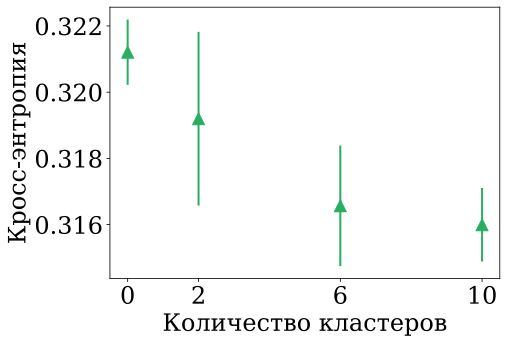

In [111]:
mean_costs_all = np.array(costs_all).mean(axis=1)
std_costs_all = np.array(costs_all).std(axis=1)

fig, ax = plt.subplots()
ax.errorbar([0,2,6,10], mean_costs_all, std_costs_all, linestyle='None', marker='^', color='#27AE60')
ax.set_xticks([0,2,6,10])

# plt.title('Кросс-энтропия S и ее дисперсия на обучении в зависимости от колическтва кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Кросс-энтропия')
plt.savefig('7.png')

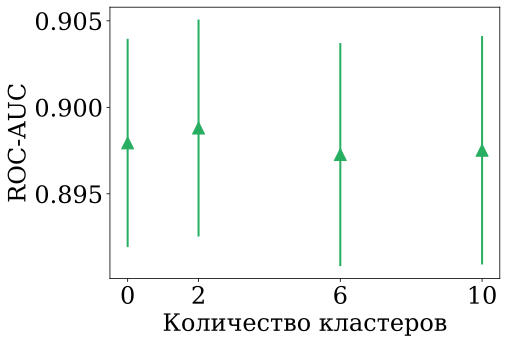

In [113]:
mean_r_all = np.array(rocs_all).mean(axis=1)
std_r_all = np.array(rocs_all).std(axis=1)

fig, ax = plt.subplots()
ax.errorbar([0,2,6,10], mean_r_all, std_r_all, linestyle='None', marker='^', color='#27AE60')
ax.set_xticks([0,2,6,10])

#plt.title('ROC AUC и его дисперсия на обучении в зависимости от колическтва кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('ROC-AUC')
plt.savefig('8.png')

In [525]:
mean_costs_all = np.array(costs_all).mean(axis=1)
std_costs_all = np.array(costs_all).std(axis=1)

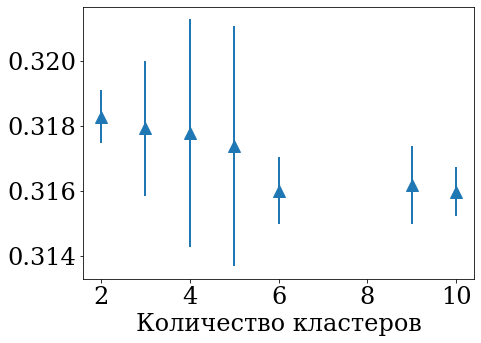

In [526]:
plt.errorbar([2,3,4,5,6,7,8,9,10], mean_costs_all, std_costs_all, linestyle='None', marker='^')
# plt.title('Кросс-энтропия S и ее дисперсия на обучении в зависимости от колическтва кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('7.png')

In [546]:
mean_r_all = np.array(rocs_all).mean(axis=1)
std_r_all = np.array(rocs_all).std(axis=1)

In [547]:
mean_r_all = np.delete(mean_r_all, 5, axis=0)
std_r_all = np.delete(std_r_all, 5, axis=0)

In [548]:
mean_r_all = np.delete(mean_r_all, 5, axis=0)
std_r_all = np.delete(std_r_all, 5, axis=0)

In [549]:
len(mean_r_all)

7

In [550]:
mean_r_all

array([0.89950471, 0.89622593, 0.89716845, 0.89270888, 0.89833696,
       0.89794275, 0.89779936])

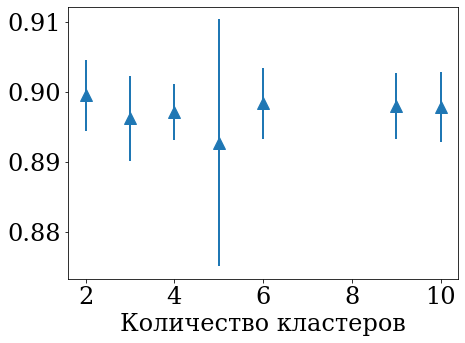

In [551]:
plt.errorbar([2,3,4,5,6,9,10], mean_r_all, std_r_all, linestyle='None', marker='^')
#plt.title('ROC AUC и его дисперсия на обучении в зависимости от колическтва кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('8.png')

In [514]:
mean_costs_all = np.array(costs_all).mean(axis=1)
std_costs_all = np.array(costs_all).std(axis=1)

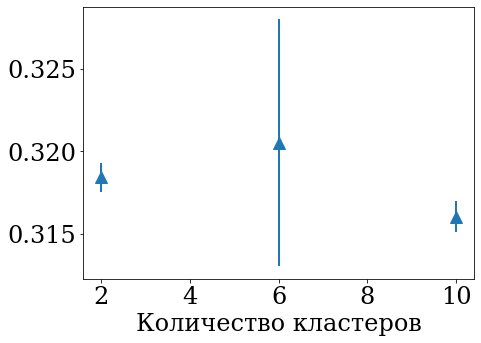

In [516]:
plt.errorbar([2,6,10], mean_costs_all, std_costs_all, linestyle='None', marker='^')
# plt.title('Кросс-энтропия S и ее дисперсия на обучении в зависимости от колическтва кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('7.png')

In [506]:
mean_costs_all = np.delete(mean_costs_all, -2, axis=0)
std_costs_all = np.delete(std_costs_all, -2, axis=0)

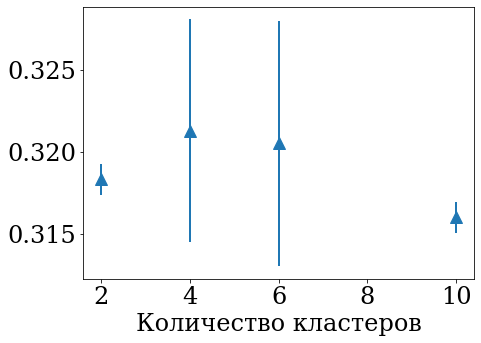

In [508]:
plt.errorbar([2,4,6,10], mean_costs_all, std_costs_all, linestyle='None', marker='^')
# plt.title('Кросс-энтропия S и ее дисперсия на обучении в зависимости от колическтва кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('7.png')

In [517]:
mean_r_all = np.array(rocs_all).mean(axis=1)
std_r_all = np.array(rocs_all).std(axis=1)

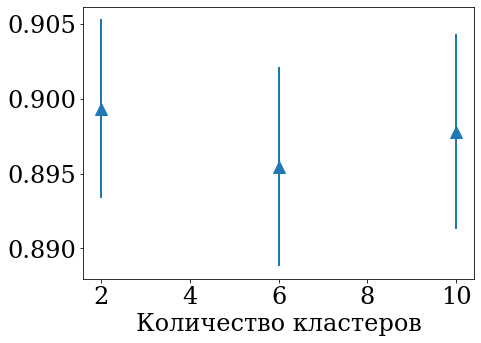

In [518]:
plt.errorbar([2,6,10], mean_r_all, std_r_all, linestyle='None', marker='^')
#plt.title('ROC AUC и его дисперсия на обучении в зависимости от колическтва кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('8.png')

In [509]:
mean_r_all = np.delete(mean_r_all, -2, axis=0)
std_r_all = np.delete(std_r_all, -2, axis=0)

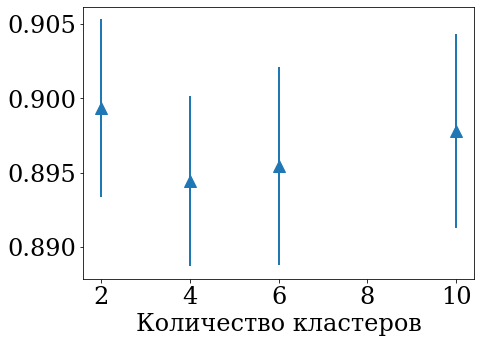

In [510]:
plt.errorbar([2,4,6,10], mean_r_all, std_r_all, linestyle='None', marker='^')
#plt.title('ROC AUC и его дисперсия на обучении в зависимости от колическтва кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('8.png')

In [179]:
def select_features(w, Xb, feat_threshold, cols):
    # Returns features with low variance
    inverse_of_A = np.dot(w.reshape(Xb.shape[1],1), w.reshape(1,Xb.shape[1]))/Xb.shape[1]
#     cov_w_matrix = np.linalg.pinv(inverse_of_A)
    cov_w_matrix = np.linalg.pinv(inverse_of_A)
    var_w = cov_w_matrix.diagonal()

    print('var_w')
    print(var_w)
    print('w')
    print(w)     
    print(cols)
    print(Xb[:, -5:])
    print(Xb.shape)
    mask2 = np.abs(var_w)<feat_threshold
    cols = [col for col, mask in zip(cols, mask2) if mask]
    w = w[mask2]
    Xb = Xb[:, mask2]
    
    return cols, w, Xb

In [159]:
def fit_with_obj_feat_selection_MF(X, T, iterations, obj_threshold, feat_threshold, n_clusters):
    
    X_ = copy.deepcopy(X)
    T_ = copy.deepcopy(T)
        
    N = X_.shape[0]
    D = X_.shape[1]
    
    Xb = preprocess(X_)
    Xb = np.hstack((Xb, np.zeros((Xb.shape[0], n_clusters))))
    
    cols = [str(i) for i in range(D + 1)] + ["cluster_" + str(x) for x in range(n_clusters)]
#     w = np.random.randn(D + 1 + n_clusters)
#     w = np.ones(D+1 + n_clusters)*math.log(T.mean()/(1-T.mean()))*0.02 + np.random.randn(D + 1 + n_clusters)*0.06
    w = np.array([-0.03650337, -0.0107314,  -0.00234493, -0.00433932, -0.03974928, -0.02914917,
 -0.01633966, -0.00345402, -0.03254841, -0.0266781,  -0.04509162, -0.04688906,
 -0.00671441,  0.00415988, -0.02440513, -0.00289427, -0.0157322 , -0.03586732,
 -0.01573701,  0.00779581, -0.02368145,  0.00832795, -0.07535983 ,-0.00652688,
 -0.02122398, -0.02894507,  0.01779581, -0.03368145,  0.00632795, -0.17535983 ,-0.00152688][:D+1+n_clusters]) + np.random.randn(D + 1 + n_clusters)[:D+1+n_clusters]*0.007
#     w = np.ones(D+1 + n_clusters)*-0.02710948

    list_w = []
    list_var_w = []
    list_var_obj = []
    costs = []

    for i in range(iterations):
        
#         if i==0:
#             print('Нулевые веса')
#             print(w)
        
        if n_clusters == 0:
            cluster_centers = []
            metric_mask = []
        
        if i!=0:
            cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

            if n_clusters != 0:
    #             Для первой итерации фиксируем кол-во признаков для кластеризации: .fit(Xb[: ,:сколько-то признаков])
                not_metric_features = ['cluster_' not in x for x in cols]
                kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Xb[:, not_metric_features])

                bc = np.bincount(kmeans.labels_)
                new_order = sorted(range(n_clusters), key=lambda x: bc[x])
                new_centroids = np.array([kmeans.cluster_centers_[i] for i in new_order])

                metric_features = pairwise_distances(Xb[:, not_metric_features], new_centroids)
                scaler = StandardScaler()
                metric_features = scaler.fit_transform(metric_features)
#                 print(i)
#                 print('metric_features')
#                 print(metric_features)

                cluster_centers = new_centroids
                print(bc)
                print(new_order)

                new_metric_cols = ['cluster_'+str(x) for x in range(metric_features.shape[1])]

                # Кластера из предыдущей итерации
                metric_cols = [x for x in cols if 'cluster_' in x]
                # metric_cols = new_metric_cols[metric_mask]
                metric_mask = [x in metric_cols for x in new_metric_cols]
                # Маска длины cols для кластеров, True только там, где кластера.
                # Позволяет выделить измененные на предыдущей итерации метрические признаки
                metric_all_mask = ['cluster_' in x for x in cols]
                Xb[:, metric_all_mask] = metric_features[:, metric_mask]

        # Модель
        Y_hat = sigmoid(Xb.dot(w))
        Y = Y_hat
        Y[Y==1.0] = 0.999999
        Y[Y==0.0] = 0.000001
        
#         print('YYYYYYYYYYYY')
#         print(Y)
        
        Xb, Y, T_ = select_objects(Y, obj_threshold, Xb, T_)
        
        costs += [cross_entropy(T_, Y)]
            
#         cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

        w, var_w, b = step_of_NR_algo(Y, w, Xb, T_)

        list_w.append(w)
        list_var_w.append(var_w)
        list_var_obj.append(b)
        
        
        #print(w)
        #print(i)

    return w, list_w, list_var_w, list_var_obj, costs, cols, metric_mask, cluster_centers

In [ ]:
# X = X_train_processed[:, :20]
# X_test = X_test_processed[:, :20]
# T = np.array(Y_train)

costs_all = []
rocs_all = []
for n_clusters in [0,4,6,8,10]:
    costs = []
    rocs_val = []
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
    #     print('ИТЕРАЦИЯ', i)
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_val = X[train_index], X[test_index]
        t_train, t_val = T[train_index], T[test_index]
        w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X_train, T=t_train, iterations=8, 
    #                                                                             obj_threshold=0.2499,
                                                                                        obj_threshold=100000000.0, 
                                                                                        feat_threshold=1.0*1e+20, 
    #                                                                                     feat_threshold=9.5*1e+00,        
                                                                                        n_clusters=n_clusters)
        
        pred3 = predict_estimates_with_MF(X_val, w3, cols=cols3, cluster_centers=cluster_centers3, metric_mask=metric_mask3)
        roc = roc_auc_score(t_val, pred3)
        rocs_val.append(copy.deepcopy(roc))
        
        costs.append(copy.deepcopy(costs3[-1]))
        
    costs_all.append(costs)
    rocs_all.append(rocs_val)

In [227]:
costs_all

[[0.3304555540205109,
  0.31938068113457946,
  0.3218361541346727,
  0.3220249843585223,
  0.32235262322876784],
 [6.743993560671017,
  6.473958528930392,
  6.323354280606641,
  6.093941240924529,
  6.392909917848229],
 [0.32566446892228185,
  0.3192766376091141,
  13.125745669264901,
  9.454522795302339,
  0.32533424086997437],
 [0.32293166646313504,
  0.3288662464130686,
  0.3196061145754296,
  0.34825635948012257,
  0.3175590795820814],
 [0.32303529329277414,
  0.3156689098981029,
  0.3177279683492837,
  0.31786190285198856,
  0.31836336359210415]]

In [228]:
mean_costs_all = np.array(costs_all).mean(axis=1)
std_costs_all = np.array(costs_all).std(axis=1)

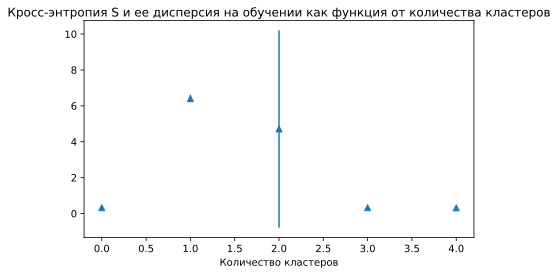

In [230]:
plt.errorbar([0,1,2,3,4], mean_costs_all, std_costs_all, linestyle='None', marker='^')
plt.title('Кросс-энтропия S и ее дисперсия на обучении как функция от количества кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('7.png')

In [217]:
mean_r_all = np.array(rocs_all).mean(axis=1)
std_r_all = np.array(rocs_all).std(axis=1)

In [218]:
std_r_all

array([0.00571089, 0.19982035, 0.00487977, 0.00449708])

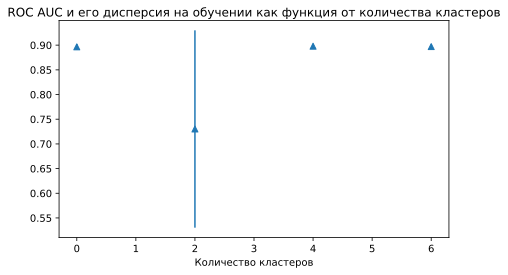

In [219]:
plt.errorbar([0,2,4,6], mean_r_all, std_r_all, linestyle='None', marker='^')
plt.title('ROC AUC и его дисперсия на обучении как функция от количества кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('8.png')

In [144]:
w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X, T=T, iterations=10, 
#                                                                             obj_threshold=0.2499,
                                                                                    obj_threshold=100000000.0, 
                                                                                    feat_threshold=1.0*1e+20, 
#                                                                                     feat_threshold=9.5*1e+00,        
                                                                                    n_clusters=5)

Нулевые веса
[ 0.03765963 -0.04629807  0.0432905   0.06759209  0.02048195  0.09364999
 -0.03887926 -0.06242253 -0.08912581  0.07461242  0.03252848 -0.00296903
  0.01380863 -0.05646425  0.1220978   0.00627126  0.00527994  0.03609853
  0.02386066  0.0110044  -0.03971352  0.02338362  0.09391143  0.0670812
  0.07946953 -0.02575058 -0.04967004 -0.00647915  0.00259645  0.05451978]
YYYYYYYYYYYY
[0.43370664 0.49492897 0.48127326 ... 0.44684609 0.74409383 0.49579288]
[ 0.03765963 -0.04629807  0.0432905   0.06759209  0.02048195  0.09364999
 -0.03887926 -0.06242253 -0.08912581  0.07461242  0.03252848 -0.00296903
  0.01380863 -0.05646425  0.1220978   0.00627126  0.00527994  0.03609853
  0.02386066  0.0110044  -0.03971352  0.02338362  0.09391143  0.0670812
  0.07946953 -0.02575058 -0.04967004 -0.00647915  0.00259645  0.05451978]
[0.43370664 0.49492897 0.48127326 ... 0.44684609 0.74409383 0.49579288]
var_w
[-1.32449693e+19  6.79656007e+19 -1.56202585e+20 -1.33747464e+19
  2.07381826e+21 -5.15416425e

5
metric_features
[[-1.62445721 -0.85330042  0.23494055 -1.67410019 -0.49181439]
 [-0.96917997 -0.68077656  0.05541697 -1.88639921 -0.95366132]
 [ 0.20442021 -0.47016133 -0.36760391 -0.94321775 -0.05597576]
 ...
 [-1.20618667 -1.32565583 -0.51423379 -0.82938452 -0.79308244]
 [ 1.07411446  0.67631718 -0.30470351  0.9768206  -0.43653887]
 [ 0.01710838  0.93507853  0.42304681  0.82679856 -0.44910183]]
[1422  934  861  858  983]
[3, 2, 1, 4, 0]
YYYYYYYYYYYY
[0.63276997 0.57010015 0.44011762 ... 0.41004036 0.65290575 0.66397717]
[-0.05778462 -0.03230264  0.28911351 -0.17616182  0.16550088  0.12517965
  0.03071604  0.32588011  0.39202897 -0.17810513 -0.36391372  0.51329564
 -0.40260998  0.81015659 -0.36496196]
[0.63276997 0.57010015 0.44011762 ... 0.41004036 0.65290575 0.66397717]
var_w
[-5.40454134e+18  1.72234371e+18 -3.39796479e+17 -6.22543248e+17
 -2.11264110e+18 -2.52179470e+17  1.18109312e+19 -3.91434638e+17
  8.24084795e+15 -1.26784411e+18  4.53871389e+16 -7.20866518e+16
 -9.07178757e

10
metric_features
[[-1.62445721 -0.85330042  0.23494055 -1.67410019 -0.49181439]
 [-0.96917997 -0.68077656  0.05541697 -1.88639921 -0.95366132]
 [ 0.20442021 -0.47016133 -0.36760391 -0.94321775 -0.05597576]
 ...
 [-1.20618667 -1.32565583 -0.51423379 -0.82938452 -0.79308244]
 [ 1.07411446  0.67631718 -0.30470351  0.9768206  -0.43653887]
 [ 0.01710838  0.93507853  0.42304681  0.82679856 -0.44910183]]
[1422  934  861  858  983]
[3, 2, 1, 4, 0]
YYYYYYYYYYYY
[0.61383127 0.58463833 0.5058158  ... 0.39460076 0.76184923 0.51931394]
[-0.23522782 -0.0622182   0.44933746 -0.30640218  0.30814179  0.192946
  0.049028    0.44042478  0.52438828 -0.21218285 -0.50346791  0.9054265
 -0.52299499  0.64880773 -0.4190888 ]
[0.61383127 0.58463833 0.5058158  ... 0.39460076 0.76184923 0.51931394]
var_w
[-3.71125841e+18 -1.61736139e+19 -1.08104012e+18 -3.77797523e+18
 -1.90323756e+18 -1.40833124e+19  1.68135195e+19 -2.50090956e+18
 -1.98680386e+17 -6.62616795e+18 -1.09800479e+18 -9.25287216e+16
 -3.16841570e+1

 [-3.1433165  -0.67774546  0.94062238  0.04310061 -0.43430638]]
(5058, 14)
15
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.57814266 0.55422115 0.38964706 ... 0.37363865 0.69875847 0.62558613]
[-0.24978431  0.43207001 -0.29649636  0.30194696  0.39849473  0.47405931
 -0.18913358 -0.4555667   0.89608825  0.65047258 -0.65149596 -0.375848  ]
[0.57814266 0.55422115 0.38964706 ... 0.37363865 0.69875847 0.62558613]
var_w
[-5.35023099e+17 -6.58925615e+17  3.74841484e+17 -1.41732635e+18
 -2.49422262e+18 -7.08457470e+17 -1.35185735e+17 -1.12157967e+17
 -7.17653549e+17 -3.18736657e+17 -4.381

21
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[-1.18064394e+19 -1.50032777e+17  6.48287041e+16  2.02569303e+17
 -5.16074845e+16 -1.19100632e+16 -2.33341127e+17 -7.54855388e+17
 -4.17832655e+16  3.99560759e+17 -1.23918575e+17 -1.69459737e+18]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

27
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[1.69022266e+18 1.07903409e+16 1.39148110e+18 3.95128353e+17
 2.94152803e+17 5.48134796e+17 1.57156109e+18 1.95159583e+17
 7.62479354e+16 2.90805077e+17 8.67568530e+16 2.49620056e+18]
w
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.603961

33
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[-1.31035162e+19 -2.09897792e+17  9.26093020e+17  3.03920675e+17
 -6.02849432e+16 -1.71717316e+15  4.68197217e+17  1.90699471e+17
  7.20910424e+16 -8.02258086e+16  1.00205198e+18  2.59345360e+17]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

39
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[-3.55013835e+17 -1.75899280e+16 -2.10377682e+17 -3.24666293e+17
 -1.95510153e+17 -2.50086645e+16  1.74715568e+17 -8.05553298e+16
 -1.99738243e+16 -2.81771553e+16  5.35973205e+16 -1.45165067e+17]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

45
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[ 1.58223622e+18  4.04363417e+16  1.58781803e+17 -1.34477863e+17
 -2.22216415e+16 -3.62703107e+16 -1.90841025e+17  4.07729533e+16
  7.75926086e+15  3.70295429e+17  3.67623075e+17 -1.85285711e+17]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

51
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[ 1.73578577e+18 -7.82895193e+16  2.18077034e+16 -2.84838431e+16
  3.50425368e+17  5.54660277e+16  2.26472823e+17  4.84511915e+16
  2.27262613e+16  3.12555351e+17 -4.80610849e+15 -2.75208575e+17]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

57
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[-2.75761923e+18 -1.20304049e+17  1.28950051e+17  3.92918331e+17
 -3.26556390e+17 -3.85240627e+16 -1.39007241e+17 -9.57893213e+16
  2.30887380e+16  8.43613304e+16 -3.45053637e+17 -6.31439115e+17]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

In [162]:
feat_threshold=1.0*1e+20

In [165]:
#Good parameters
# w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X, T=T, iterations=60, 
# #                                                                             obj_threshold=0.2499,
#                                                                                     obj_threshold=100000000.0, 
#                                                                                     feat_threshold=1.0*1e+20, 
# #                                                                                     feat_threshold=9.5*1e+00,        
#                                                                                     n_clusters=5)

UsageError: Unknown variable 'w3,'


In [128]:
cols3, len(cols3)

(['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  'cluster_0',
  'cluster_1',
  'cluster_3',
  'cluster_4'],
 25)

In [129]:
# plt.bar(np.arange(len(w3)), w3)
# plt.xticks(np.arange(len(w3)), cols3)

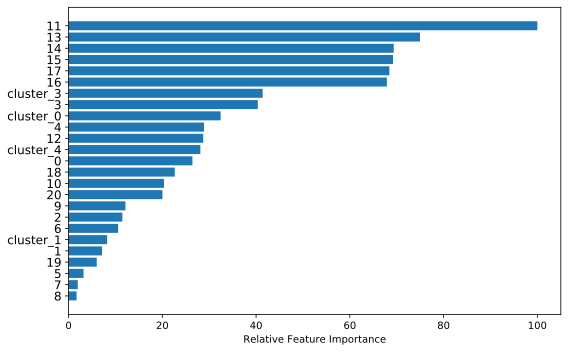

In [130]:
feature_importance = abs(w3)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(8, 5))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(cols3)[sorted_idx], fontsize=12)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   

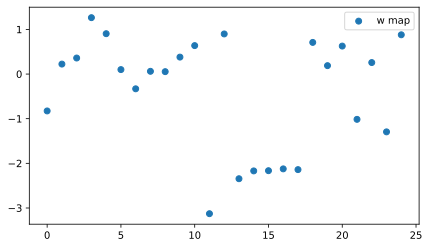

In [131]:
plot_weights(w3)

In [296]:
pred3 = predict_estimates_with_MF(X_test, w3, cols=cols3, cluster_centers=cluster_centers3, metric_mask=metric_mask3)

In [297]:
roc_auc_score(t_test, pred3)

0.740014698806511

In [298]:
fpr, tpr, thresholds = metrics.roc_curve(t_test, pred3, pos_label=None)

In [324]:
from utils import *

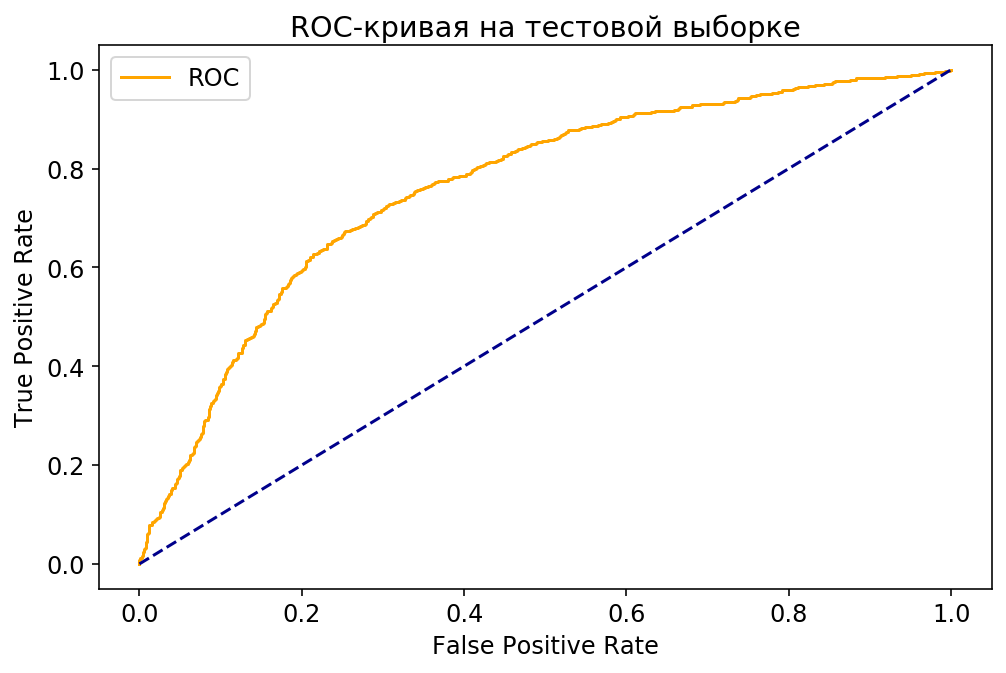

In [325]:
plot_roc_cur(fpr, tpr, title='ROC-кривая на тестовой выборке')

Text(0.5, 1.0, 'Зависимость S от номера итерации')

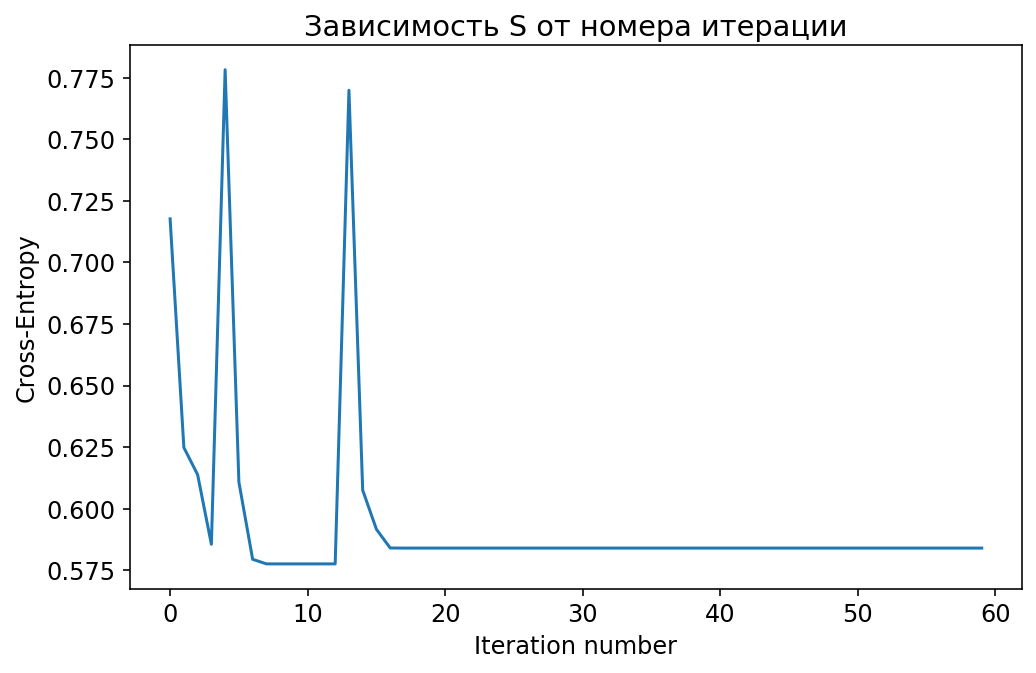

In [300]:
plt.plot(np.arange(len(costs3)),costs3)
plt.xlabel('Iteration number')
plt.ylabel('Cross-Entropy')
plt.title('Зависимость S от номера итерации')

Text(0.5, 1.0, 'Зависимость exp(-S) от номера итерации')

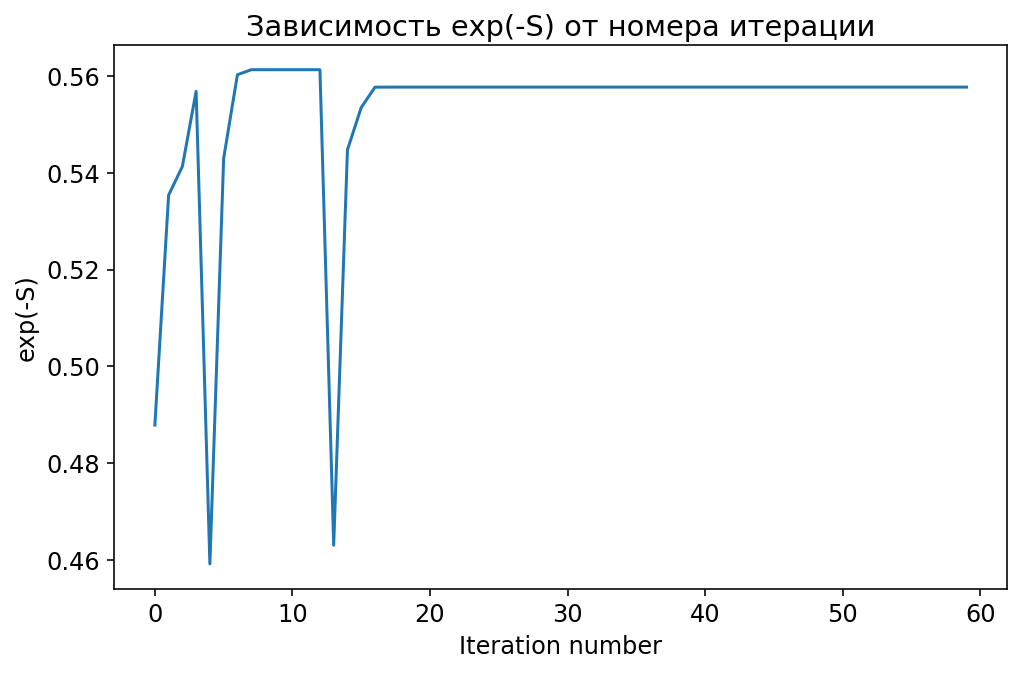

In [301]:
plt.plot(np.arange(len(costs3)),np.exp(-np.array(costs3)))
plt.xlabel('Iteration number')
plt.ylabel('exp(-S)')
plt.title('Зависимость exp(-S) от номера итерации')

In [302]:
def var_of_w(l, i):
    res = []
    for item in l:
        if len(item) > i:
            res.append(item[i])
    return res

In [303]:
cols3

['0',
 '6',
 '7',
 '10',
 '16',
 '17',
 '18',
 '19',
 '22',
 'cluster_0',
 'cluster_1',
 'cluster_4']

Text(0.5, 1.0, 'Зависимость нешумовых параметров модели w от номера итерации')

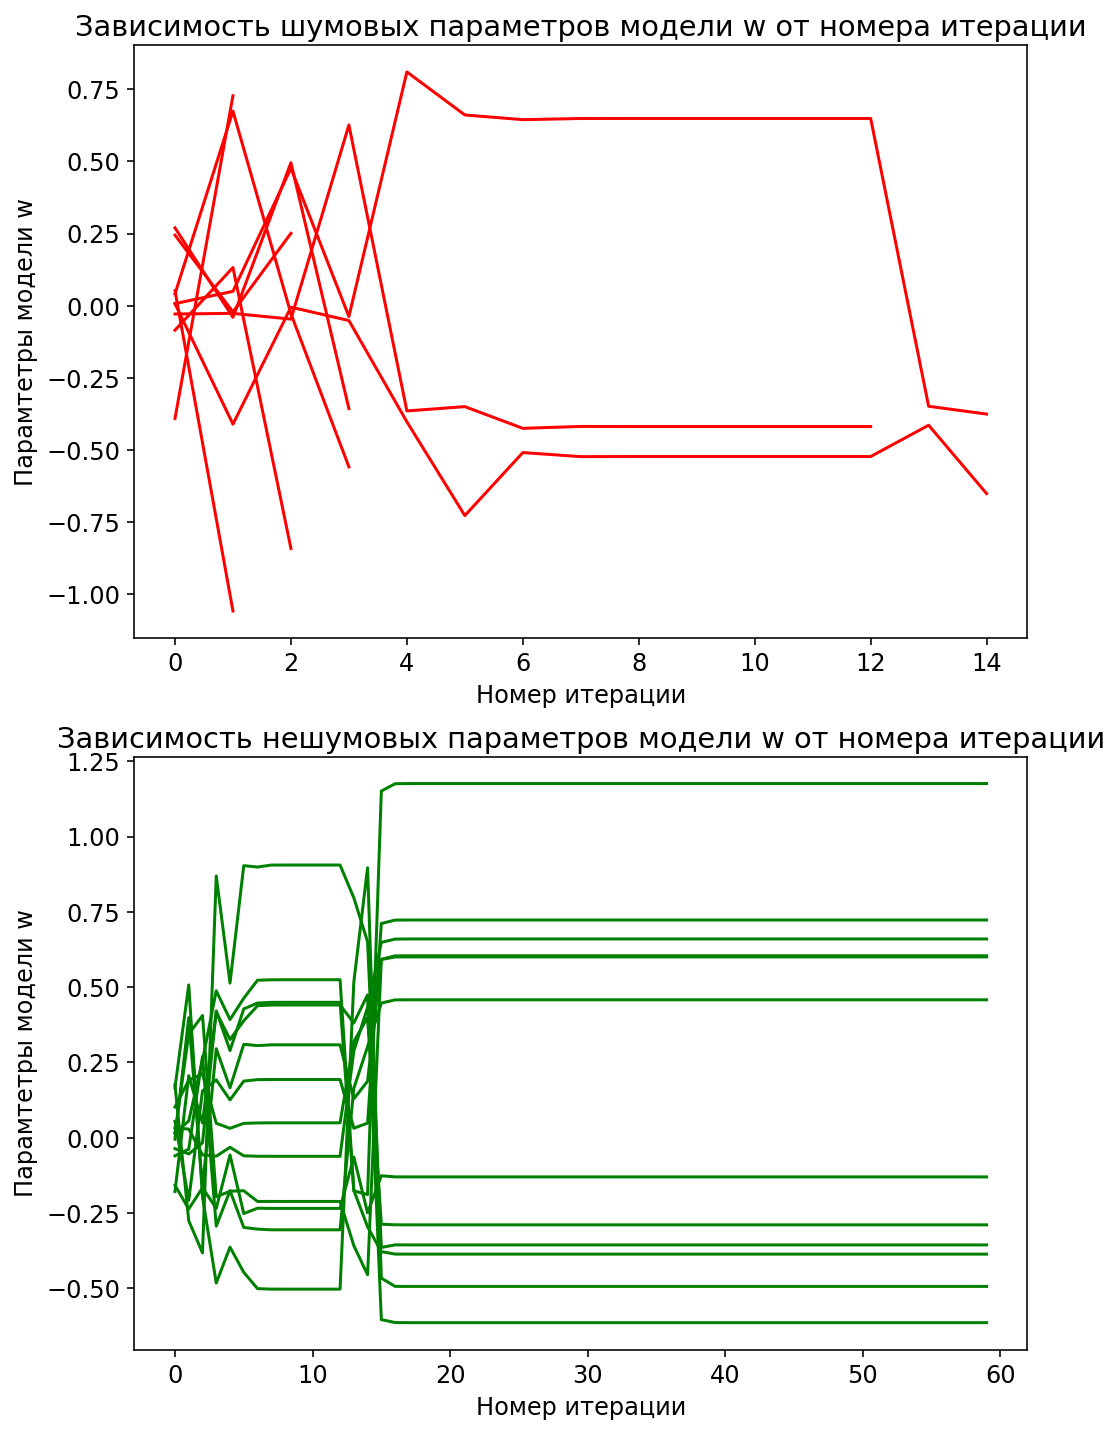

In [304]:
plt.figure(figsize=(8,12))
plt.subplot(211)
for i in range(len(list_w3[0])):
    if len(var_of_w(list_w3, i))<len(var_of_w(list_w3, 0)):
        plt.plot(var_of_w(list_w3, i), color='r')
plt.xlabel('Номер итерации')
plt.ylabel('Парамтетры модели w')
plt.title('Зависимость информативныхых параметров модели w от номера итерации')
plt.subplot(212)
for i in range(len(list_w3[0])):
    if len(var_of_w(list_w3, i))>=len(var_of_w(list_w3, 0)):
        plt.plot(var_of_w(list_w3, i), color='g')
plt.xlabel('Номер итерации')
plt.ylabel('Парамтетры модели w')
plt.title('Зависимость неинформативных параметров модели w от номера итерации')

Text(0.5, 1.0, 'Зависимость нешумовых элементов матрицы A от номера итерации')

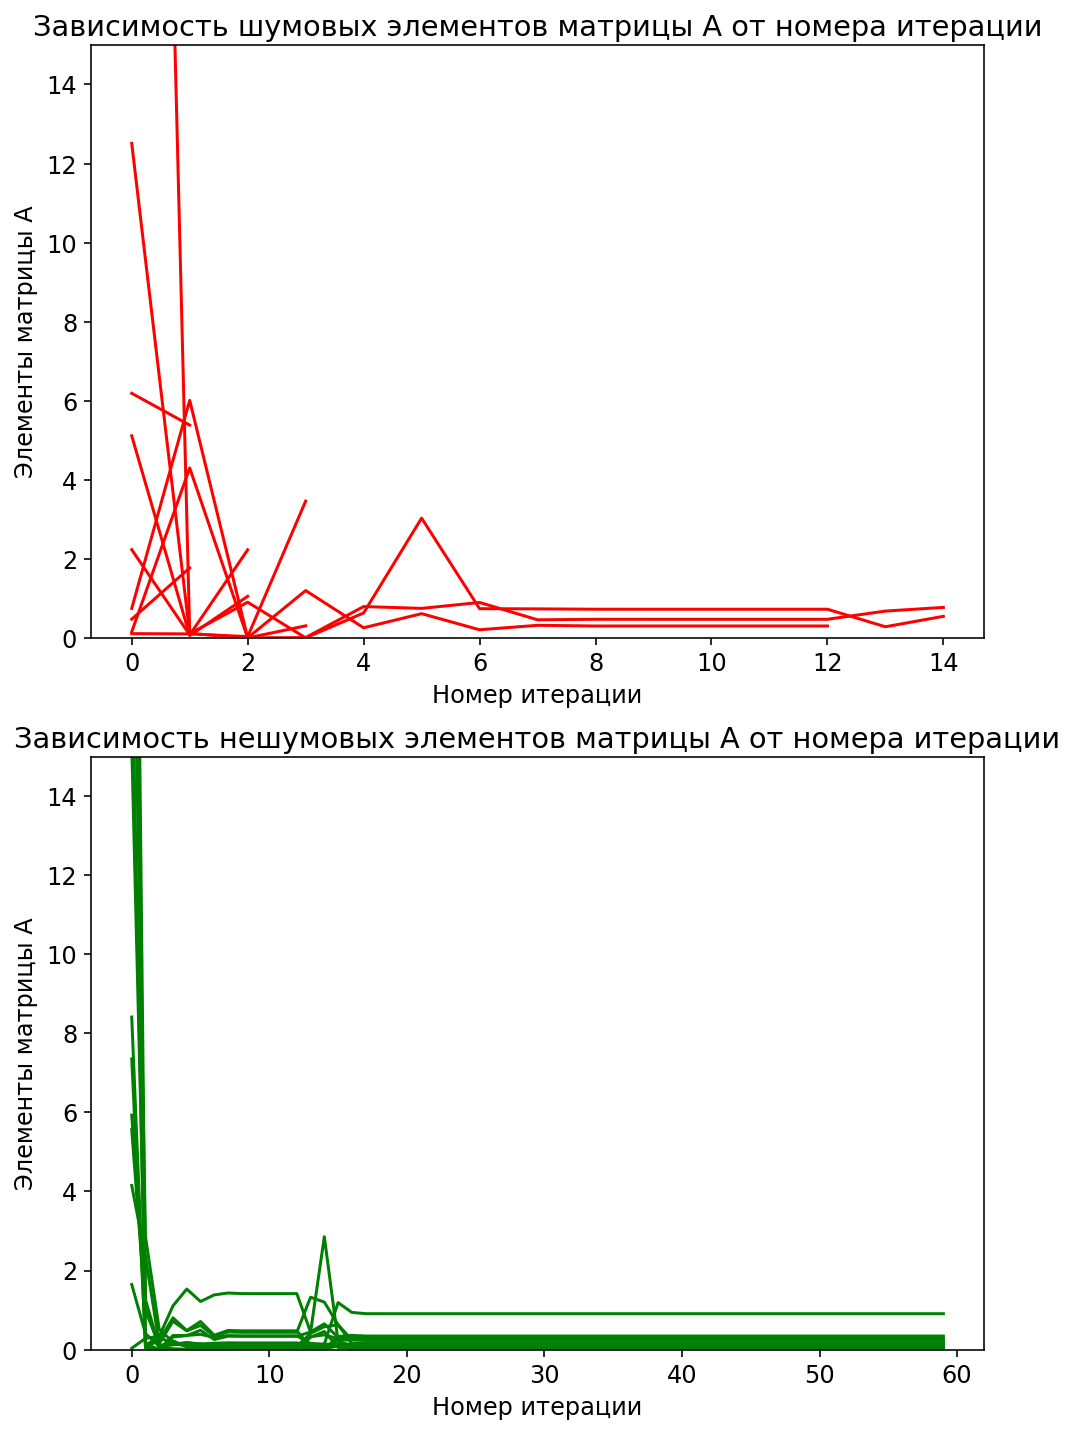

In [319]:
plt.figure(figsize=(8,12))
plt.subplot(211)
for i in range(len(list_var_w3[0])):
    if len(var_of_w(list_var_w3, i))<len(var_of_w(list_var_w3, 0)):
        plt.plot(var_of_w(list_var_w3, i), color='r')
        plt.ylim(0,15)
plt.xlabel('Номер итерации')
plt.ylabel('Элементы матрицы A')
plt.title('Зависимость информативных элементов матрицы A от номера итерации')
plt.subplot(212)
for i in range(len(list_var_w3[0])):
    if len(var_of_w(list_var_w3, i))>=len(var_of_w(list_var_w3, 0)):
        plt.plot(var_of_w(list_var_w3, i), color='g')
        plt.ylim(0,15)
plt.xlabel('Номер итерации')
plt.ylabel('Элементы матрицы A')
plt.title('Зависимость неинформативных элементов матрицы A от номера итерации')

In [306]:
model = LogisticRegression(random_state=0)
model.fit(X, T)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [307]:
y_scores = model.predict_proba(X_test)[:, 1]

In [308]:
from sklearn.metrics import roc_auc_score
print('AUC-ROC', roc_auc_score(t_test, y_scores))

AUC-ROC 0.761931508199319


In [309]:
fpr, tpr, thresholds = metrics.roc_curve(t_test, y_scores, pos_label=None)

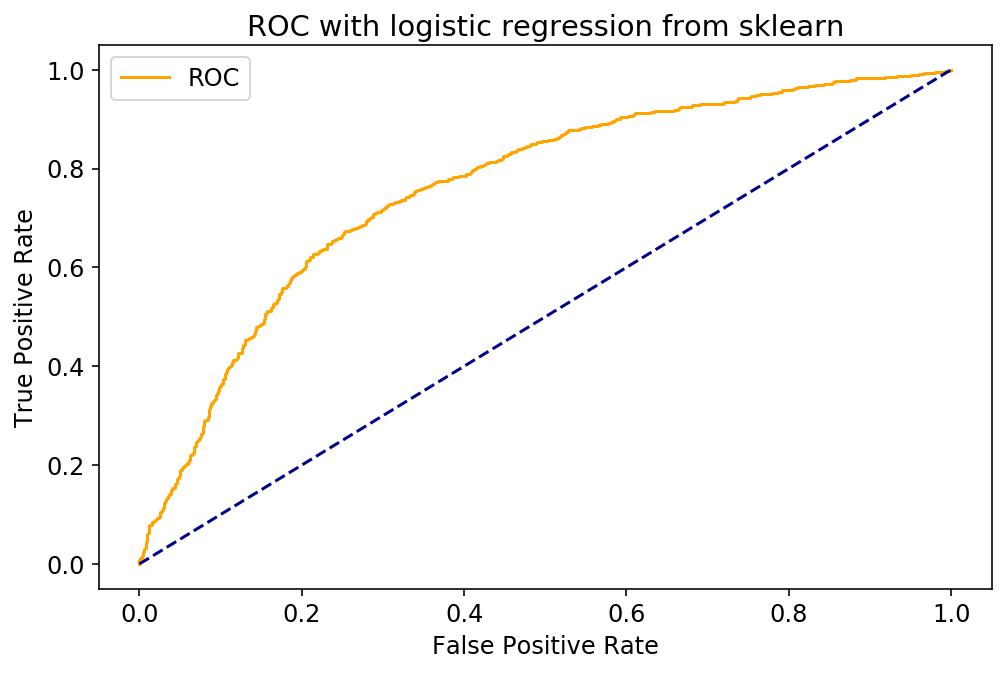

In [310]:
plot_roc_cur(fpr, tpr, title='ROC with logistic regression from sklearn')

In [311]:
coefs = np.abs(model.coef_[0])

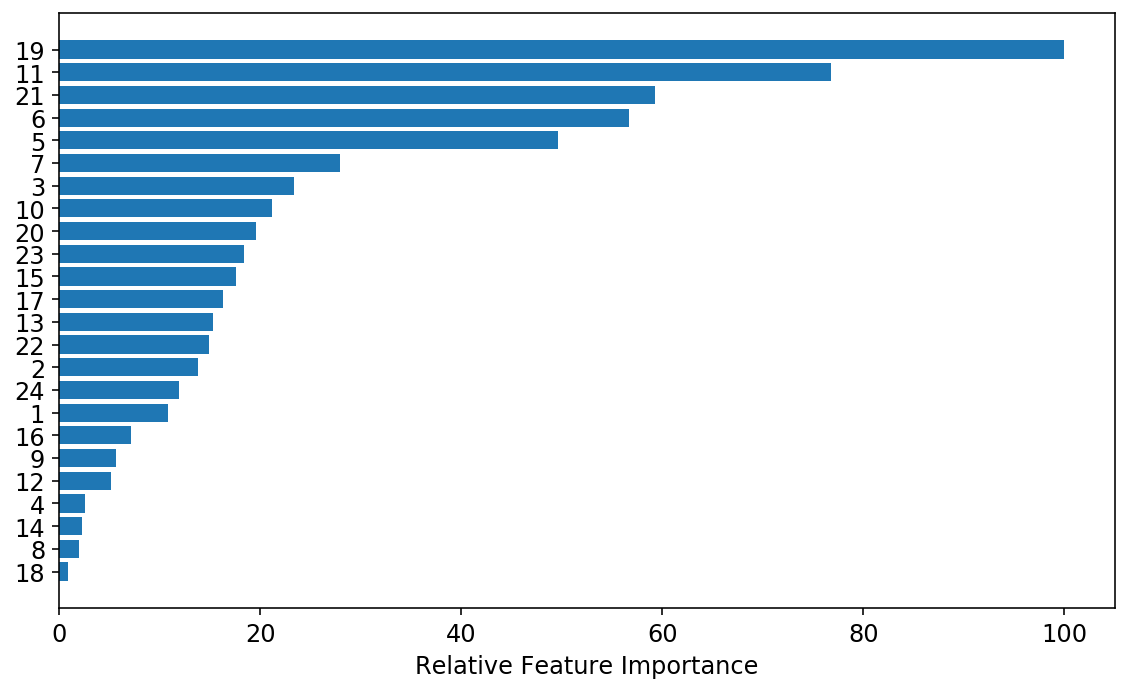

In [314]:
feature_importance = abs(coefs)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(8, 5))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array([i for i in range(1, len(coefs)+1)])[sorted_idx], fontsize=12)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   

In [315]:
ar = []
for x in zip(model.coef_[0], range(1, len(model.coef_[0]+1))):
    ar.append(x)

In [316]:
ar

[(0.02884190256929138, 1),
 (-0.03660332857156802, 2),
 (-0.062136891110611256, 3),
 (-0.006959391203323793, 4),
 (0.1316977143532688, 5),
 (-0.15049495560656845, 6),
 (-0.07423690852773168, 7),
 (0.005310721220262649, 8),
 (0.015066120786570098, 9),
 (0.05621064093753258, 10),
 (0.20401281647254432, 11),
 (0.01358054820358015, 12),
 (-0.04054838239203495, 13),
 (-0.006043896772392055, 14),
 (0.04681472305985809, 15),
 (0.019054383919492265, 16),
 (0.043429157255352, 17),
 (-0.002427092508821553, 18),
 (-0.26562863122667024, 19),
 (0.05200979104408491, 20),
 (0.1574091334836388, 21),
 (-0.03955509159077588, 22),
 (-0.04878421730842163, 23)]

### SelectFromModel

In [265]:
d1 = pd.DataFrame(X, columns=[str(i) for i in range(1, X.shape[1]+1)])
d2 = pd.DataFrame(X_test, columns=[str(i) for i in range(1, X_test.shape[1]+1)])

In [274]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), max_features=12)
embeded_lr_selector.fit(d1, T)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = d1.loc[:,embeded_lr_support].columns.tolist()
print(embeded_lr_feature, str(len(embeded_lr_feature)), 'selected features')

['3', '5', '6', '7', '10', '11', '13', '17', '19', '20', '21', '23'] 12 selected features


C:\Users\Irina\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [293]:
set(embeded_lr_feature) & set(cols3), len(set(embeded_lr_feature) & set(cols3))

({'11', '19', '20', '21', '23', '5', '6'}, 7)

### Tree-based: SelectFromModel

In [275]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=12)
embeded_rf_selector.fit(d1, T)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = d1.loc[:,embeded_rf_support].columns.tolist()
print(embeded_lr_feature, str(len(embeded_rf_feature)), 'selected features')

['3', '5', '6', '7', '10', '11', '13', '17', '19', '20', '21', '23'] 10 selected features


In [294]:
set(embeded_lr_feature) & set(cols3), len(set(embeded_lr_feature) & set(cols3))

({'11', '19', '20', '21', '23', '5', '6'}, 7)

### Pearson Correlation

In [295]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [296]:
cor_support, cor_feature = cor_selector(d1, T, 12)
print(sorted([int(i) for i in cor_feature]), str(len(cor_feature)), 'selected features')

[5, 6, 7, 9, 10, 11, 15, 16, 19, 21, 22, 23] 12 selected features


In [307]:
set(cor_feature) & set(cols3), len(set(cor_feature) & set(cols3))

({'11', '15', '19', '21', '23', '5', '6'}, 7)

### Новая синтетическая выборка

In [552]:
ds = make_classification(n_samples=7550, n_features=24, n_informative=12, 
                         flip_y=0.33, random_state=42)

In [553]:
X, T = ds

In [554]:
X, X_test, T, t_test = train_test_split(X, T, test_size=0.33, random_state=42)

In [555]:
def fit_with_obj_feat_selection_MF(X, T, iterations, obj_threshold, feat_threshold, n_clusters):
    
    X_ = copy.deepcopy(X)
    T_ = copy.deepcopy(T)
        
    N = X_.shape[0]
    D = X_.shape[1]
    
    Xb = preprocess(X_)
    Xb = np.hstack((Xb, np.zeros((Xb.shape[0], n_clusters))))
    
    cols = [str(i) for i in range(D + 1)] + ["cluster_" + str(x) for x in range(n_clusters)]
#     w = np.random.randn(D + 1 + n_clusters)
    w = np.ones(D+1 + n_clusters)*math.log(T.mean()/(1-T.mean()))*0.02 + np.random.randn(D + 1 + n_clusters)*0.05
    w = np.array([ 0.09171938, -0.0113631,  -0.01765564 ,-0.00116078, -0.01534879,  0.0398073 ,
 -0.08100533 ,-0.05287392 ,-0.05357995 , 0.04732558 , 0.08534087, -0.00541226,
 -0.00863089 , 0.00331281  ,0.05790412, -0.04655746 , 0.01172865 , 0.04857008,
  0.02486491 , 0.00928928 , 0.0498625 , -0.13535141 , 0.03370397, -0.03289358,
 -0.09172144 , 0.02537033,  0.06849313, -0.00706223,  0.04745393 , 0.08042411])
#     w = np.ones(D+1 + n_clusters)*-0.02710948

    list_w = []
    list_var_w = []
    list_var_obj = []
    costs = []

    for i in range(iterations):
        
        if n_clusters == 0:
            cluster_centers = []
            metric_mask = []
        
        if i!=0:
            cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

            if n_clusters != 0:
    #             Для первой итерации фиксируем кол-во признаков для кластеризации: .fit(Xb[: ,:сколько-то признаков])
                not_metric_features = ['cluster_' not in x for x in cols]
                kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Xb[:, not_metric_features])

                bc = np.bincount(kmeans.labels_)
                new_order = sorted(range(n_clusters), key=lambda x: bc[x])
                new_centroids = np.array([kmeans.cluster_centers_[i] for i in new_order])

                metric_features = pairwise_distances(Xb[:, not_metric_features], new_centroids)
                scaler = StandardScaler()
                metric_features = scaler.fit_transform(metric_features)
                print(i)
                print('metric_features')
                print(metric_features)

                cluster_centers = new_centroids
                print(bc)
                print(new_order)

                new_metric_cols = ['cluster_'+str(x) for x in range(metric_features.shape[1])]

                # Кластера из предыдущей итерации
                metric_cols = [x for x in cols if 'cluster_' in x]
                # metric_cols = new_metric_cols[metric_mask]
                metric_mask = [x in metric_cols for x in new_metric_cols]
                # Маска длины cols для кластеров, True только там, где кластера.
                # Позволяет выделить измененные на предыдущей итерации метрические признаки
                metric_all_mask = ['cluster_' in x for x in cols]
                Xb[:, metric_all_mask] = metric_features[:, metric_mask]

        # Модель
        Y_hat = sigmoid(Xb.dot(w))
        Y = Y_hat
        Y[Y==1.0] = 0.999999
        Y[Y==0.0] = 0.000001
        
        print('YYYYYYYYYYYY')
        print(Y)
        
        Xb, Y, T_ = select_objects(Y, obj_threshold, Xb, T_)
        
        costs += [cross_entropy(T_, Y)]
            
#         cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

        w, var_w, b = step_of_NR_algo(Y, w, Xb, T_)

        list_w.append(w)
        list_var_w.append(var_w)
        list_var_obj.append(b)
        
        
        #print(w)
        #print(i)

    return w, list_w, list_var_w, list_var_obj, costs, cols, metric_mask, cluster_centers

In [566]:
%%time
w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X, T=T, iterations=50, 
#                                                                             obj_threshold=0.2499,
                                                                                    obj_threshold=100000000.0, 
                                                                                    feat_threshold=1e+21, 
#                                                                                     feat_threshold=9.5*1e+00,        
                                                                                    n_clusters=5)

YYYYYYYYYYYY
[0.42864556 0.55936118 0.36604985 ... 0.38472596 0.55523473 0.49778558]
[ 0.09171938 -0.0113631  -0.01765564 -0.00116078 -0.01534879  0.0398073
 -0.08100533 -0.05287392 -0.05357995  0.04732558  0.08534087 -0.00541226
 -0.00863089  0.00331281  0.05790412 -0.04655746  0.01172865  0.04857008
  0.02486491  0.00928928  0.0498625  -0.13535141  0.03370397 -0.03289358
 -0.09172144  0.02537033  0.06849313 -0.00706223  0.04745393  0.08042411]
[0.42864556 0.55936118 0.36604985 ... 0.38472596 0.55523473 0.49778558]
var_w
[ 9.49347809e+17  1.25696995e+20  1.79605340e+20  4.07605115e+19
  3.75549494e+22  1.34923724e+19  3.88846731e+18 -8.18789690e+18
 -9.49525059e+20 -1.05141747e+19 -1.52081777e+22 -8.74234518e+17
 -3.11094466e+18 -1.65348135e+18  2.92752670e+20  1.37897583e+19
  3.89603390e+19  2.24643681e+20  1.84730243e+19 -1.16402740e+18
  3.54347762e+19  4.84430764e+18  3.47964589e+19 -1.90844445e+19
 -1.81362901e+20  1.61880174e+20 -5.35311782e+19 -8.50626818e+20
  2.14400983e+21 

4
metric_features
[[ 0.60811872  1.48741144 -0.94592246  0.7931137   0.26191342]
 [-0.40836087  0.31712716 -1.87969083 -0.41920047 -0.84401359]
 [-0.78120704  0.62802794 -1.08649998  0.00940565  0.46912457]
 ...
 [ 0.34709189 -1.09811886  0.92533147  0.13662768 -0.20312835]
 [ 0.32173166 -0.73191559  1.56713306 -0.28151382  0.96718294]
 [ 0.25928173  0.05522014  0.12311561 -0.98599956 -0.32138504]]
[ 732 1094 1171  905 1156]
[0, 3, 1, 4, 2]
YYYYYYYYYYYY
[0.48294025 0.57554309 0.50071956 ... 0.26231339 0.72945704 0.59481329]
[-0.31567559  0.03348604 -0.04669167 -0.06307858  0.18158404 -0.21100016
  0.03477395  0.1791539   0.03835212 -0.2014627   0.04613505 -0.2410806
 -0.12888418  0.11791757 -0.08048979  0.05671022  0.22007523 -0.16645142
 -0.04481679 -0.04076149 -0.37330353  1.18034726  0.35014357 -1.13520147]
[0.48294025 0.57554309 0.50071956 ... 0.26231339 0.72945704 0.59481329]
var_w
[ 9.93166380e+17 -3.34311679e+19 -6.76282665e+19  8.96997605e+18
 -3.42996512e+18  2.72839563e+18  1

8
metric_features
[[ 0.60811872  1.48741144 -0.94592246  0.7931137   0.26191342]
 [-0.40836087  0.31712716 -1.87969083 -0.41920047 -0.84401359]
 [-0.78120704  0.62802794 -1.08649998  0.00940565  0.46912457]
 ...
 [ 0.34709189 -1.09811886  0.92533147  0.13662768 -0.20312835]
 [ 0.32173166 -0.73191559  1.56713306 -0.28151382  0.96718294]
 [ 0.25928173  0.05522014  0.12311561 -0.98599956 -0.32138504]]
[ 732 1094 1171  905 1156]
[0, 3, 1, 4, 2]
YYYYYYYYYYYY
[0.48301564 0.57564207 0.50076886 ... 0.2624304  0.72942872 0.5947211 ]
[-0.31577751  0.03345137 -0.04669802 -0.0631007   0.18187228 -0.21095271
  0.03426151  0.17864021  0.03776983 -0.20213286  0.04611815 -0.24171129
 -0.1287437   0.11841364 -0.08068345  0.05666045  0.22055953 -0.16714563
 -0.04485522 -0.04076381 -0.37295514  1.17826783  0.34842162 -1.132491  ]
[0.48301564 0.57564207 0.50076886 ... 0.2624304  0.72942872 0.5947211 ]
var_w
[-8.47603098e+17 -3.36520842e+19 -1.25157242e+19  9.82810881e+18
  2.14842736e+18 -5.85577112e+17  

12
metric_features
[[ 0.51366507  1.50629958 -0.94829795  0.62464637  0.64394136]
 [-0.37471256  0.52980765 -1.66638475 -0.52683061 -0.60129383]
 [-0.9519242   0.77140313 -0.75830756 -0.06342448  0.89959472]
 ...
 [ 0.56063132 -1.06422477  1.26195185  0.47345761  0.29052808]
 [ 0.30274958 -1.02582218  1.31505218 -0.08286839  0.7378419 ]
 [ 0.12798547  0.07027905 -0.38906135 -0.85230607 -0.76843196]]
[1147  801 1014 1238  858]
[1, 4, 2, 0, 3]
YYYYYYYYYYYY
[0.69722771 0.69306153 0.38471222 ... 0.41777543 0.44618173 0.71158469]
[ 0.08131297  0.19321935 -0.05004917 -0.14182833 -0.07810177 -0.08419513
  0.11936946 -0.19567292 -0.19951368  0.8710957   0.14647012 -0.66339934]
[0.69722771 0.69306153 0.38471222 ... 0.41777543 0.44618173 0.71158469]
var_w
[-6.84494434e+17 -9.98342037e+18 -6.81900390e+22 -6.50470629e+18
 -8.05479464e+17  6.77323083e+17  4.07661397e+17 -4.72458295e+18
 -1.18486954e+19 -1.19452711e+18 -1.36219798e+17 -1.07114601e+17]
w
[ 0.16759047  0.09806023 -0.00227554  0.025500

18
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144368 0.60990732 0.53811576 ... 0.24018366 0.73947983 0.6848962 ]
[ 0.12750993  0.29626621 -0.14228176 -0.14137494  0.04348917 -0.09019657
 -0.7174013   0.84829493 -0.40592683 -0.39691155]
[0.69144368 0.60990732 0.53811576 ... 0.24018366 0.73947983 0.6848962 ]
var_w
[ 1.98167925e+18 -1.40561228e+17 -1.41093873e+17  4.43186072e+18
 -2.50151788e+19  2.80837753e+19  2.31054814e+17  8.58369969e+17
  1.97211096e+18  1.42952916e+18]
w
[ 0.12755164  0.29624659 -0.142218   -0.14138962  0.04350685 -0.09017378
 -0.71748253  0.84821116 -0.4

24
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.40610351 -0.39665362]
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
var_w
[ 3.86152813e+18 -1.09792073e+18  1.29802816e+18  1.82485202e+18
 -3.73783099e+19  1.40892960e+18 -3.49961073e+16  7.73603013e+16
 -4.09592523e+16 -1.04550452e+17]
w
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.4

30
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.40610351 -0.39665362]
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
var_w
[-1.04935330e+18  5.49031583e+16  1.22205258e+18  7.26336499e+17
  8.26375805e+18 -1.46169446e+19  5.35739341e+16  1.17538201e+17
  1.43999302e+17  2.67374605e+17]
w
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.4

36
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.40610351 -0.39665362]
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
var_w
[-2.08796504e+18 -3.03761372e+17  2.37959587e+18  1.40212922e+18
  2.15601566e+19 -9.32196335e+18 -1.77430219e+17 -4.10238297e+14
  5.47849105e+16  1.71376150e+16]
w
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.4

42
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.40610351 -0.39665362]
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
var_w
[ 7.03855145e+17  2.36023265e+16 -3.08474675e+18  2.72182867e+18
  6.66478592e+19  1.32472231e+19 -8.37860267e+17 -7.27876267e+17
 -5.53621339e+16  1.44280853e+17]
w
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.4

48
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.40610351 -0.39665362]
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
var_w
[-2.54588408e+18 -7.78319829e+17 -1.51303946e+18  5.43627379e+17
 -1.19931315e+20 -4.23357942e+18 -2.88809613e+17 -4.36587319e+15
 -8.51304276e+17  8.24297874e+15]
w
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.4

In [575]:
def fit_with_obj_feat_selection_MF(X, T, iterations, obj_threshold, feat_threshold, n_clusters):
    
    X_ = copy.deepcopy(X)
    T_ = copy.deepcopy(T)
        
    N = X_.shape[0]
    D = X_.shape[1]
    
    Xb = preprocess(X_)
    Xb = np.hstack((Xb, np.zeros((Xb.shape[0], n_clusters))))
    
    cols = [str(i) for i in range(D + 1)] + ["cluster_" + str(x) for x in range(n_clusters)]
#     w = np.random.randn(D + 1 + n_clusters)
#     w = np.ones(D+1 + n_clusters)*math.log(T.mean()/(1-T.mean()))*0.02 + np.random.randn(D + 1 + n_clusters)*0.05
    w = np.array([ 0.06115686, -0.0051975,  -0.01037349, -0.04408893, -0.04153382, -0.01151374,
  0.01817848,  0.04548943, -0.04034875,  0.07444463, -0.01374598 ,-0.00125816,
 -0.03755038, -0.12140181,  0.04401247,  0.0366524,  -0.01425618 , 0.00315974,
  0.02560716, -0.07831709, -0.02664243,  0.03952343, -0.06290427 , 0.0144881,
 -0.06801889,  0.0231317 , -0.00197187, -0.08094639 , 0.05804717, -0.03691938])
#     w = np.ones(D+1 + n_clusters)*-0.02710948

    list_w = []
    list_var_w = []
    list_var_obj = []
    costs = []

    for i in range(iterations):
        
        if n_clusters == 0:
            cluster_centers = []
            metric_mask = []
        
        if i!=0:
            cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

            if n_clusters != 0:
    #             Для первой итерации фиксируем кол-во признаков для кластеризации: .fit(Xb[: ,:сколько-то признаков])
                not_metric_features = ['cluster_' not in x for x in cols]
                kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Xb[:, not_metric_features])

                bc = np.bincount(kmeans.labels_)
                new_order = sorted(range(n_clusters), key=lambda x: bc[x])
                new_centroids = np.array([kmeans.cluster_centers_[i] for i in new_order])

                metric_features = pairwise_distances(Xb[:, not_metric_features], new_centroids)
                scaler = StandardScaler()
                metric_features = scaler.fit_transform(metric_features)
                print(i)
                print('metric_features')
                print(metric_features)

                cluster_centers = new_centroids
                print(bc)
                print(new_order)

                new_metric_cols = ['cluster_'+str(x) for x in range(metric_features.shape[1])]

                # Кластера из предыдущей итерации
                metric_cols = [x for x in cols if 'cluster_' in x]
                # metric_cols = new_metric_cols[metric_mask]
                metric_mask = [x in metric_cols for x in new_metric_cols]
                # Маска длины cols для кластеров, True только там, где кластера.
                # Позволяет выделить измененные на предыдущей итерации метрические признаки
                metric_all_mask = ['cluster_' in x for x in cols]
                Xb[:, metric_all_mask] = metric_features[:, metric_mask]

        # Модель
        Y_hat = sigmoid(Xb.dot(w))
        Y = Y_hat
        Y[Y==1.0] = 0.999999
        Y[Y==0.0] = 0.000001
        
        print('YYYYYYYYYYYY')
        print(Y)
        
        Xb, Y, T_ = select_objects(Y, obj_threshold, Xb, T_)
        
        costs += [cross_entropy(T_, Y)]
            
#         cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

        w, var_w, b = step_of_NR_algo(Y, w, Xb, T_)

        list_w.append(w)
        list_var_w.append(var_w)
        list_var_obj.append(b)
        
        
        #print(w)
        #print(i)

    return w, list_w, list_var_w, list_var_obj, costs, cols, metric_mask, cluster_centers

In [577]:
# [ 0.06115686 -0.0051975  -0.01037349 -0.04408893 -0.04153382 -0.01151374
#   0.01817848  0.04548943 -0.04034875  0.07444463 -0.01374598 -0.00125816
#  -0.03755038 -0.12140181  0.04401247  0.0366524  -0.01425618  0.00315974
#   0.02560716 -0.07831709 -0.02664243  0.03952343 -0.06290427  0.0144881
#  -0.06801889  0.0231317  -0.00197187 -0.08094639  0.05804717 -0.03691938]

%%time
w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X, T=T, iterations=50, 
                                                                            obj_threshold=0.2499,
#                                                                                     obj_threshold=100000000.0, 
                                                                                    feat_threshold=1e+22, 
#                                                                                     feat_threshold=9.5*1e+00,        
                                                                                    n_clusters=5)

UsageError: Line magic function `%%time` not found.


In [567]:
cols3, len(cols3)

(['5',
  '11',
  '18',
  '19',
  '21',
  '22',
  'cluster_0',
  'cluster_1',
  'cluster_2',
  'cluster_4'],
 10)

([<matplotlib.axis.XTick at 0x267aca39288>,
 <a list of 10 Text xticklabel objects>)

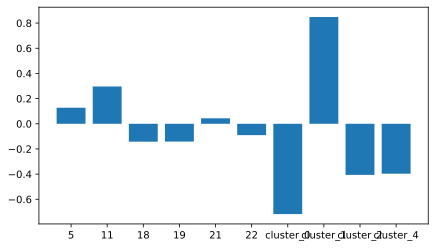

In [568]:
plt.bar(np.arange(len(w3)), w3)
plt.xticks(np.arange(len(w3)), cols3)

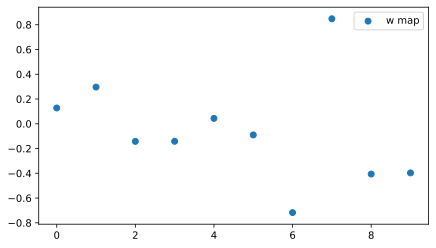

In [569]:
plot_weights(w3)

In [570]:
pred3 = predict_estimates_with_MF(X_test, w3, cols=cols3, cluster_centers=cluster_centers3, metric_mask=metric_mask3)

In [571]:
roc_auc_score(t_test, pred3)

0.6970087735514235

In [572]:
fpr, tpr, thresholds = metrics.roc_curve(t_test, pred3, pos_label=None)

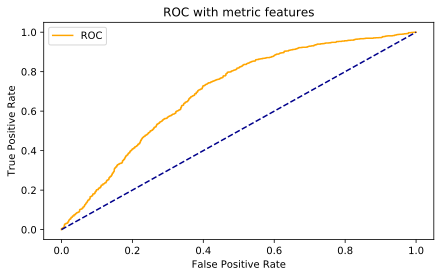

In [573]:
plot_roc_cur(fpr, tpr, title='ROC with metric features')

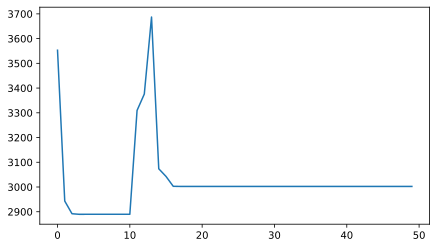

In [574]:
plt.plot(np.arange(len(costs3)),costs3)

In [508]:
model = LogisticRegression(random_state=0)
model.fit(X, T)

C:\Users\Irina\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [509]:
y_scores = model.predict_proba(X_test)[:, 1]

In [510]:
from sklearn.metrics import roc_auc_score
print('AUC-ROC', roc_auc_score(t_test, y_scores))

AUC-ROC 0.761931508199319


In [511]:
fpr, tpr, thresholds = metrics.roc_curve(t_test, y_scores, pos_label=None)

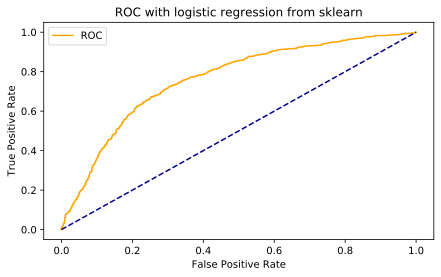

In [512]:
plot_roc_cur(fpr, tpr, title='ROC with logistic regression from sklearn')

In [487]:
coefs = np.abs(model.coef_[0])